<a href="https://colab.research.google.com/github/kaitken17/understand_nlp/blob/master/sythetic_analysis_seq2seq_chopped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_text

     |████████████████████████████████| 3.4MB 5.9MB/s 


In [2]:
import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers, stax

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from tqdm.notebook import tqdm

import os
import time
import pickle

from sklearn.decomposition import PCA
from scipy.special import softmax

import sys
sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/reverse-engineering-neural-networks')

import renn

sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/')
import seq2seq_files.toy_functions as toy
import seq2seq_files.scan_functions as scan
import seq2seq_files.train_and_build as train_build
import seq2seq_files.analysis as analysis

In [64]:
# Reload modules if changes have been made to them
from importlib import reload

reload(toy)
reload(scan)
reload(train_build)
reload(analysis)

<module 'seq2seq_files.analysis' from '/content/drive/My Drive/ml_research/fixedpoints_nlp/seq2seq_files/analysis.py'>

In [4]:
# Skips any tests and just runs function definitions
run_tests = False

state_colors = ['firebrick', 'darkgreen', 'blue', 'darkorange', 'm', 'deeppink', 'r', 'k', 'gray', 'g', 'b']
state_colors_light = ['salmon', 'limegreen', 'cornflowerblue', 'bisque', 'plum', 'pink', 'tomato']

# Synthetic Data

#### Toy Data Tests

In [5]:
# Various tests/confirmations of phrase generation
if run_tests:

  toy_params = {
    'phrase_length': 5,
    'var_length': False,
    'min_phrase_len': 2,
    'base_words': 3,
    'loss_type': 'XE',
    'rules': [], #prev0
    'pad_dim': True,
    'emb_dim': 20,
    'reverse_out': True,
  }

  toy_params['in_words'], toy_params['in_words_pp'], toy_params['phrase_words'] = toy.generateInputWordBank(toy_params)
  toy_params['out_words'], toy_params['out_words_pp'], toy_params['translations'] = toy.generateOutputWordBank(toy_params)

  print('Input words:', toy_params['in_words'])
  print('Input phrase words:', toy_params['phrase_words'])
  print('Output words:', toy_params['out_words'])
  print('Translation dic:', toy_params['translations'])

  # Makes five phrases and reports scores
  print('Three phrases and translations:')
  for i in range(3):
    toy_phrase = toy.make_toy_phrase(toy_params)
    print('Input phrase:', toy_phrase)
    out_phrase = toy.translate_toy_phrase(toy_phrase, toy_params)
    print('Output phrase:', out_phrase)

  out_phrase, in_phrase, out_phrase_tensor, in_phrase_tensor, out_target_mask, in_target_mask = toy.randomTrainingExample(toy_params)
  print('Input phrase:', in_phrase)
  print('Input phrase tensor:', in_phrase_tensor)
  print('Input target mask:', in_target_mask)
  print('Output phrase:', out_phrase)
  print('Output phrase tensor:', out_phrase_tensor)
  print('Out target mask:', out_target_mask)

#### Set SCAN params

Kept 6/20916 phrases. // Max in: 2 // Max out: 2 (pre-pad)
SCAN data generated in: 0.11 sec.
Input words: ['run', 'walk', 'jump', 'twice', '<.>', '<pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>']
Output words: ['I_RUN', 'I_WALK', 'I_JUMP', '<.>', '<pad>', '<out_dim_pad>', '<out_dim_pad>', '<out_dim_pad>', '<out_dim_pad>', '<out_dim_pad

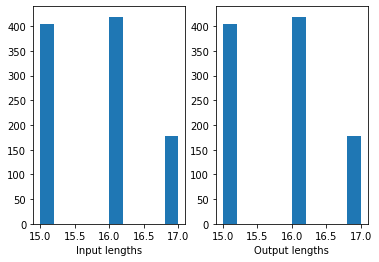

In [108]:
# Filter raw SCAN dataset and set toy parameters

# path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/tasks.txt'
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/tasks_mod1.txt'
text_data = scan.read_and_split_file(path)

# all_in_words = ['run', 'walk', 'look', 'jump', 'exercise', 'left', 'right', 'twice', 'opposite', 'thrice', 'turn', 'around', 'and', 'after']
# all_out_words = ['I_RUN', 'I_WALK', 'I_LOOK', 'I_JUMP', 'I_EXER1', 'I_EXER2', 'I_TURN_LEFT', 'I_TURN_RIGHT']

scan_params = {
  'in_words': ['run', 'walk', 'jump', 'twice'], 
  'out_words': ['I_RUN', 'I_WALK', 'I_JUMP',],
  # 'in_words': ['run', 'walk', 'jump', 'left', 'and', 'twice'], 
  # 'out_words': ['I_RUN', 'I_WALK', 'I_JUMP', 'I_TURN_LEFT'],
  'extend_scan': True,
  'min_out_len': 15,
  'max_out_len': 20,
  'max_in_len': 27,
  'trials': 1000,
  'plot_lens': True,
  'periods': True,
  'pad_dim': True,
  'emb_dim': 50,
}

# Reads in phrases from text_data and filters phrases to keep only those that have words in input_words
raw_in_phrases, raw_out_phrases = scan.read_and_filter_scan(text_data, scan_params['in_words'])

# Filters out `left twice' occurences
# raw_in_phrases, raw_out_phrases = scan.filter_out_left_twice(raw_in_phrases, raw_out_phrases, scan_params)

max_in = max(list(map(len, raw_in_phrases)))
max_out = max(list(map(len, raw_out_phrases)))

print(f'Kept {len(raw_in_phrases)}/{len(text_data)} phrases. // Max in: {max_in} // Max out: {max_out} (pre-pad)')

scan_data, scan_params = scan.generate_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=scan_params['trials'])
print('Input words:', scan_params['in_words'])
print('Output words:', scan_params['out_words'])

max_in = scan_data['inputs'].shape[1]
max_out = scan_data['labels'].shape[1]
print(f'Max in: {max_in} // Max out: {max_out} (post-pad)')

print('Scan input shape:', scan_data['inputs'].shape)
print('Scan labels shape:', scan_data['labels'].shape)
print('Scan in indexs shape:', scan_data['in_index'].shape)
print('Scan out indexs shape:', scan_data['out_index'].shape)

scan_params['plot_lens'] = False

# Sets toy parameters to match SCAN data so same code can be used below
toy_params = {
  'phrase_length': scan_params['max_in_len'],
  'var_length': True,
  'loss_type': 'XE',
  'in_words': scan_params['in_words'],
  'out_words': scan_params['out_words'],
  'scan_params': scan_params,
  'in_words_pp': scan_params['in_words_pp'],
  'out_words_pp': scan_params['out_words_pp'],
}


In [7]:
if run_tests:

  scan_params = {
    'in_words': ['run', 'walk', 'jump',],
    'out_words': ['I_RUN', 'I_WALK', 'I_JUMP', 'I_TURN_LEFT', 'I_TURN_RIGHT'],
    'extend_scan': True,
    'min_out_len': 25,
    'max_out_len': 30,
    'max_in_len': 31,
    'trials': 100,
    'plot_lens': True,
    'periods': False,
    'pad_dim': False
  }

  # Reads in phrases from text_data and filters phrases to keep only those that have words in input_words
  raw_in_phrases, raw_out_phrases = scan.read_and_filter_scan(text_data, scan_params['in_words'])

  max_in = max(list(map(len, raw_in_phrases)))
  max_out = max(list(map(len, raw_out_phrases)))

  print(f'Kept {len(raw_in_phrases)}/{len(text_data)} phrases. // Max in: {max_in} // Max out: {max_out} (pre-pad)')

  scan_data, scan_params = scan.generate_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=scan_params['trials'])

  max_in = scan_data['inputs'].shape[1]
  max_out = scan_data['labels'].shape[1]
  print('Total phrases:', scan_data['inputs'].shape[0], f'// Max in: {max_in} // Max out: {max_out} (post-pad)')

# Train and Build Network

#### Architecture Tests

In [8]:
if run_tests:

  seed = 342343
  prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

  data_type = 'toy'

  ########## Toy data parameters ##########
  if data_type == 'toy':
    toy_params = {
      'phrase_length': 30,
      'base_words': 3,
      'var_length': True,
      'min_phrase_len': 25,
      'loss_type': 'XE',
      'pad_dim': True,
      'emb_dim': 10,
      'rules': [None,] # prev0
    }

    toy_params['in_words'], toy_params['in_words_pp'], toy_params['phrase_words'] = toy.generateInputWordBank(toy_params)
    toy_params['out_words'], toy_params['out_words_pp'], toy_params['translations'] = toy.generateOutputWordBank(toy_params)

  ########## RNN hyperparameters ##########
  rnn_specs = {
    'cell_type': 'GRU',                              # Supports 'Vanilla', 'GRU', 'LSTM', or 'UGRNN'
    'arch': 'enc_dec_atth',                          # Type of architecture
    'pos_enc_params': {'pos_enc': True, 'time_scale': 25, 'amplitude': 1.0}, 
    'shorts': (),
    'zero_context': False,
    'zero_attention': False,
    'input_size': len(toy_params['in_words']),       # Number of inputs to the RNN
    'hidden_size': 128,                              # Number of units in the RNN
    'output_size': len(toy_params['out_words']),     # Number of outputs in the RNN
    'ro_bias': True,                                 # Include a bias with the readout
    'var_length': toy_params['var_length'],
    'ro_simplex_init': False,
    'phrase_length': toy_params['phrase_length'],     # Needed to build the attention matrix
  }
  if rnn_specs['var_length']: rnn_specs['in_eos_idx'] = toy_params['in_words'].index('<pad>')

  ########## Train hyperparameters ##########

  train_params = {
    'batch_size': 2,                     # How many examples in each batch
    'num_batchs': 1,                    # Total number of batches to train on.
  }

  train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] 
  train_params, toy_params, rnn_specs = train_build.default_params(train_params, toy_params, rnn_specs)

  if rnn_specs['pos_enc_params']['pos_enc']:
    print('Adding random positional encoding rotation')
    rnn_specs['pos_enc_params']['rot'] = train_build.rvs(rnn_specs['input_size'])
  # Generate the data to run through the RNN
  if data_type == 'toy':
    syn_data = train_build.generate_data(train_params['train_set_size'], toy_params, rnn_specs)
  else:
    syn_data, _ = train_build.generate_scan(raw_in_phrases, raw_out_phrases, toy_params['scan_params'], trials=train_params['train_set_size'])
  
  rnn_specs['out_len'] = syn_data['labels'].shape[1]

  print('Vocab:', toy_params['in_words'])
  print('Sythetic in lengths:', syn_data['in_index'])
  print('Sythetic out lengths:', syn_data['out_index'])

  # Initialize the optimizer.
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = train_build.build_rnn(rnn_specs)
  enc_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['in_words']))
  dec_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['out_words']))
  output_shape, initial_params = init_fun(prng_key, enc_input_shape, dec_input_shape)

  if rnn_specs['arch'] == 'enc_dec_att':
    rnn_params, rnn_params_dec, att_params, readout_params = initial_params
  elif rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_atth']:
    rnn_params, rnn_params_dec, readout_params = initial_params
  else:
    rnn_params, readout_params = initial_params

  # cell = build_cell(rnn_specs)
  out_logits, attn_matrix = apply_fun(initial_params, syn_data['inputs'], syn_data['in_index'], return_att_matrix=True)

  print('Output logits shape:', out_logits.shape)
  print('Output logits:', out_logits)
  # print('Output logits:', out_logits[0, :5, :2])
  # print('Output logits:', out_logits[1, :5, :2])
  print('Output labels:', syn_data['labels'])

In [9]:
seq_len_test = 25
word_dims = 20
test_seq = np.zeros((5, seq_len_test, word_dims))
scale = 50
amp = 1

# random_pos_enc_rot = np.identity(word_dims) 
random_pos_enc_rot = rvs(word_dims) 
pos_enc_inputs = test_seq, scale, amp, random_pos_enc_rot
pos_enc = positional_encoding(pos_enc_inputs)

print('First time step:', pos_enc[0,0,:7])

pos_enc_dots = np.zeros((seq_len_test, seq_len_test))
for i in range(seq_len_test):
  for j in range(seq_len_test):
    pos_enc_dots[i,j] = np.dot(pos_enc[0,i], pos_enc[0,j])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.matshow(pos_enc[0], cmap=plt.cm.seismic)
ax2.matshow(pos_enc_dots, cmap=plt.cm.seismic)

ax1.set_ylabel('Sequence Index')
ax1.set_xlabel('Word Index')

ax2.set_ylabel('Sequence Index')
ax2.set_ylabel('Sequence Index')

NameError: ignored

In [ ]:
seq_len_test = 20
word_dims = 6
test_seq = np.zeros((1, seq_len_test, word_dims))

amp = 1.0
pos_enc_scale = 20
pod_enc_inputs = test_seq, pos_enc_scale, amp, np.identity(word_dims)
pos_enc = positional_encoding(pod_enc_inputs)

pca_time = PCA(n_components=3)
pca_pe = pca_time.fit_transform(pos_enc[0]).T
print(pca_pe.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,4))
ax1.plot(pca_pe[0], pca_pe[1], color='darkblue')
ax2.plot(pca_pe[0], pca_pe[2], color='darkblue')
ax3.plot(pca_pe[1], pca_pe[2], color='darkblue')
# ax1.plot(pos_enc[0, :, 0], pos_enc[0, :, 1], color='darkblue')
# ax1.plot(pos_enc[0, :, 2], pos_enc[0, :, 3], color='darkred')
# ax1.plot(pos_enc[0, :, 4], pos_enc[0, :, 5], color='darkgreen')
# ax2.plot(pos_enc[0, :, 0], pos_enc[0, :, 2], color='darkblue')
# ax3.plot(pos_enc[0, :, 2], pos_enc[0, :, 4], color='darkblue')
ax1.set_xlabel('PC0')
ax1.set_ylabel('PC1')
ax2.set_xlabel('PC0')
ax2.set_ylabel('PC2')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')

In [ ]:
# Optimization hyperparameters
num_batchs = 20000        # Total number of batches to train on.
init_lr = 0.1          # initial learning rate
decay_factor = 0.9998     # decay the learning rate this much

learning_rate = optimizers.exponential_decay(init_lr, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = np.linspace(1, num_batchs)
plt.semilogy(batch_idxs, [learning_rate(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

#### Train the Network

In [113]:
seed = 342343
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

data_type = 'scan' # toy or scan

if data_type == 'toy':
  ########## Toy data parameters ##########
  toy_params = {
    'phrase_length': 1,    # INPUT phrase length (output phrase length could be different)
    'base_words': 3,
    'var_length': True,
    'min_phrase_len': 70,
    'pad_dim': False,
    'emb_dim': 10,
  }

  toy_params['in_words'], toy_params['in_words_pp'], toy_params['phrase_words'] = toy.generateInputWordBank(toy_params)
  toy_params['out_words'], toy_params['out_words_pp'], toy_params['translations'] = toy.generateOutputWordBank(toy_params)
 
########## RNN hyperparameters ##########
rnn_specs = {
  'cell_type': 'GRU',                              # Supports 'Vanilla', 'GRU', 'LSTM', or 'UGRNN'
  'arch': 'enc_dec_atth',                  # Architecture, supports 'one_to_one', 'enc_dec', 'enc_dec_short', 'enc_dec_att',
                                          # 'enc_dec_atth'
  'pos_enc_params': {'pos_enc': True, 'time_scale': 100.0, 'amplitude': 1.0},
  'zero_context': True,
  'zero_attention': False,
  'input_size': len(toy_params['in_words']),       # Number of inputs to the RNN
  'hidden_size': 128,                              # Number of units in the RNN
  'output_size': len(toy_params['out_words']),     # Number of outputs in the RNN
  'ro_bias': False,                                # Include a bias with the readout
  'var_length': toy_params['var_length'],
  'teacher_force': False,                           # Pass targets in as inputs
}
if rnn_specs['var_length']: rnn_specs['in_eos_idx'] = toy_params['in_words'].index('<pad>')

########## Train hyperparameters ##########

train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.
  'l2reg': 1e-4,           # amount of L2 regularization on the weights

  'init_lr': 0.1,                     # initial learning rate
  'decay_factor': 0.9997,             # decay the learning rate this much
  'adam_b1': 0.9,                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
  'adam_b2': 0.99,
  'adam_eps': 1e-1,

  'batch_size': 128,                     # How many examples in each batch
  'num_batchs': 1000,                    # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'n_datasets': 2,                           # Number of new train sets to generate total (this is slow)
  'epochs': 2,                               # How many times to go through each train set completely
  'test_set_size': 200,

  'init_pos_enc': False,
  'remove_pos_enc_step': 2000
}

train_params['decay_fun'] = optimizers.exponential_decay(train_params['init_lr'], decay_steps=1, 
                                                         decay_rate=train_params['decay_factor'])
train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] 
# Sets default parameters if they weren't set above
train_params, toy_params, rnn_specs = train_build.default_params(train_params, toy_params, rnn_specs)

########## Run ##########

print('# Input words (with dim pad):', len(toy_params['in_words']), '// (without):', len(toy_params['in_words_pp']), '// Input words:', toy_params['in_words_pp'])
print('# Output words (with dim pad):', len(toy_params['out_words']), '// (without):', len(toy_params['out_words_pp']), '// Output words:', toy_params['out_words_pp'])
print('Architecture:', rnn_specs['arch'])

# rnn_specs['pos_enc_params']['rot'] = np.identity(rnn_specs['input_size']) 
if rnn_specs['pos_enc_params']['pos_enc']:
  print('Adding random positional encoding rotation')
  rnn_specs['pos_enc_params']['rot'] = train_build.rvs(rnn_specs['input_size']) 

save_data = True
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/ao_twicescan_2datasets_l2is1e-4_2.pickle'
save_data = train_build.override_data(path, save_data)

# Initialize the optimizer.  Please see jax/experimental/optimizers.py
init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = train_build.build_rnn(rnn_specs)
enc_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['in_words']))
dec_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['out_words']))
output_shape, initial_params = init_fun(prng_key, enc_input_shape, dec_input_shape)

opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
opt_state, step_fun = train_build.build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])

init_opt, update_opt, get_params = opt

train_params['train_losses'] = []
train_params['global_step'] = 0
train_params['total_steps'] = 0

# Generate synthetic data and run training on said data
if data_type == 'toy':
  opt_state, train_params = train_build.train_on_synthetic_data(opt_state, step_fun, get_params, accuracy_fun, train_params, toy_params, rnn_specs)
elif data_type == 'scan':
  raw_phrases = raw_in_phrases, raw_out_phrases
  opt_state, train_params = train_build.train_on_scan_data(scan_data, opt_state, step_fun, get_params, accuracy_fun, train_params, toy_params, rnn_specs, raw_phrases)

train_params.pop('decay_fun') # Can't pickle with decay fun
train_build.save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params, save_loss=True, )

# Destructure the trained parameters of the RNN.
final_params = get_params(opt_state)
if rnn_specs['arch'] == 'enc_dec_att':
  rnn_params, rnn_params_dec, att_params, readout_params = final_params
elif rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_atth']:
  rnn_params, rnn_params_dec, readout_params = final_params
else:
  rnn_params, readout_params = final_params

# Input words (with dim pad): 50 // (without): 6 // Input words: ['run', 'walk', 'jump', 'twice', '<.>', '<pad>']
# Output words (with dim pad): 50 // (without): 5 // Output words: ['I_RUN', 'I_WALK', 'I_JUMP', '<.>', '<pad>']
Architecture: enc_dec_atth
Adding random positional encoding rotation
SCAN data generated in: 8.30 sec.
SCAN data generated in: 0.01 sec.
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Step 100, step size: 0.09707, phrase acc 0.0000, word acc 0.4411, avg training loss 1.4479
Step 200, step size: 0.09420, phrase acc 0.0000, word acc 0.4672, avg training loss 1.3103
Step 300, step size: 0.09142, phrase acc 0.0000, wo

In [ ]:
# Save the network
path =  '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/vec_toy_3words_15to20_l2is1e-4_2.pickle'

if 'decay_fun' in train_params: train_params.pop('decay_fun')

save_data = override_data(path, True)
save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params)

In [100]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/aed_andlefttwicescan_nolefttwice_5datasets_l2is1e-4_1.pickle'

with open(path, 'rb') as load_file:
  params_loaded = pickle.load(load_file)
  toy_params = pickle.load(load_file)
  rnn_specs = pickle.load(load_file)
  train_params = pickle.load(load_file)

rnn_params, rnn_params_dec, readout_params = params_loaded
final_params = params_loaded
train_params, toy_params, rnn_specs = train_build.default_params(train_params, toy_params, rnn_specs)
data_type = 'scan'

print('Data Loaded: data type:', data_type)

Data Loaded: data type: scan


Text(0, 0.5, 'Train Loss')

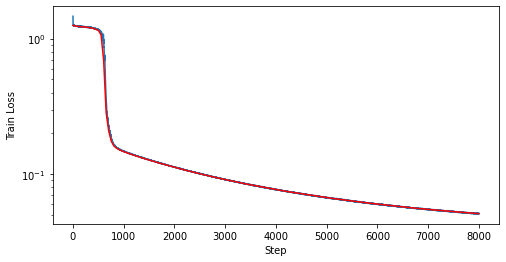

In [41]:
train_losses = train_params['train_losses']

plt.figure(figsize=(8, 4))
n_avg = 50
avg_loss = [1/n_avg * np.sum(train_losses[i*n_avg:(i+1)*n_avg]) for i in range(int(len(train_losses)/n_avg))]

plt.semilogy(np.linspace(1,len(train_losses),len(train_losses)), train_losses)
plt.semilogy(np.linspace(1,len(train_losses),int(len(train_losses)/n_avg)), avg_loss,'r')
plt.xlabel('Step')
plt.ylabel('Train Loss')

# Network Analysis

### Hidden State Analysis

In [110]:
# Get RNN hidden states in response to a test batch.
n_trials = 1000
eos_idx = toy_params['in_words'].index('<pad>') if toy_params['var_length'] else 0# assumes eos is last word in vocab

_, apply_fun, _, _, accuracy_fun = train_build.build_rnn(rnn_specs)

if rnn_specs['teacher_force']:
  print('Turning teacher forcing off.')
  rnn_specs['teacher_force'] = False
if data_type == 'toy':
  hs_data = train_build.generate_data(n_trials, toy_params, rnn_specs)
elif data_type == 'scan':
  scan_data, _ = scan.generate_scan(raw_in_phrases, raw_out_phrases, toy_params['scan_params'], trials=n_trials)
  hs_data =  {
    'inputs': scan_data['inputs'],
    'labels': scan_data['labels'],
    'in_index': scan_data['in_index'],
    'out_index': scan_data['out_index'],
  }

phrase_acc, word_acc = accuracy_fun(final_params, hs_data)
print('******** Test Acc:', np.mean(phrase_acc), 'Word Acc:', np.mean(word_acc), '********')

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

if rnn_specs['arch'] == 'one_to_one':
  cell = analysis.build_cell(rnn_specs)
  raw_hs = analysis.rnn_states(cell, hs_data, final_params)
else: 
  cell, readout_apply = analysis.build_cell(rnn_specs)
  if rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_att', 'enc_dec_atth']:
    cell_dec, readout_apply = analysis.build_cell(rnn_specs)
  print('Running full data for plotting hidden states')
  cells = cell, cell_dec
  raw_hs = analysis.rnn_states(cells, readout_apply, hs_data, final_params, rnn_specs)
  
  # Creates special inputs to get outputs from just positional encoding
    # First (rnn_specs['input_size']) of these will be all a given input with '<pad>' at end
    # idx -2 will be average input with '<pad>' at end
    # idx -1 will be no input (with no pad)
  special_inputs = np.zeros((2 + rnn_specs['input_size'],) + hs_data['inputs'][0].shape)
  for i in range(rnn_specs['input_size']): # Creates an input that is one-hot in same position
    special_inputs[i, :-1, i] = np.ones((hs_data['inputs'][0].shape[0]-1))
  special_inputs[-2, :-1, :] = 1/rnn_specs['input_size'] * np.ones((hs_data['inputs'][0].shape[0]-1, hs_data['inputs'][0].shape[1])) # average input
  special_inputs[:-1, -1, eos_idx] =  np.ones((1 + rnn_specs['input_size']))
  special_data =  {
    'inputs': special_inputs,
    'labels': jnp.zeros((special_inputs.shape[0],) + hs_data['labels'][0].shape), # These aren't used
    'in_index': jnp.asarray([np.max(hs_data['in_index']) for _ in range(special_inputs.shape[0])]),
    'out_index': jnp.asarray([np.max(hs_data['out_index']) for _ in range(special_inputs.shape[0])]),
  }
  print('Running special data ')
  special_hs = analysis.rnn_states(cells, readout_apply, special_data, final_params, rnn_specs)

  hs = {}
  
  hs = {
    'enc': [h[:enc_len] for h in raw_hs],
    'dec': [h[enc_len:enc_len + len] 
                for h, len in zip(raw_hs, hs_data['out_index'])], # includes final encoder hs 
    'encf': [h[enc_len-1] for h in raw_hs],
    'decf': [h[enc_len + len -1] for h, len in zip(raw_hs, hs_data['out_index'])],
  }

  print('Encoder list length:', len(hs['enc']) ,'// Individual shape:', hs['enc'][0].shape)
  print('Decoder list length:', len(hs['dec']) ,'// Individual shape:', hs['dec'][1].shape)

hs['all'] = raw_hs
hs['special'] = special_hs
print('All list length:', len(hs['all']) ,'// Individual shape:', hs['all'][0].shape)

# test_acc = accuracy_fun_ext(final_params, hs_data)
# print('Test Accuracy:', test_acc)
# rnn_specs['zero_context'] = False

if rnn_specs['arch'] in ['enc_dec_atth'] and not rnn_specs['zero_context']  and not rnn_specs['zero_attention']:
  if rnn_specs['ro_bias']: raise NotImplementedError
  hidden_split = rnn_specs['hidden_size'] if rnn_specs['cell_type'] != 'LSTM' else 2*rnn_specs['hidden_size']
  readout = readout_params[hidden_split:, :len(toy_params['out_words_pp'])].T # Ignores padded dimensions
  readout_dec = readout_params[:hidden_split, :len(toy_params['out_words_pp'])].T
  print('Readout_enc/Readout_dec ratio:', np.linalg.norm(readout)/ np.linalg.norm(readout_dec))
else:
  if rnn_specs['ro_bias']:
    wO, bO = readout_params
  else:
    readout = readout_params[:, :len(toy_params['out_words_pp'])].T
print('Readout shape:', readout.shape)

SCAN data generated in: 0.07 sec.
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
******** Test Acc: 1.0 Word Acc: 1.0 ********
Using GRU cell
Using GRU cell
Running full data for plotting hidden states
Get all states with arch: enc_dec_atth
Running attnh with pos_enc: True
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Running special data 
Get all states with arch: enc_dec_atth
Running attnh with pos_enc: True
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Encoder list length: 1000 // Individual shape: (18, 128)
Decoder list length: 1000 // Individual shape: (15, 128)
All list length: 1000 // Individual shape: (36, 128)
Readout shape: (5, 128)


Top 10 components: 0.9161824820503386 ( [0.29633607 0.12451338 0.11591001 0.08788436 0.06915523 0.05526641
 0.05456813 0.04123299 0.03696673 0.03434917] )
Participation Ratio: 7.112408406958722
Copy this: PCA: [0.29633607 0.12451338 0.11591001 0.08788436 0.06915523 0.05526641
 0.05456813 0.04123299 0.03696673 0.03434917] PR: 7.112408406958722
Readout vec proj via PCA: [[ 0.9060793   1.2878696   0.76416385  1.4362142 ]
 [-1.0318266   0.93401766  0.11876137  0.4324695 ]
 [ 0.1005838   0.03512277 -0.6302579  -0.15867509]
 [ 0.8015924   1.2214307  -0.60878426  0.48347005]
 [-0.9481305  -0.3764207  -0.27451593  0.9017488 ]
 [-0.8571493   0.10298402  2.2382274   0.33684114]
 [ 2.2120473  -0.3719147   0.5997006   0.24001475]
 [-1.0849876   1.4131593  -0.8526066  -0.5342452 ]
 [-1.8789996   1.6004099   1.2551721  -0.12804   ]
 [-0.35838228 -1.8618791   2.136916   -0.0633916 ]]
h0 shape (128,)


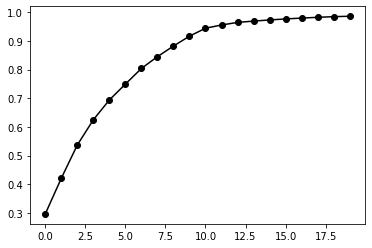

In [13]:
pc_dims = 10
pts_subset = 'all' # supports 'enc', 'dec', 'all', and 'encf'

# Finds percentage of variance explained by top pc_dims of PCA
# pca_full = PCA(n_components=rnn_specs['hidden_size'])
pca_full = PCA(n_components=np.min([len(hs[pts_subset]), rnn_specs['hidden_size']]))
_ = pca_full.fit_transform(np.vstack(hs[pts_subset]))
explained_var = pca_full.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
print('Participation Ratio:', analysis.participation_ratio_vector(pca_full.explained_variance_))
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', analysis.participation_ratio_vector(pca_full.explained_variance_))
total_exvar = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar.append(np.sum(explained_var[:i+1]))
plt.figure()
plt.plot(total_exvar[:20], 'k-o')

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(np.vstack(hs[pts_subset]))
print('Readout vec proj via PCA:', pca.transform(readout).T)

# The initial state.
h0 = cell.get_initial_state(rnn_params)[:rnn_specs['hidden_size']]
print('h0 shape', h0.shape)

Plotting encoder states
Plotting decoder states
Example phrase length: 77
Example phrase: ['I0', 'I2', 'I1', 'I2', 'I2', 'I2', 'I0', 'I0', 'I2', 'I0', 'I1', 'I2', 'I2', 'I2', 'I1', 'I0', 'I1', 'I1', 'I0', 'I2', 'I1', 'I0', 'I1', 'I1', 'I0', 'I1', 'I0', 'I1', 'I1', 'I2', 'I1', 'I0', 'I2', 'I0', 'I2', 'I1', 'I0', 'I1', 'I2', 'I0', 'I2', 'I1', 'I2', 'I1', 'I0', 'I0', 'I1', 'I1', 'I0', 'I0', 'I1', 'I0', 'I1', 'I2', 'I0', 'I0', 'I0', 'I1', 'I2', 'I1', 'I1', 'I0', 'I1', 'I0', 'I2', 'I0', 'I0', 'I1', 'I0', 'I2', 'I1', 'I0', 'I0', 'I1', 'I0', 'I0', 'I0', '<pad>', '<pad>', '<pad>']


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


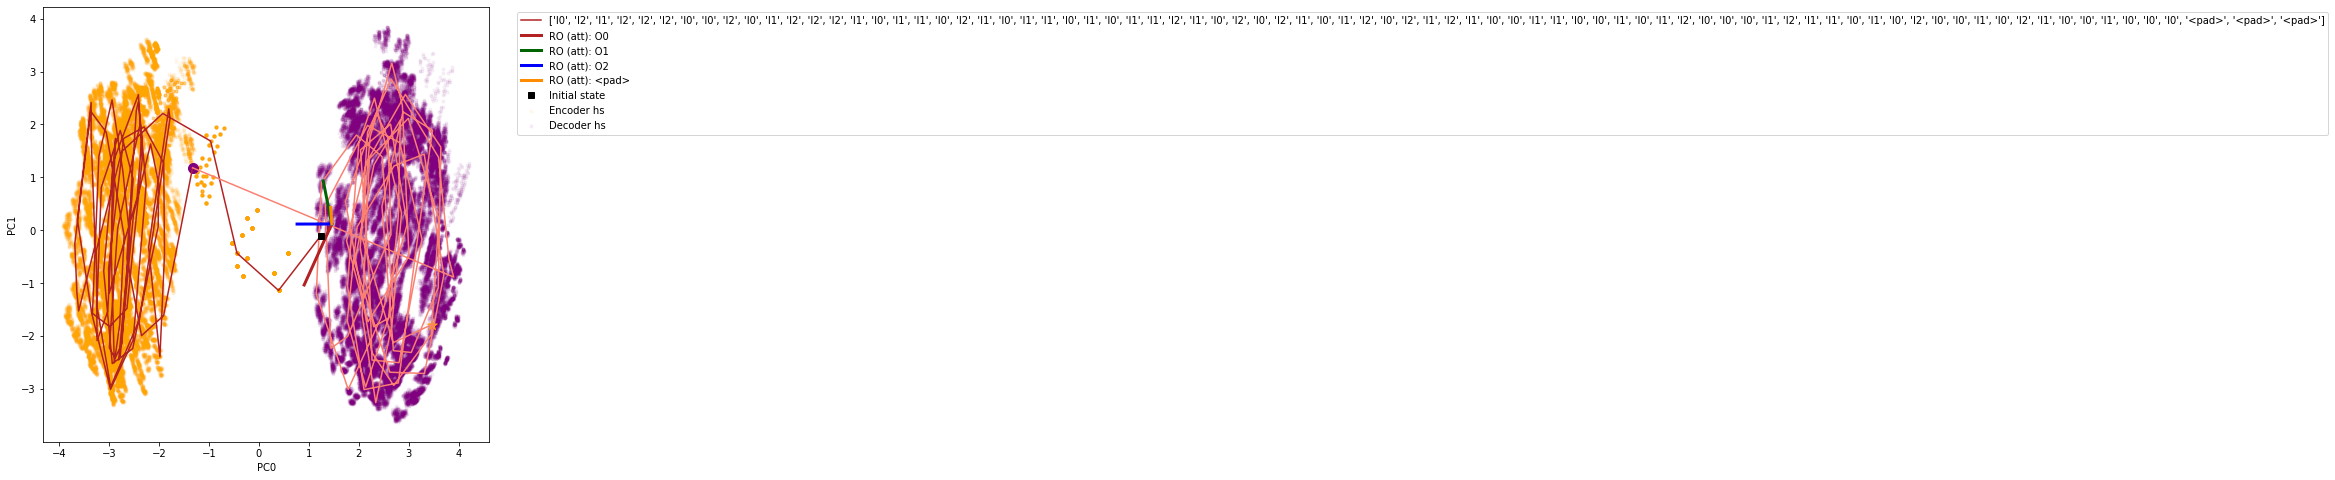

In [14]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

pts_subset = 'all'

plt.figure(figsize=(8, 8))

pc1 = 0
pc2 = 1

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

final_hs_idx = 2*toy_params['phrase_length'] if pts_subset == 'all' and not rnn_specs['arch'] == 'one_to_one' else toy_params['phrase_length']
encode_hs_idx = 0 if pts_subset == 'dec' else enc_len

pca_h0 = pca.transform(np.atleast_2d(h0)).T
# pca_h0 = pca.transform(np.atleast_2d(np.concatenate([h0, np.zeros((h0.shape))], axis=0))).T

# Plots hidden states as scatter plot
fs_alpha = 0.05
if pts_subset in ['all', 'enc']: # Encoder states
  print('Plotting encoder states')
  pca_enc = pca.transform(np.vstack(hs['enc'])).T
  plt.scatter(pca_enc[pc1], pca_enc[pc2], color = 'orange', marker='.', alpha=fs_alpha, label='Encoder hs')
if pts_subset in ['all', 'dec']: # Decoder states
  print('Plotting decoder states')
  pca_dec = pca.transform(np.vstack(hs['dec'])).T
  plt.scatter(pca_dec[pc1], pca_dec[pc2], color = 'purple', marker='.', alpha=fs_alpha, label='Decoder hs')

# Plots example paths
hs_idxs = [1] # [0]
for hs_idx in hs_idxs: # Plots example paths
  out_idx = hs_data['out_index'][hs_idx]
  print('Example phrase length:', out_idx)
  print('Example phrase:', toy.tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  if pts_subset in ['enc', 'all']: # Adds h0 to path and plots
    pca_state = np.concatenate((pca_h0, pca.transform(hs[pts_subset][hs_idx]).T), axis=1) 
    if pts_subset == 'all':
      plt.plot(pca_state[pc1][:enc_len+1], pca_state[pc2][:enc_len+1], color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=1.0,
              label=toy.tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
      plt.plot(pca_state[pc1][enc_len:enc_len+out_idx+1], pca_state[pc2][enc_len:enc_len+out_idx+1], color = state_colors_light[hs_idxs.index(hs_idx)], marker=None, alpha=1.0)
    elif pts_subset == 'enc':
      plt.plot(pca_state[pc1], pca_state[pc2], color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=0.5, 
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  else: # Doesn't add h0 to path and plots
    pca_state = pca.transform(hs[pts_subset][hs_idx]).T
    plt.plot(pca_state[pc1], pca_state[pc2], color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=0.5, 
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  if pts_subset in ['dec', 'all']:  # Puts star on final hidden state
    pca_decf = pca.transform(np.atleast_2d(hs['decf'][hs_idx])).T
    plt.scatter(pca_decf[pc1], pca_decf[pc2], color = 'orange', marker='*', s=100.0, alpha=1.0)


  plt.scatter(pca_state[pc1, encode_hs_idx], pca_state[pc2, encode_hs_idx], color = 'purple', marker='o', 
                s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# Special inputs plotting
# pos_enc_idxs = [0, 1, 2, 3]
# pos_enc_labs = ['0 hot', '1 hot', '2 hot', '3 hot', 'pos enc']
# for pos_enc_idx in pos_enc_idxs:
#   if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
#     pca_state = np.concatenate((pca_h0, pca.transform(hs['pos_enc'][pos_enc_idx]).T), axis=1) 
#   if pts_subset == 'all':
#     plt.plot(pca_state[pc1][:pl+1], pca_state[pc2][:pl+1], color = state_colors[pos_enc_idxs.index(pos_enc_idx)], 
#              marker=None, alpha=1.0, label=pos_enc_labs[pos_enc_idxs.index(pos_enc_idx)])
#     plt.plot(pca_state[pc1][pl:], pca_state[pc2][pl:], color = state_colors_light[pos_enc_idxs.index(pos_enc_idx)],
#              marker=None, alpha=1.0)
#   else:
#     plt.plot(pca_state[pc1], pca_state[pc2], color =  'k', marker=None, alpha=0.5, 
#               label=pos_enc_labs[pos_enc_idxs.index(pos_enc_idx)])
#   plt.scatter(pca_state[pc1, encode_hs_idx+1], pca_state[pc2, encode_hs_idx+1], color = 'k', marker='o', 
#                 s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# pca_states = pca.transform(np.vstack(hs)).T
# plt.plot(pca_states[pc1], pca_states[pc2], c = 'k', marker='o', alpha=0.01, label='Hidden sates')

# Plots readout direction
readout_type = 'att' # 'att' or 'hs'
readout_plot = readout if readout_type == 'att' else readout_dec
pca_ro = pca.transform(readout_plot)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
# pca_zero = pca.transform(np.atleast_2d(np.zeros((2*rnn_specs['hidden_size'],)))).T
for i in range(readout_plot.shape[0]):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, label=f'RO ({readout_type}): '+ toy_params['out_words'][i])

# path_idxs = [54, 56, 57]
# for path_idx in path_idxs:
#   print('Path labels:', syn_data_test['labels'][path_idx])
#   path_pca = pca.transform(hs[path_idx]).T
#   plt.plot(path_pca[pc1], path_pca[pc2], c='orange', marker='.', label='Random Path')

plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

plt.xlabel('PC'+str(pc1))
plt.ylabel('PC'+str(pc2))
plt_lim = None
if plt_lim != None:
  plt.xlim(-plt_lim, plt_lim)
  plt.ylim(-plt_lim, plt_lim)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
for i in range(12):
  print(f'Example phrase {i}:', tensorToPhrase(hs_data['inputs'][i], toy_params['in_words']))

Example phrase 0: ['run', '<pad>', '<pad>', '<pad>']
Example phrase 1: ['walk', 'and', 'jump', '<pad>']
Example phrase 2: ['jump', 'and', 'run', '<pad>']
Example phrase 3: ['walk', '<pad>', '<pad>', '<pad>']
Example phrase 4: ['run', 'and', 'walk', '<pad>']
Example phrase 5: ['walk', 'and', 'run', '<pad>']
Example phrase 6: ['run', 'and', 'jump', '<pad>']
Example phrase 7: ['run', 'and', 'run', '<pad>']
Example phrase 8: ['jump', 'and', 'jump', '<pad>']
Example phrase 9: ['jump', 'and', 'walk', '<pad>']
Example phrase 10: ['jump', '<pad>', '<pad>', '<pad>']
Example phrase 11: ['walk', 'and', 'walk', '<pad>']


#### Readout Vector Analysis

In [ ]:
from itertools import combinations 

def subspace_perc(A, b):
  """
  A: an N x M matrix, whose column space represents some M-dimensional subspace
  b: an N x P vector
  For each of b's columns, finds the percentage of its magnitude which lies in 
  the subspace formed by the columns of A (its columnspace). Then averages these together
  """
  proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # N x N matrix
  b_proj = np.matmul(proj, b) # N x P martix

  norm_perc = np.linalg.norm(b_proj, axis=0)/np.linalg.norm(b, axis=0) # P dim vector

  return np.mean(norm_perc)

def ro_subspace_analysis(readout):
  readout = np.asarray(readout)
  ro_n = readout.shape[0]
  indices = [i for i in range(ro_n)]
  for ss_dim in range(1, ro_n): # Tries dimensions from 1 to ro_n - 1
    comb = combinations(indices, ss_dim) # Gets all possible combinations
    n_comb = 0
    perc_vals = 0
    for subspace_idxs in list(comb): # For each combination
      n_comb += 1
      A_idxs = list(subspace_idxs)
      b_idxs = list(filter(lambda a: a not in list(subspace_idxs), indices))
      A = readout[A_idxs]
      b = readout[b_idxs] 
      perc_vals += subspace_perc(A.T, b.T)
    print('Avg perc in rest for subspace dim {}:'.format(ss_dim), 1/n_comb * perc_vals)

readout_mags = []
readout_pca_mags = []
pc_dims = 2
for i in range(len(readout)):
  readout_mags.append(np.linalg.norm(readout[i]))
  # readout_pca_mags.append(np.linalg.norm(np.matmul(comp, readout.T).T[i][:pc_dims]))
  print('Readout {} mag:'.format(i), readout_mags[i])
  # print('Readout {}'.format(i), '(perc in first {} PC dims):'.format(pc_dims), readout_pca_mags[i]/readout_mags[i])

for i in range(len(readout)):
  for j in range(i):
    print('Angle ({}, {}):'.format(i,j), 180/np.pi * np.arccos(np.dot(readout[i], readout[j])/(readout_mags[i]*readout_mags[j])))

ro_subspace_analysis(readout)

if rnn_specs['arch'] in ['enc_dec_atth']:
  for i in range(len(readout_dec)):
    print('Readout (decoder) {} mag:'.format(i), np.linalg.norm(readout_dec[i]))
    # readout_pca_mags.append(np.linalg.norm(np.matmul(comp, readout.T).T[i][:pc_dims]))
  for i in range(len(readout_dec)):
    print('Readout att/decoder {} dot:'.format(i), 180/np.pi * np.arccos(np.dot(readout[i], readout_dec[i])/
          (np.linalg.norm(readout[i])*np.linalg.norm(readout_dec[i]))))

Readout 0 mag: 3.9141
Readout 1 mag: 3.8970046
Readout 2 mag: 3.9691508
Readout 3 mag: 4.007365
Readout 4 mag: 1.2966049
Readout 5 mag: 1.467334
Angle (1, 0): 108.34536469056633
Angle (2, 0): 108.87228646427613
Angle (2, 1): 108.65870644892983
Angle (3, 0): 107.46310915547578
Angle (3, 1): 108.34397133197564
Angle (3, 2): 108.20469011442074
Angle (4, 0): 87.11663814635729
Angle (4, 1): 86.67764139783306
Angle (4, 2): 88.13600972903583
Angle (4, 3): 89.00772628223706
Angle (5, 0): 90.14312911853578
Angle (5, 1): 84.029693169835
Angle (5, 2): 92.36022901368943
Angle (5, 3): 92.863518332871
Angle (5, 4): 116.04028313025937
Avg perc in rest for subspace dim 1: 0.17867425953348476
Avg perc in rest for subspace dim 2: 0.3144105200966199
Avg perc in rest for subspace dim 3: 0.4457833379507065
Avg perc in rest for subspace dim 4: 0.5955171118179957
Avg perc in rest for subspace dim 5: 0.7800966302553812
Readout (decoder) 0 mag: 1.5214894
Readout (decoder) 1 mag: 1.6672632
Readout (decoder) 2 m

Text(0.5, 0, 'Decoder Readout Idx')

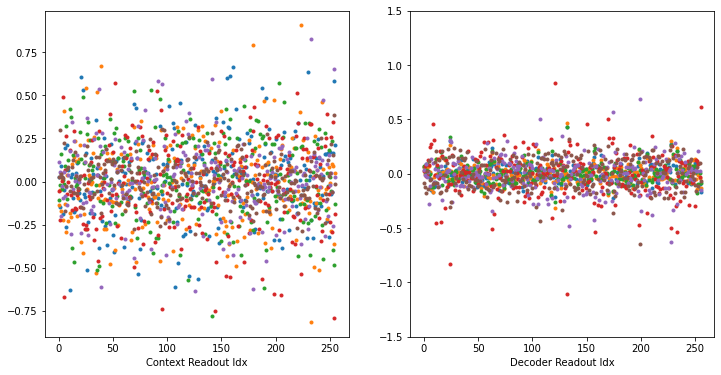

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

for i in range(6):
  ax1.plot(np.arange(256), readout[i], linewidth=0.0, marker='.')
for i in range(6):
  ax2.plot(np.arange(256), readout_dec[i], linewidth=0.0, marker='.')

plt.ylim([-1.5,1.5])
ax1.set_xlabel('Context Readout Idx')
ax2.set_xlabel('Decoder Readout Idx')

x 1.0
y 0.99999994
x.y 0.0
Example phrase length: 15
Example phrase: ['I0', 'I0', 'I0', 'I0', 'I0', 'I2', 'I2', 'I0', 'I1', 'I1', 'I2', 'I2', 'I1', 'I0', 'I1', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


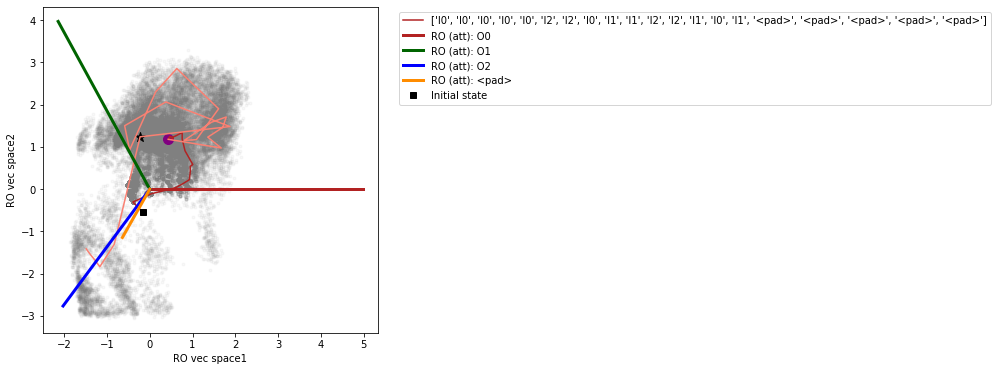

In [ ]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
readout_type = 'att' # 'att' or 'hs'
readout_plot = readout if readout_type == 'att' else readout_dec
x_basis = readout_plot[ro1] / np.linalg.norm(readout_plot[ro1])
y_vec = readout_plot[ro2] - np.dot(x_basis, readout_plot[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

h0_x_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), x_basis)
h0_y_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), y_basis)

# Plots hidden states
fs_alpha = 0.05
hs_x_vals = np.dot(np.matmul(np.vstack(hs[pts_subset]), proj), x_basis)
hs_y_vals = np.dot(np.matmul(np.vstack(hs[pts_subset]), proj), y_basis)
if pts_subset == 'all':
  pl = input_phrase_len
  plt.scatter(hs_x_vals[:pl], hs_y_vals[:pl], color = 'k', marker='.', alpha=fs_alpha)
  plt.scatter(hs_x_vals[pl-1:], hs_y_vals[pl-1:], color = 'gray', marker='.', alpha=fs_alpha)
else:
  plt.scatter(hs_x_vals, hs_y_vals, color = 'purple', marker='.', alpha=fs_alpha)

hs_idxs = [0]
for hs_idx in hs_idxs: # Plots example paths
  print('Example phrase length:', hs_data['out_index'][hs_idx])
  print('Example phrase:', tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
    hs_path_x = np.concatenate((np.asarray([h0_x_val,]), np.dot(np.matmul(np.vstack(hs[pts_subset][hs_idx]), proj), x_basis)))
    hs_path_y = np.concatenate((np.asarray([h0_y_val,]), np.dot(np.matmul(np.vstack(hs[pts_subset][hs_idx]), proj), y_basis)))
  if pts_subset == 'dec' or pts_subset == 'all':  # Puts star on final hidden state
    x_decf = np.dot(np.matmul(hs['decf'][hs_idx], proj), x_basis)
    y_decf = np.dot(np.matmul(hs['decf'][hs_idx], proj), y_basis)
    plt.scatter(x_decf, y_decf, color = 'k', marker='*', 
                s=100.0, alpha=1.0)
  if pts_subset == 'all':
    plt.plot(hs_path_x[:pl+1], hs_path_y[:pl+1], color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=1.0,
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
    plt.plot(hs_path_x[pl:], hs_path_y[pl:], color = state_colors_light[hs_idxs.index(hs_idx)], marker=None, alpha=1.0)
  else:
    plt.plot(hs_path_x, hs_path_y, color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=0.5, 
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  plt.scatter(hs_path_x[encode_hs_idx+1], hs_path_y[encode_hs_idx+1], color = 'purple', marker='o', 
                s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# # Positional encoding plotting
# if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
#   hs_path_x = np.concatenate((np.asarray([h0_x_val,]), np.dot(np.matmul(np.vstack(hs['special'][0]), proj), x_basis)))
#   hs_path_y = np.concatenate((np.asarray([h0_y_val,]), np.dot(np.matmul(np.vstack(hs['special'][0]), proj), y_basis)))
# if pts_subset == 'all':
#   plt.plot(pca_state[pc1][:pl+1], pca_state[pc2][:pl+1], color = 'k', marker=None, alpha=1.0,
#             label='Pos Enc Output')
#   plt.plot(pca_state[pc1][pl:], pca_state[pc2][pl:], color = 'k', marker=None, alpha=1.0)
# else:
#   plt.plot(pca_state[pc1], pca_state[pc2], color =  'k', marker=None, alpha=0.5, 
#             label='Pos Enc Output')
# plt.scatter(pca_state[pc1, encode_hs_idx+1], pca_state[pc2, encode_hs_idx+1], color = 'k', marker='o', 
#               s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# Plots readout direction
pca_ro = pca.transform(readout_plot)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(readout_plot.shape[0]):
  ro_proj = np.matmul(proj, readout_plot[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], color=state_colors[i], 
           linewidth = 3, label=f'RO ({readout_type}): '+toy_params['out_words'][i])

plt.plot(h0_x_val, h0_y_val, 'ks', label='Initial state')

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

plt_lim = None
if plt_lim != None:
  plt.xlim(-plt_lim, plt_lim)
  plt.ylim(-plt_lim, plt_lim)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#### Attention Analysis

Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
In index 16
Out index 16
In index 15
Out index 15


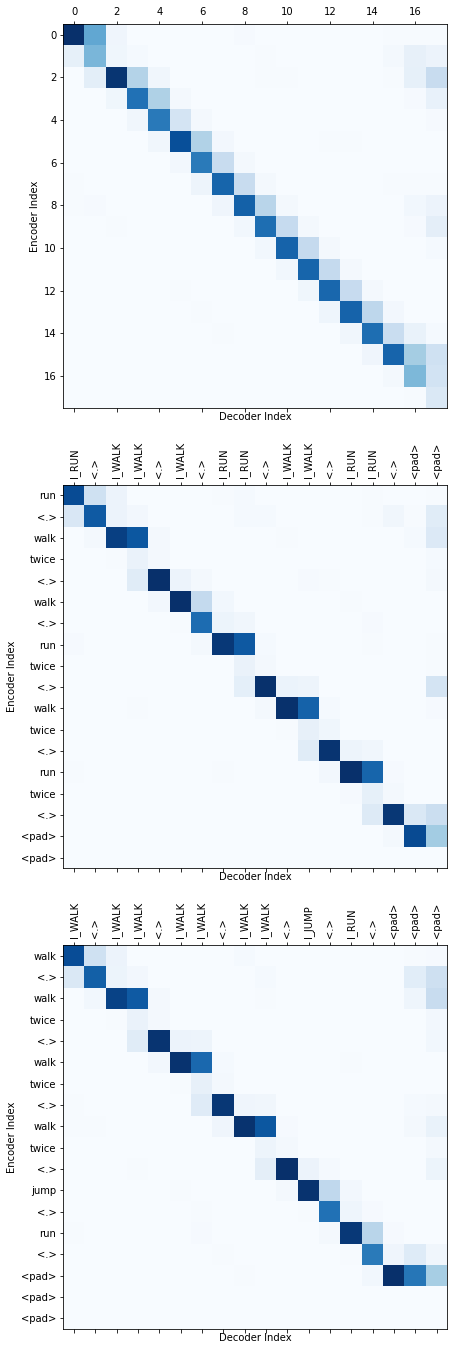

In [111]:
# Calculate attention matrix via apply function
enc_len = hs_data['inputs'][0].shape[0]
dec_len =  hs_data['labels'][0].shape[0]

_, new_apply_fun, _, _, _ = train_build.build_rnn(rnn_specs)
all_logits, attn_matrix_dir = new_apply_fun(final_params, hs_data['inputs'], hs_data['in_index'], return_att_matrix=True)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,24))

phrase_idxs = [0, 1]

ax1.set_ylabel('Encoder Index')
ax1.set_xlabel('Decoder Index')

# Mean attention matrix
ax1.matshow(np.mean(attn_matrix_dir, axis=0), cmap=plt.cm.Blues)

for ax, i in zip((ax2, ax3), phrase_idxs):
  print('In index', hs_data['in_index'][i])
  print('Out index', hs_data['out_index'][i])
  
  ax.matshow(attn_matrix_dir[i], cmap=plt.cm.Blues)
  enc_labels = toy.tensorToPhrase(hs_data['inputs'][i], toy_params['in_words'])
  dec_labels = toy.tensorToPhrase(hs_data['labels'][i], toy_params['out_words'])

  ax.set_ylabel('Encoder Index')
  ax.set_xlabel('Decoder Index')

  ax.set_xticks([j for j in range(dec_len)])
  ax.set_yticks([j for j in range(enc_len)])
  ax.set_yticklabels(enc_labels, rotation=0)
  ax.set_xticklabels(dec_labels, rotation=90)

Single sequence shape: (33, 256)
0


KeyboardInterrupt: ignored

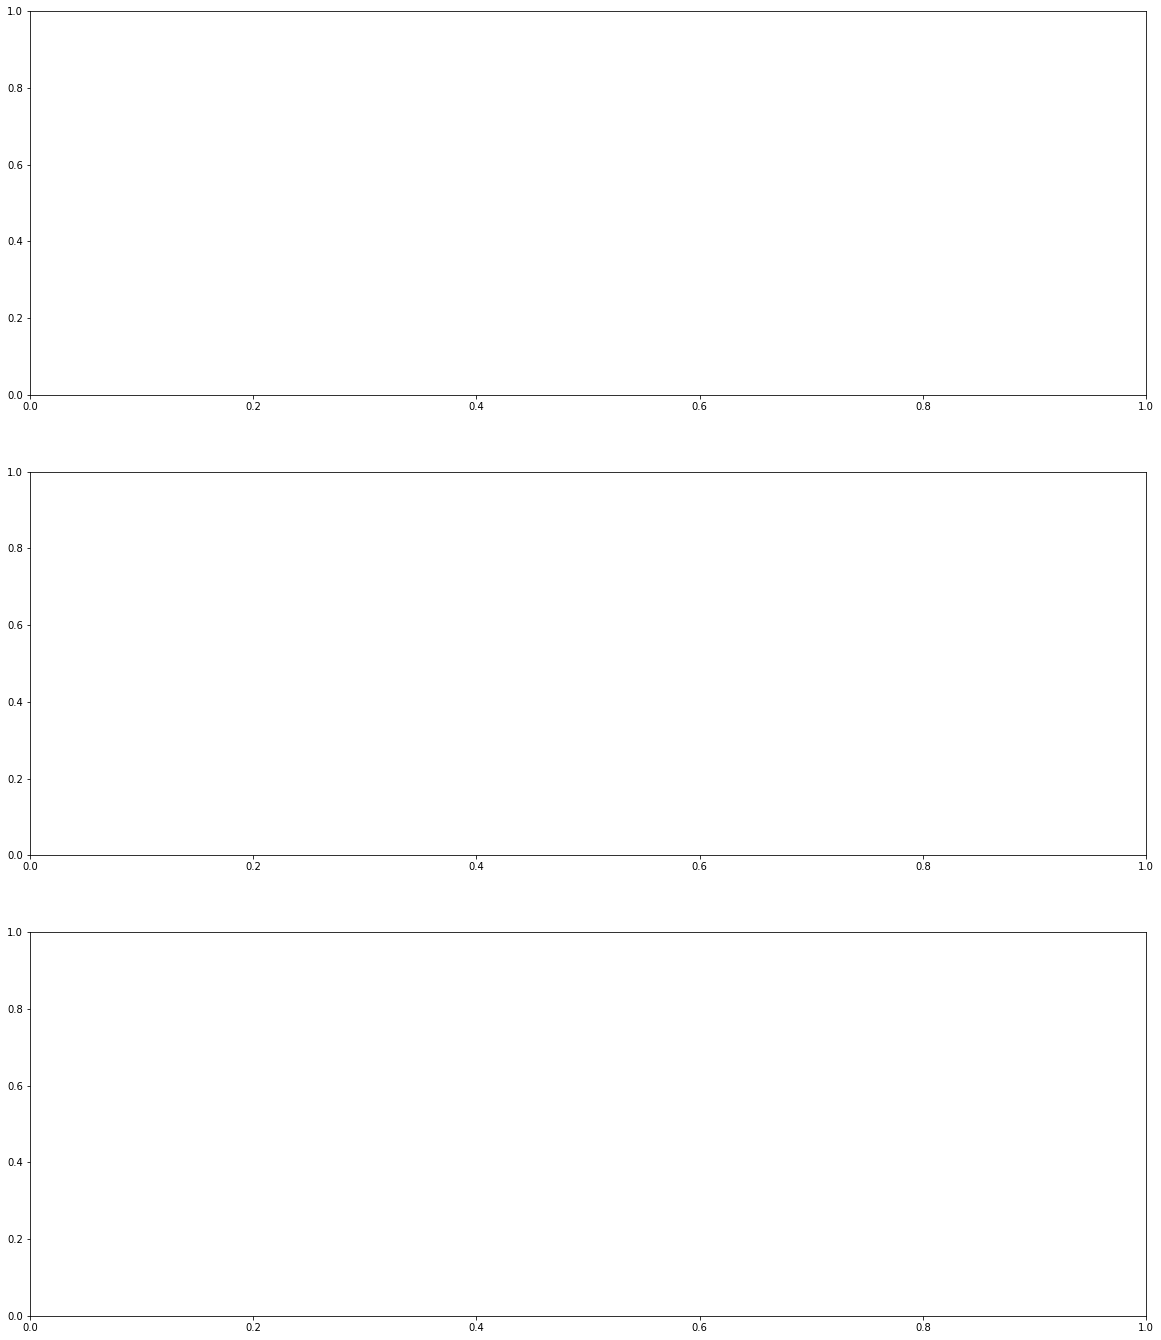

In [ ]:
# Calculate attention matrix by hand via hidden states

from scipy.special import softmax
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,24))

print('Single sequence shape:', hs['all'][0].shape)
enc_len = hs_data['inputs'][0].shape[0]
dec_len =  hs_data['labels'][0].shape[0]
attention_matrix = np.zeros((len(hs['all']), enc_len, dec_len))
for h_idx in range(len(hs['all'])):
  if h_idx % 100 == 0: print(h_idx)
  enc_seq = hs['all'][h_idx][:enc_len]
  for seq_idx in range(dec_len):
    raw_aligns = np.dot(enc_seq, hs['all'][h_idx][enc_len + seq_idx])
    # Masks if beyond in_index length
    raw_aligns[hs_data['in_index'][h_idx]+1:] = -10000 * np.ones((enc_len - hs_data['in_index'][h_idx]-1))
    attention_matrix[h_idx, :, seq_idx] = softmax(raw_aligns)

# Mean attention matrix
ax1.matshow(np.mean(attention_matrix, axis=0), cmap=plt.cm.Blues)

phrase_idxs = [8, 9]

ax1.set_ylabel('Encoder Index')
ax1.set_xlabel('Decoder Index')

for ax, i in zip((ax2, ax3), phrase_idxs):
  ax.matshow(attention_matrix[i], cmap=plt.cm.Blues)
  enc_labels = tensorToPhrase(hs_data['inputs'][i], toy_params['in_words'])
  dec_labels = tensorToPhrase(hs_data['labels'][i], toy_params['out_words'])

  ax.set_ylabel('Encoder Index')
  ax.set_xlabel('Decoder Index')

  ax.set_xticks([j for j in range(dec_len)])
  ax.set_yticks([j for j in range(enc_len)])
  ax.set_yticklabels(enc_labels, rotation=0)
  ax.set_xticklabels(dec_labels, rotation=90)

True


### Find Fixed Points

In [ ]:
add_noise = True
noise_scale = 0.5
cell_type = 'enc'

word = '<pad>' # 'I0'
if word == None:
  word_tensor = 1/rnn_specs['input_size']*jnp.ones(rnn_specs['input_size'])
elif cell_type == 'enc':
  word_tensor = wordToTensor(word, toy_params['in_words'])[0]
elif cell_type == 'dec':
  word_tensor = wordToTensor(word, toy_params['out_words'])[0]

xstar = np.repeat(word_tensor[np.newaxis, :], pts[pts_subset].shape[0], axis=0)

if add_noise:
  seed_pts = pts[pts_subset] + np.random.normal(loc=0.0, scale=noise_scale, size=pts[pts_subset].shape)
else:
  seed_pts = pts[pts_subset]

if rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_att', 'enc_dec_atth']:
  if cell_type == 'dec':
    print('Decoder fixed points.')
    fp_loss_fun = renn.build_fixed_point_loss(cell_dec, rnn_params_dec)
  elif cell_type == 'enc':
    print('Encoder fixed points.')
    fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
  if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att', 'enc_dec_atth']: # add zeros to hidden state
    null_hs = np.zeros(pts[pts_subset].shape)
    seed_pts = np.concatenate((seed_pts, null_hs), axis=1)
else:
  fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
xstar = jnp.asarray(xstar)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, seed_pts, xstar, optimizers.adam(0.01),
                                                            tolerance=1e-2)
print('Done')

if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att', 'enc_dec_atth']:
  fixed_points = fixed_points[:, :rnn_specs['hidden_size']]

pca_fixed_points = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_fixed_points.fit_transform(fixed_points)
print('Fixed Points PR:', participation_ratio_vector(pca_fixed_points.explained_variance_ratio_))
print('% Var Exp:', pca_fixed_points.explained_variance_ratio_[:5])

Encoder fixed points.
Done
Fixed Points PR: 1.0157657504933155
% Var Exp: [9.9219364e-01 5.1310076e-03 2.0770244e-03 3.1081797e-04 1.2073886e-04]


Text(0, 0.5, 'PC5')

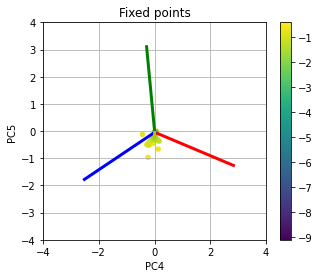

In [ ]:
# 2D Visualization of the approximate fixed points: the line attractor.

pc1 = 4
pc2 = 5

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
# pca_fps = pca.transform(np.vstack(hs_grid_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.grid()

plt.colorbar()

# pca_word = 1*word_deflection('kinda0', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 1*word_deflection('kinda1', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(readout.shape[0]):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
# plt.plot(pca_h0[pc1], pca_h0[pc2], '*', color='k', ms=18)
plt.title('Fixed points')


plt_lim = 4
if plt_lim != None:
  plt.xlim(-plt_lim, plt_lim)
  plt.ylim(-plt_lim, plt_lim)
plt.xlabel('PC'+str(pc1))
plt.ylabel('PC'+str(pc2))

x 1.0
y 1.0
x.y 7.4505806e-08


Text(0, 0.5, 'RO vec space2')

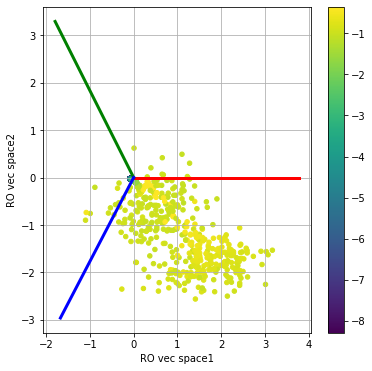

In [ ]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

if rnn_specs['arch'] in ['enc_dec_atth']:
  h0_x_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), x_basis)
  h0_y_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), y_basis)
else:
  h0_x_val = np.dot(np.matmul(h0, proj), x_basis)
  h0_y_val = np.dot(np.matmul(h0, proj), y_basis)


fps_x_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), x_basis)
fps_y_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), y_basis)
plt.scatter(fps_x_vals, fps_y_vals, s=20, c=np.log10(fp_losses))
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.grid()
plt.colorbar()

ro_colors = ['r', 'g', 'b', 'y', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

# plt.xlim(-7, 7)
# plt.ylim(-7, 7)

### Temporal Analysis

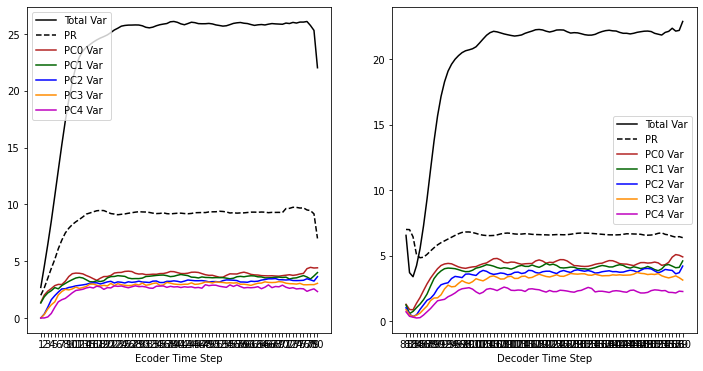

In [49]:
# Plots various variances and the participation ratio of hidden states as a function of time step 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

pc_dims = 5
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

hs_time_word_enc, hs_time_word_dec = analysis.sort_hs_by_time_and_word(hs, hs_data, toy_params)

time_var = np.zeros((hs['all'][0].shape[0]))
time_pr = np.zeros((hs['all'][0].shape[0]))
time_pc_var = np.zeros((hs['all'][0].shape[0], pc_dims))

for time_idx in range(hs['all'][0].shape[0]):
  time_hs = []
  if time_idx < enc_len: # Encoder
    for word_list in hs_time_word_enc[time_idx]:
      time_hs.extend(word_list)
  else:
    for word_list in hs_time_word_dec[time_idx-enc_len]:
      time_hs.extend(word_list)
    
  time_hs = np.array(time_hs)
  pca_time = PCA(n_components=np.min([time_hs.shape[0], rnn_specs['hidden_size']]))
  _ = pca_time.fit_transform(time_hs)
  time_var[time_idx] = np.sum(pca_time.explained_variance_)
  time_pr[time_idx] = analysis.participation_ratio_vector(pca_time.explained_variance_)
  time_pc_var[time_idx] = pca_time.explained_variance_[:pc_dims]

enc_times = [i+1 for i in range(enc_len)]
dec_times = [i+1+enc_len for i in range(dec_len)]
ax1.plot(enc_times, time_var[:enc_len], color='k', label='Total Var')
ax1.plot(enc_times, time_pr[:enc_len], color='k', linestyle='dashed', label='PR')
ax2.plot(dec_times, time_var[enc_len:], color='k', label='Total Var')
ax2.plot(dec_times, time_pr[enc_len:], color='k', linestyle='dashed', label='PR')
for i in range(pc_dims):
  ax1.plot(enc_times, time_pc_var[:enc_len, i], color=state_colors[i], label=f'PC{i} Var')
  ax2.plot(dec_times, time_pc_var[enc_len:, i], color=state_colors[i], label=f'PC{i} Var')

ax1.set_xlabel('Ecoder Time Step')
ax2.set_xlabel('Decoder Time Step')
ax1.set_xticks(enc_times)
ax2.set_xticks(dec_times)

ax1.legend()
ax2.legend()

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:454: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:454: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:454: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:454: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


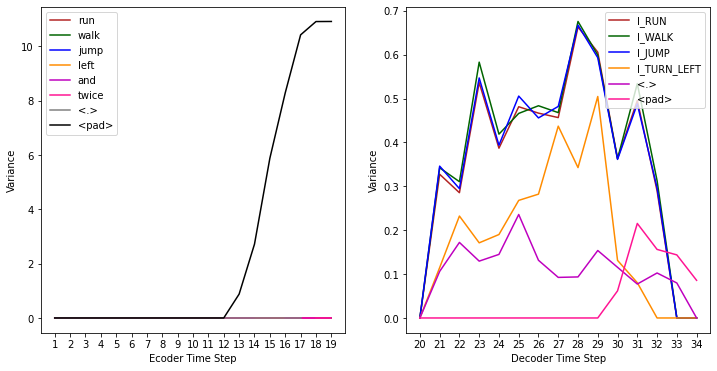

In [ ]:
# Plots variances of hidden states corresponding to individual inputs/ouput words as a function of time step 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

words = np.max([len(toy_params['in_words']), len(toy_params['out_words'])])
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
all_hs_array = np.asarray(hs['all'])

word_var = np.zeros((hs['all'][0].shape[0], words))

for time_idx in range(enc_len):
  for inp_idx in range(len(toy_params['in_words_pp'])):
    time_hs = np.asarray([h for h, inp in zip(all_hs_array[:, time_idx, :], hs_data['inputs'][:, time_idx, :]) if np.argmax(inp) == inp_idx]) 
    pca_time = PCA(n_components=np.min([time_hs.shape[0], rnn_specs['hidden_size']]))
    if time_hs.shape[0] > 0: # Sometimes it is not possible for words to appear at a certain input position
      _ = pca_time.fit_transform(time_hs)
      word_var[time_idx, inp_idx] = np.sum(pca_time.explained_variance_)
for time_idx in range(enc_len, enc_len+dec_len):
  for out_idx in range(len(toy_params['out_words_pp'])):
    time_hs = np.asarray([h for h, out in zip(all_hs_array[:, time_idx, :], hs_data['labels'][:, time_idx - enc_len, :]) if np.argmax(out) == out_idx]) 
    pca_time = PCA(n_components=np.min([time_hs.shape[0], rnn_specs['hidden_size']]))
    if time_hs.shape[0] > 0: # Sometimes it is not possible for words to appear at a certain output position
      _ = pca_time.fit_transform(time_hs)
      word_var[time_idx, out_idx] = np.sum(pca_time.explained_variance_)

enc_times = [i+1 for i in range(enc_len)]
dec_times = [i+1+enc_len for i in range(dec_len)]
for inp_idx in range(len(toy_params['in_words_pp'])):
  ax1.plot(enc_times, word_var[:enc_len, inp_idx], color=state_colors[inp_idx], label=toy_params['in_words_pp'][inp_idx])
for out_idx in range(len(toy_params['out_words_pp'])):
  ax2.plot(dec_times, word_var[enc_len:, out_idx], color=state_colors[out_idx], label=toy_params['out_words_pp'][out_idx])

ax1.set_xlabel('Ecoder Time Step')
ax2.set_xlabel('Decoder Time Step')
ax1.set_ylabel('Variance')
ax2.set_ylabel('Variance')
ax1.set_xticks(enc_times)
ax2.set_xticks(dec_times)

ax1.legend()
ax2.legend()

In [ ]:
# Gets word frequencies

in_word_count = np.zeros((len(toy_params['in_words_pp'])))
out_word_count = np.zeros((len(toy_params['out_words_pp'])))

for in_idx, out_idx, input, label in zip(hs_data['in_index'], hs_data['out_index'], hs_data['inputs'], hs_data['labels']):
  in_word_count += np.sum(input[:in_idx+1], axis=0)[:len(toy_params['in_words_pp'])]
  out_word_count += np.sum(label[:out_idx+1], axis=0)[:len(toy_params['out_words_pp'])]

print('In word count:', in_word_count)
print('Out word count:', out_word_count)

In word count: [1845. 1786. 1785. 1813. 2564. 1851. 2852. 1000.]
Out word count: [2438. 2423. 2406. 1813. 2852. 1000.]


Finding average hidden state at each time step...
Finding average hidden state at each time step...


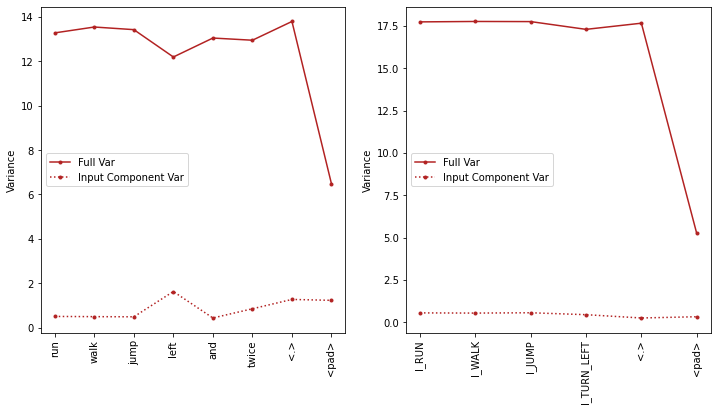

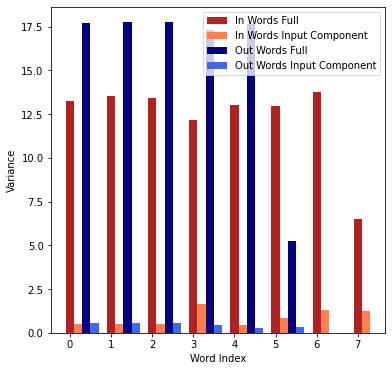

In [ ]:
# Plots variance of words before and after temporal subtraction

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

hs_time_word_enc, hs_time_word_dec = sort_hs_by_time_and_word(hs, hs_data, toy_params)
hs_time_word_enc_ic, hs_time_word_dec_ic = sort_hs_by_time_and_word(hs, hs_data, toy_params, subtract_avg=True)
avg_hs = find_avg_hs(hs, hs_data, toy_params)

word_var_enc = np.zeros((len(toy_params['in_words_pp'])))
word_var_enc_ic = np.zeros((len(toy_params['in_words_pp'])))
word_var_dec = np.zeros((len(toy_params['out_words_pp'])))
word_var_dec_ic = np.zeros((len(toy_params['out_words_pp'])))

for word_idx in range(len(toy_params['in_words_pp'])):
  word_hs = []
  word_hs_ic = []
  for time_idx in range(enc_len):
    word_hs.extend(hs_time_word_enc[time_idx][word_idx])
    word_hs_ic.extend(hs_time_word_enc_ic[time_idx][word_idx])

  word_hs = np.array(word_hs) 
  word_var_enc[word_idx] = np.trace(np.cov(word_hs.T))
  # print('Trace variance:', np.trace(np.cov(word_hs.T)))
  # print(word_hs.shape)
  # print('Norm variance:', np.mean(np.linalg.norm(word_hs.T - np.mean(word_hs.T, axis=1)[:,np.newaxis], axis=0)**2))

  word_hs_ic = np.array(word_hs_ic) 
  word_var_enc_ic[word_idx] = np.trace(np.cov(word_hs_ic.T))

for word_idx in range(len(toy_params['out_words_pp'])):
  word_hs = []
  word_hs_ic = []
  for time_idx in range(dec_len):
    word_hs.extend(hs_time_word_dec[time_idx][word_idx])
    word_hs_ic.extend(hs_time_word_dec_ic[time_idx][word_idx])

  word_hs = np.array(word_hs) 
  word_var_dec[word_idx] = np.trace(np.cov(word_hs.T))

  word_hs_ic = np.array(word_hs_ic) 
  word_var_dec_ic[word_idx] = np.trace(np.cov(word_hs_ic.T))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig, ax3 = plt.subplots(1, 1, figsize=(6,6))

ax1.plot([i for i in range(len(toy_params['in_words_pp']))], word_var_enc, marker='.', color='firebrick',  label='Full Var')
ax1.plot([i for i in range(len(toy_params['in_words_pp']))], word_var_enc_ic, marker='.', color='firebrick', linestyle='dotted', label='Input Component Var')
ax1.set_ylabel('Variance')
ax1.set_xticks([i for i in range(len(toy_params['in_words_pp']))])
ax1.set_xticklabels(toy_params['in_words_pp'], rotation=90)
ax1.legend()

ax2.plot([i for i in range(len(toy_params['out_words_pp']))], word_var_dec, marker='.', color='firebrick',  label='Full Var')
ax2.plot([i for i in range(len(toy_params['out_words_pp']))], word_var_dec_ic, marker='.', color='firebrick', linestyle='dotted', label='Input Component Var')
ax2.set_ylabel('Variance')
ax2.set_xticks([i for i in range(len(toy_params['out_words_pp']))])
ax2.set_xticklabels(toy_params['out_words_pp'], rotation=90)
ax2.legend()

ax3.bar([i for i in range(len(toy_params['in_words_pp']))], word_var_enc, width=0.2, color='firebrick',  label='In Words Full')
ax3.bar([i+0.2 for i in range(len(toy_params['in_words_pp']))], word_var_enc_ic, width=0.2, color='coral', linestyle='dotted', label='In Words Input Component')
ax3.bar([i+0.4 for i in range(len(toy_params['out_words_pp']))], word_var_dec, width=0.2, color='navy',  label='Out Words Full')
ax3.bar([i+0.6 for i in range(len(toy_params['out_words_pp']))], word_var_dec_ic, width=0.2, color='royalblue', linestyle='dotted', label='Out Words Input Component')
ax3.set_ylabel('Variance')
ax3.set_xlabel('Word Index')
ax3.legend()

Finding average hidden state at each time step...
Finding average hidden state at each time step...


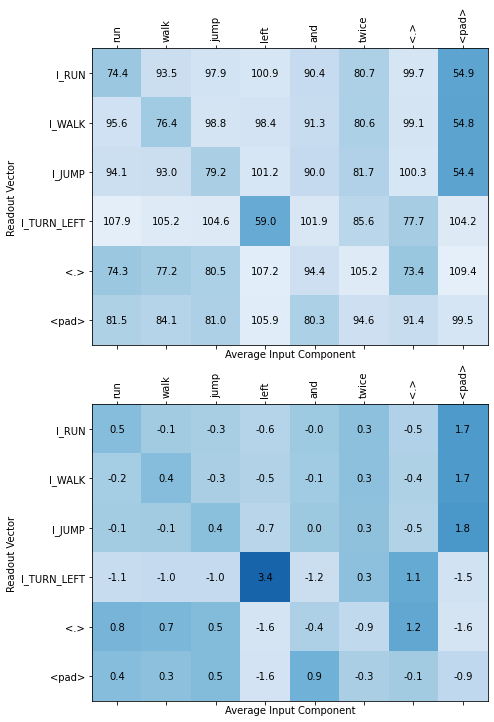

In [65]:
# Plots alignments between readout vectors and average states

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

hs_time_word_enc_ic, hs_time_word_dec_ic = analysis.sort_hs_by_time_and_word(hs, hs_data, toy_params, subtract_avg=False)
# hs_time_word_enc_ic, hs_time_word_dec_ic = sort_hs_by_time_and_word(hs, hs_data, toy_params, subtract_avg=False)
avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

ic_enc, ic_dec = analysis.calculate_input_componets(hs, hs_data, toy_params, rnn_specs)

readout_avg_aligns = np.zeros((readout.shape[0], len(toy_params['in_words_pp'])))
readout_avg_dots = np.zeros((readout.shape[0], len(toy_params['in_words_pp'])))

for ro_idx in range(readout.shape[0]):
  for word_idx in range(len(toy_params['in_words_pp'])):
    readout_avg_aligns[ro_idx, word_idx] = analysis.angle_degrees(readout[ro_idx], ic_enc[word_idx])
    readout_avg_dots[ro_idx, word_idx] = np.dot(readout[ro_idx], ic_enc[word_idx])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,12))

ax1.matshow(readout_avg_aligns, cmap=plt.cm.Blues_r, vmin= 0, vmax=120)
ax2.matshow(readout_avg_dots, cmap=plt.cm.Blues, vmin= -3, vmax=5)

for i in range(readout_avg_aligns.shape[1]):
  for j in range(readout_avg_aligns.shape[0]):
    c = readout_avg_aligns[j,i]
    ax1.text(i, j, str(round(c, 1)), va='center', ha='center')
    c = readout_avg_dots[j,i]
    ax2.text(i, j, str(round(c, 1)), va='center', ha='center')

for ax in (ax1, ax2):
  ax.set_xticks([i for i in range(len(toy_params['in_words_pp']))])
  ax.set_xticklabels(toy_params['in_words_pp'], rotation=90)
  ax.set_yticks([i for i in range(len(toy_params['out_words_pp']))])
  ax.set_yticklabels(toy_params['out_words_pp'], rotation=0)
  ax.set_ylabel('Readout Vector')
  ax.set_xlabel('Average Input Component')

In [ ]:


max_score = (words - 1) * np.sum([words**i for i in range(enc_length)])
print('Max score', max_score)
words = len(toy_params['in_words_pp']) - 1
print(get_color_score(hs_data['inputs'][0][:enc_length], words))

Max score 242
56


Max score 80


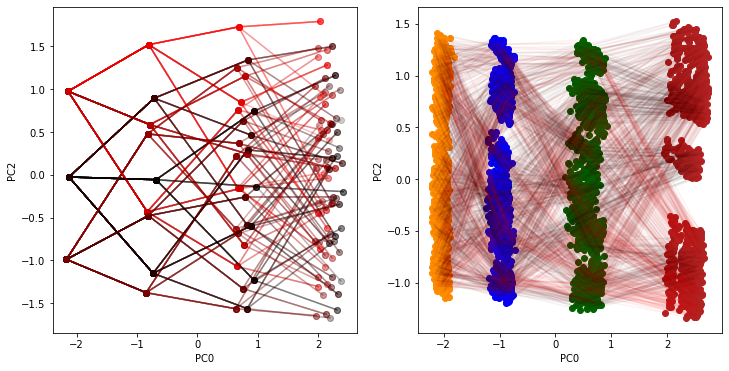

In [ ]:
# Plots hidden states up to a given index

def get_color_score(input_tensor, words):
  c_score = 0
  for time_tensor, idx in zip(input_tensor, range(input_tensor.shape[0])):
    c_score += words**(enc_length - idx - 1) * np.argmax(time_tensor)
  return c_score

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

pc0 = 0
pc1 = 2

pc_dims = 5
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

hs_time_word_enc, hs_time_word_dec = sort_hs_by_time_and_word(hs, hs_data, toy_params)

enc_length = 4
dec_length = 4

max_score = (words - 1) * np.sum([words**i for i in range(enc_length)])
print('Max score', max_score)
words = len(toy_params['in_words_pp']) - 1


enc_hs_time = [[] for _ in range(enc_length)]
dec_hs_time = [[] for _ in range(enc_length)]

for time_idx in range(enc_length):
  time_hs = []
  for word_idx in range(len(toy_params['in_words_pp'])):
    time_hs.extend(hs_time_word_enc[time_idx][word_idx])
  enc_hs_time[time_idx] = time_hs
for time_idx in range(dec_length):
  time_hs = []
  for word_idx in range(len(toy_params['out_words_pp'])):
    time_hs.extend(hs_time_word_dec[time_idx][word_idx])
  dec_hs_time[time_idx] = time_hs

# Plots encoder hidden states
pca_enc = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_enc.fit(np.vstack(enc_hs_time))
# for time_idx in range(enc_length):
#   pca_time_hs = pca_enc.transform(enc_hs_time[time_idx]).T
#   ax1.scatter(pca_time_hs[pc0], pca_time_hs[pc1], color=state_colors[time_idx])
# Plots all paths
for h, inp in zip(hs['all'], hs_data['inputs']):
  pca_path = pca_enc.transform(h).T
  c_score = get_color_score(inp[:enc_length], words)
  ax1.plot(pca_path[pc0, :enc_length], pca_path[pc1, :enc_length], color=[(max_score-c_score)/max_score,0,0], alpha=0.05, marker='o')

# Plots decoder hidden states
pca_dec = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_dec.fit(np.vstack(dec_hs_time))
for time_idx in range(dec_length):
  pca_time_hs = pca_dec.transform(dec_hs_time[time_idx]).T
  ax2.scatter(pca_time_hs[pc0], pca_time_hs[pc1], color=state_colors[time_idx])
# Plots all paths
for h, lab in zip(hs['all'], hs_data['labels']):
  pca_path = pca_dec.transform(h).T
  c_score = get_color_score(lab[:dec_length], words)
  ax2.plot(pca_path[pc0, enc_len:enc_len+dec_length], pca_path[pc1, enc_len:enc_len+dec_length], 
           color=[(max_score-c_score)/max_score,0,0], alpha=0.05)

for ax in (ax1, ax2):
  ax.set_xlabel('PC'+str(pc0))
  ax.set_ylabel('PC'+str(pc1))

#### Time Averaging

Finding average hidden state at each time step...
Encoder magnitude ratio: 25.183778785014784
Decoder magnitude ratio: 54.79439179004082
Attention matrix \ Max: 0.8955501425528949 \ Min: 1.190143314152927e-12
Attention null \ Max: 0.9254699349403381 \ Min: 3.424990597123562e-14
Var ex ratios: [0.32999271 0.13345246 0.12623315 0.09388311 0.07334552]
PR: 3.6529783136832705


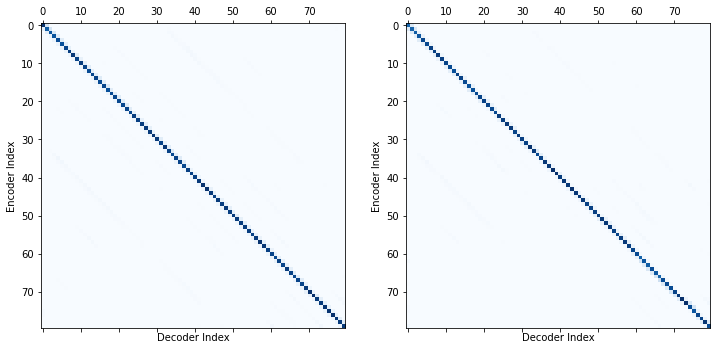

In [15]:
# Checks to see if attention matrix can be explained by average of hidden states at a given time step
from scipy.special import softmax

avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)
hs_inputs = np.asarray([h - avg_hs for h in hs['all']])

print('Encoder magnitude ratio:', np.mean(np.linalg.norm(avg_hs[:enc_len]))/np.mean(np.linalg.norm(hs_inputs[:, :enc_len, :], axis=2)))
print('Decoder magnitude ratio:', np.mean(np.linalg.norm(avg_hs[enc_len:]))/np.mean(np.linalg.norm(hs_inputs[:, enc_len:, :], axis=2)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

# Attention matrix from mean input states
attn_matrix = np.zeros((enc_len, dec_len))
enc_seq = avg_hs[:enc_len, :]
for seq_idx in range(dec_len):
  attn_matrix[:, seq_idx] = softmax(np.dot(enc_seq, avg_hs[enc_len + seq_idx, :]))

# Attention matrix from null input
attn_matrix_null = np.zeros((enc_len, dec_len))
enc_seq = hs['special'][-1][:enc_len, :]
for seq_idx in range(dec_len):
  attn_matrix_null[:, seq_idx] = softmax(np.dot(enc_seq, hs['special'][-1][enc_len + seq_idx, :]))

print(f'Attention matrix \\ Max: {np.max(attn_matrix)} \\ Min: {np.min(attn_matrix)}')
ax1.matshow(attn_matrix, cmap=plt.cm.Blues)
ax1.set_ylabel('Encoder Index')
ax1.set_xlabel('Decoder Index')

print(f'Attention null \\ Max: {np.max(attn_matrix_null)} \\ Min: {np.min(attn_matrix_null)}')
ax2.matshow(attn_matrix_null, cmap=plt.cm.Blues)
ax2.set_ylabel('Encoder Index')
ax2.set_xlabel('Decoder Index')

# pca_avg = PCA(n_components=np.min([avg_hs.shape[0], rnn_specs['hidden_size']]))
pca_avg = PCA(n_components=5)
_ = pca_avg.fit_transform(avg_hs[:]).T
pca_avg_hs = pca_avg.transform(avg_hs).T
pca_avg_input = pca_avg.transform(hs['special'][-1]).T
print('Var ex ratios:', pca_avg.explained_variance_ratio_[:5])
print('PR:', analysis.participation_ratio_vector(pca_avg.explained_variance_))

In [17]:
# Calculates average hidden state and subtracts it out from hidden states at all time steps to isolate word subspace
# Average hidden state does NOT include repeated <pad>'s for encoder or decoder

avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

print('Using true average hidden state as temporal part')
temporal_hs = avg_hs
# print('Using null input hidden state as temporal part')
# temporal_hs = hs['special'][-1]
if toy_params['var_length']:
  pad_in_idx = toy_params['in_words_pp'].index('<pad>')
  pad_out_idx = toy_params['out_words_pp'].index('<pad>')
# Removes average hidden state from all hidden states
hs_mod_pos_enc = [h - temporal_hs for h in hs['all']]

hs_inputs_bare, hs_outputs_bare = analysis.sort_hs_by_time_and_word(hs, hs_data, toy_params)
hs_inputs, hs_outputs = analysis.sort_hs_by_time_and_word(hs, hs_data, toy_params, subtract_avg=True, avg_hs=avg_hs)

Finding average hidden state at each time step...
Using true average hidden state as temporal part
Finding average hidden state at each time step...


Var ex ratios: [0.32999271 0.13345246 0.12623315 0.09388311 0.07334552]
PR: 6.016397537126445


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


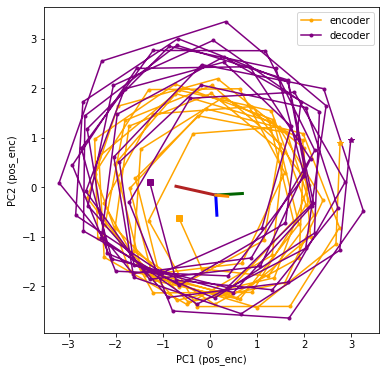

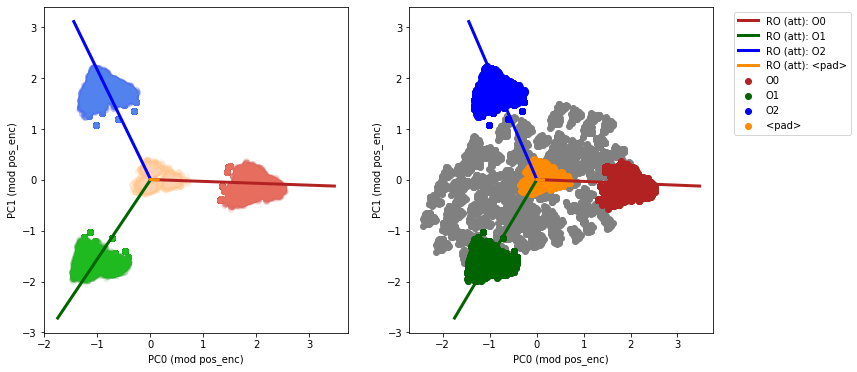

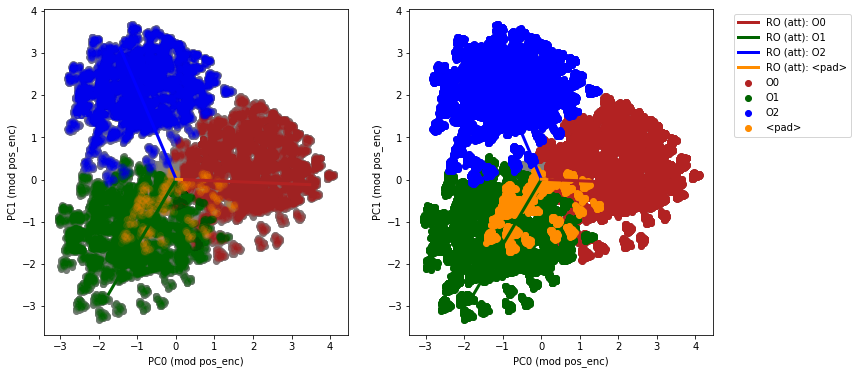

In [24]:
# Plots decomposition of hidden states into temporal and word spaces
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))
fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(12, 6))
fig3, (ax4, ax5) = plt.subplots(1, 2, figsize=(12, 6))

##### Plotting for temporal part #####

pts_subset = 'all'

pc1 = 1
pc2 = 2

# pca_avg = PCA(n_components=5)
if pts_subset == 'enc': # Fits PCA to only enecoder hidden states
  pca_avg = PCA(n_components=np.min([temporal_hs[:enc_len].shape[0], rnn_specs['hidden_size']]))
  _ = pca_avg.fit(temporal_hs[:enc_len])
  pca_avg_hs = pca_avg.transform(temporal_hs).T
elif pts_subset == 'all':
  pca_avg = PCA(n_components=np.min([temporal_hs.shape[0], rnn_specs['hidden_size']]))
  pca_avg_hs = pca_avg.fit_transform(temporal_hs).T
pca_mod_pe_hs = pca_avg.transform(np.vstack(hs_mod_pos_enc)).T
pca_avg_input = pca_avg.transform(hs['special'][-2]).T
pca_null_input = pca_avg.transform(hs['special'][-1]).T
print('Var ex ratios:', pca_avg.explained_variance_ratio_[:5])
print('PR:', analysis.participation_ratio_vector(pca_avg.explained_variance_))

ax1.plot(pca_avg_hs[pc1,:enc_len], pca_avg_hs[pc2,:enc_len], marker='.', color='orange', label='encoder')
ax1.plot(pca_avg_hs[pc1,enc_len:], pca_avg_hs[pc2,enc_len:], marker='.', color='purple', label='decoder')
# Squares at start of each
ax1.plot(pca_avg_hs[pc1,0], pca_avg_hs[pc2,0], marker='s', color='orange')
ax1.plot(pca_avg_hs[pc1,enc_len], pca_avg_hs[pc2,enc_len], marker='s', color='purple')
# Stars at the end
ax1.plot(pca_avg_hs[pc1,enc_len-1], pca_avg_hs[pc2,enc_len-1], marker='*', color='orange')
ax1.plot(pca_avg_hs[pc1,-1], pca_avg_hs[pc2,-1], marker='*', color='purple')

# ax1.plot(pca_avg_input[pc1,:enc_len], pca_avg_input[pc2,:enc_len], color='orange', linestyle='dashed', label='encoder (avg inp)')
# ax1.plot(pca_avg_input[pc1,enc_len:], pca_avg_input[pc2,enc_len:], color='purple', linestyle='dashed', label='decoder (avg inp)')
# ax1.plot(pca_null_input[pc1,:enc_len], pca_null_input[pc2,:enc_len], color='red', linestyle='dashed', label='encoder (zero inp)')
# ax1.plot(pca_null_input[pc1,enc_len:], pca_null_input[pc2,enc_len:], color='green', linestyle='dashed', label='decoder (zero inp)')
ax1.legend()

ax1.set_xlabel('PC'+str(pc1)+' (pos_enc)')
ax1.set_ylabel('PC'+str(pc2)+' (pos_enc)')

# Plots readout direction
readout_types = ['att']  #'att', 'hs', 'sum'] # 'att' or 'hs'
ro_color_idxs = [0, 1, 2, 3, 6, 7]
ro_styles = ['solid', 'dotted', 'dashed']
for idx in range(len(readout_types)):
  if readout_types[idx] == 'att':
    readout_plot = readout 
    # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
  elif readout_types[idx] == 'hs':
    readout_plot = readout_dec
    # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
  elif readout_types[idx] == 'sum':
    readout_plot = readout + readout_dec
  pca_ro = pca_avg.transform(readout_plot)
  pca_zero = pca_avg.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
  # pca_zero = pca_avg.transform(np.atleast_2d(np.zeros((2*rnn_specs['hidden_size'],)))).T

  for i in range(readout_plot.shape[0]):
    x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
    y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
    ax1.plot(x_ro, y_ro, color=state_colors[ro_color_idxs[i]], linewidth = 3, linestyle=ro_styles[idx],
              label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

##### Plotting for word part #####

pts_subset = 'enc'

pc1 = 0
pc2 = 1

alpha_s = 0.05

pca_mod_pe = PCA(n_components=rnn_specs['hidden_size'])
if pts_subset == 'enc': # Fits PCA to only enecoder hidden states
  _ = pca_mod_pe.fit(np.vstack(np.asarray(hs_mod_pos_enc)[:,:enc_len,:]))
  pca_mod_pe_hs = pca_mod_pe.transform(np.vstack(hs_mod_pos_enc)).T
elif pts_subset == 'all':
  pca_mod_pe_hs = pca_mod_pe.fit_transform(np.vstack(hs_mod_pos_enc)).T
pca_hs = pca_mod_pe.transform(np.vstack(hs['all'])).T
# ax2.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')
ax4.scatter(pca_hs[pc1], pca_hs[pc2], color='grey')
for inp_idx in range(len(toy_params['in_words_pp'])):
  hs_word = []
  hs_word_bare = []
  for time_idx in range(enc_len):
    hs_word.extend(hs_inputs[time_idx][inp_idx])
    hs_word_bare.extend(hs_inputs_bare[time_idx][inp_idx])
  hs_word = np.array(hs_word)
  hs_word_bare = np.array(hs_word_bare)
  pca_mod_pe_word = pca_mod_pe.transform(hs_word).T
  ax2.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[inp_idx], alpha=alpha_s,
              label=toy_params['in_words'][inp_idx])
  pca_word = pca_mod_pe.transform(hs_word_bare).T
  ax4.scatter(pca_word[pc1], pca_word[pc2], color=state_colors[inp_idx], alpha=alpha_s,
              label=toy_params['in_words'][inp_idx])
for out_idx in range(len(toy_params['out_words_pp'])):
  hs_word = []
  for time_idx in range(dec_len):
    hs_word.extend(hs_inputs[time_idx][out_idx])
  hs_word = np.array(hs_word)
  pca_mod_pe_word = pca_mod_pe.transform(hs_word).T
  ax2.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors_light[out_idx], alpha=alpha_s)


ax3.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')
ax5.scatter(pca_hs[pc1], pca_hs[pc2], color='grey')
for out_idx in range(len(toy_params['out_words_pp'])):
  hs_word = []
  hs_word_bare = []
  for time_idx in range(dec_len):
    hs_word.extend(hs_inputs[time_idx][out_idx])
    hs_word_bare.extend(hs_inputs_bare[time_idx][out_idx])
  hs_word = np.array(hs_word)
  hs_word_bare = np.array(hs_word_bare)
  pca_mod_pe_word = pca_mod_pe.transform(hs_word).T
  ax3.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[out_idx], label=toy_params['out_words'][out_idx])
  pca_word = pca_mod_pe.transform(hs_word_bare).T
  ax5.scatter(pca_word[pc1], pca_word[pc2], color=state_colors[out_idx], label=toy_params['out_words'][out_idx])

# Average directions of hidden states for encoder/decoder (used to project readouts)
avg_enc = np.mean(temporal_hs[:enc_len], axis=0)
avg_dec = np.mean(temporal_hs[enc_len:], axis=0)
avg_enc_dir = avg_enc/(np.linalg.norm(avg_enc))
avg_dec_dir = avg_dec/(np.linalg.norm(avg_dec))

# Plots readout direction
readout_types = ['att']  #'att', 'hs', 'sum'] # 'att' or 'hs'
ro_styles = ['solid', 'dotted', 'dashed']
for idx in range(len(readout_types)):
  if readout_types[idx] == 'att':
    readout_plot = readout 
    # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
  elif readout_types[idx] == 'hs':
    readout_plot = readout_dec
    # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
  elif readout_types[idx] == 'sum':
    readout_plot = readout + readout_dec
  pca_ro = pca_mod_pe.transform(readout_plot)
  pca_zero = pca_mod_pe.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
  # pca_zero = pca_mod_pe.transform(np.atleast_2d(np.zeros((2*rnn_specs['hidden_size'],)))).T
  for i in range(readout_plot.shape[0]):
    x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
    y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
    for ax in [ax2, ax3, ax4, ax5]:
      ax.plot(x_ro, y_ro, color=state_colors[ro_color_idxs[i]], linewidth = 3, linestyle=ro_styles[idx],
              label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

# ax2.legend()
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for ax in [ax2, ax3, ax4, ax5]:
  ax.set_xlabel('PC'+str(pc1)+' (mod pos_enc)')
  ax.set_ylabel('PC'+str(pc2)+' (mod pos_enc)')

for ax in [ax1, ax2]:
  plt_lim = None
  if plt_lim != None:
    ax.xlim(-plt_lim, plt_lim)
    ax.ylim(-plt_lim, plt_lim)

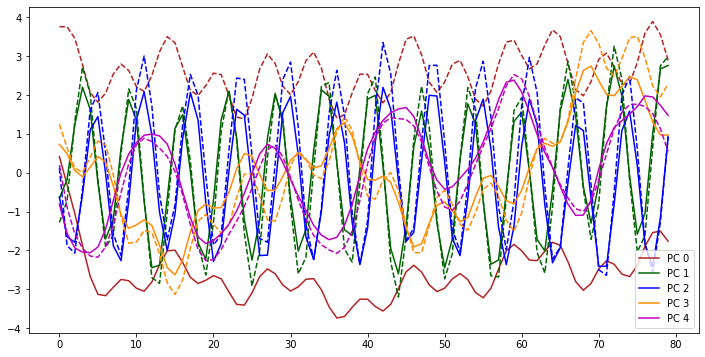

In [23]:
pcs = 5
fig, ax1 = plt.subplots(1,1, figsize=(12,6))

for pc_idx in range(pcs):
  # ax1.plot(pca_null_input[pc_idx,:enc_len], color=state_colors[pc_idx], linestyle='solid', label='PC '+str(pc_idx))
  # ax1.plot(pca_null_input[pc_idx,enc_len:],  color=state_colors[pc_idx], linestyle='dashed')
  ax1.plot(pca_avg_hs[pc_idx,:enc_len], color=state_colors[pc_idx], linestyle='solid', label='PC '+str(pc_idx))
  ax1.plot(pca_avg_hs[pc_idx,enc_len:],  color=state_colors[pc_idx], linestyle='dashed')


ax1.legend()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


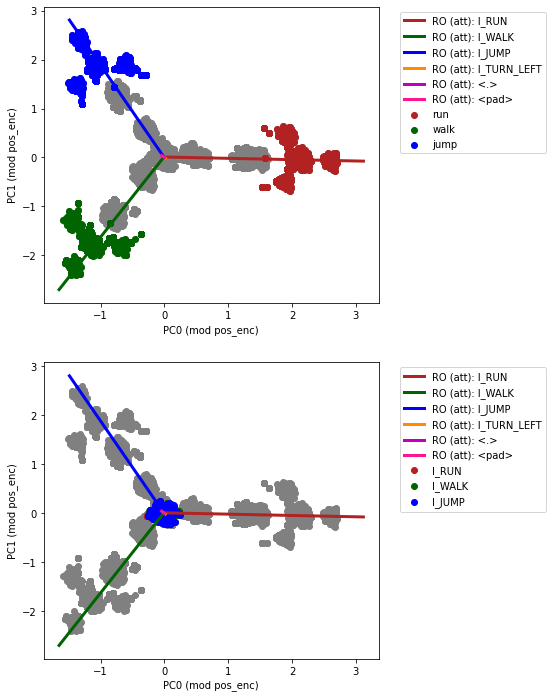

In [ ]:
# Plot using a more specific PCA

fig2, (ax2, ax3) = plt.subplots(2, 1, figsize=(6, 12))

words_in_pca = ['run', 'walk', 'jump']
words_in_pca_idxs = [toy_params['in_words_pp'].index(word) for word in words_in_pca]
pca_list = []
for inp_idx in words_in_pca_idxs:
  pca_list = pca_list + hs_inputs[inp_idx]

pca_mod_pe = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_mod_pe.fit(np.vstack(np.asarray(pca_list)))
pca_mod_pe_hs = pca_mod_pe.transform(np.vstack(hs_mod_pos_enc)).T

ax2.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')
# for inp_idx in range(len(toy_params['in_words_pp'])):
for inp_idx in words_in_pca_idxs:
  pca_mod_pe_word = pca_mod_pe.transform(np.vstack(hs_inputs[inp_idx])).T
  ax2.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[inp_idx], label=toy_params['in_words'][inp_idx])

ax3.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')
# for out_idx in range(len(toy_params['out_words_pp'])):
for out_idx in words_in_pca_idxs:
  pca_mod_pe_word = pca_mod_pe.transform(np.vstack(hs_outputs[out_idx])).T
  ax3.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[out_idx], label=toy_params['out_words'][out_idx])

# Plots readout direction
readout_types = ['att']  #'att', 'hs', 'sum'] # 'att' or 'hs'
ro_styles = ['solid', 'dotted', 'dashed']
for idx in range(len(readout_types)):
  if readout_types[idx] == 'att':
    readout_plot = readout 
    # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
  elif readout_types[idx] == 'hs':
    readout_plot = readout_dec
    # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
  elif readout_types[idx] == 'sum':
    readout_plot = readout + readout_dec
  pca_ro = pca_mod_pe.transform(readout_plot)
  pca_zero = pca_mod_pe.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
  for i in range(readout_plot.shape[0]):
    x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
    y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
    for ax in [ax2, ax3, ax4, ax5]:
      ax.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, linestyle=ro_styles[idx],
              label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for ax in [ax2, ax3]:
  ax.set_xlabel('PC'+str(pc1)+' (mod pos_enc)')
  ax.set_ylabel('PC'+str(pc2)+' (mod pos_enc)')

Using true average hidden state as temporal part


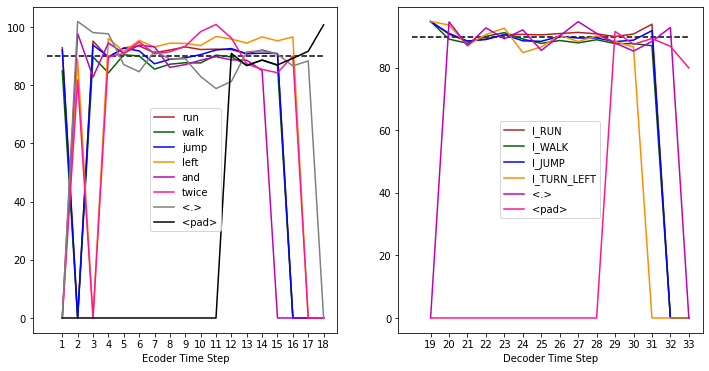

In [ ]:

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

print('Using true average hidden state as temporal part')
temporal_hs = avg_hs
# print('Using null input hidden state as temporal part')
# temporal_hs = hs['special'][-1]

pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>')

avg_angle_enc = np.zeros((len(toy_params['in_words_pp']), enc_len))
avg_angle_dec = np.zeros((len(toy_params['out_words_pp']), dec_len))

for time_idx in range(enc_len): # Encoder
  time_hs_word = [[] for _ in range(len(toy_params['in_words_pp']))]
  for h, inp in zip(hs['all'], hs_data['inputs']):
    if time_idx > 0:
      if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
        time_hs_word[np.argmax(inp[time_idx])].append(h[time_idx])
    else: # Automatically adds if first index
      time_hs_word[np.argmax(inp[time_idx])].append(h[time_idx])
  for word_idx in range(len(time_hs_word)):
    if len(time_hs_word[word_idx]) > 0:
      time_word_array = np.asarray(time_hs_word[word_idx])
      angles = np.asarray([angle_degrees(hid - temporal_hs[time_idx], temporal_hs[time_idx]) for hid in time_word_array])
      # angles = np.asarray([proj_perc(hid - temporal_hs[time_idx], temporal_hs[time_idx]) for hid in time_word_array])
      avg_angle_enc[word_idx, time_idx] = np.mean(angles, axis=0)
for time_idx in range(dec_len): # Decoder
  time_hs_word = [[] for _ in range(len(toy_params['out_words_pp']))]
  for h, out in zip(hs['all'], hs_data['labels']):
    if time_idx > 0:
      if np.argmax(out[time_idx]) != pad_out_idx or np.argmax(out[time_idx-1]) != pad_out_idx:
        time_hs_word[np.argmax(out[time_idx])].append(h[enc_len + time_idx])
    else: # Automatically adds if first index
      time_hs_word[np.argmax(out[time_idx])].append(h[enc_len + time_idx])
  for word_idx in range(len(time_hs_word)):
    if len(time_hs_word[word_idx]) > 0:
      time_word_array = np.asarray(time_hs_word[word_idx])
      # if (time_word_array == temporal_hs[enc_len + time_idx]).any():
      #   raise ValueError('Output is same as null')
      angles = np.asarray([angle_degrees(hid - temporal_hs[enc_len + time_idx], temporal_hs[enc_len + time_idx]) for hid in time_word_array])
      # angles = np.asarray([proj_perc(hid - temporal_hs[enc_len + time_idx], temporal_hs[enc_len + time_idx]) for hid in time_word_array])
      avg_angle_dec[word_idx, time_idx] = np.mean(angles, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
enc_times = [i+1 for i in range(enc_len)]
dec_times = [i+1+enc_len for i in range(dec_len)]
for word_idx in range(len(toy_params['in_words_pp'])):
  ax1.plot(enc_times, avg_angle_enc[word_idx], color=state_colors[word_idx], label=toy_params['in_words_pp'][word_idx])
for word_idx in range(len(toy_params['out_words_pp'])):
  ax2.plot(dec_times, avg_angle_dec[word_idx], color=state_colors[word_idx], label=toy_params['out_words_pp'][word_idx])

ax1.hlines(90.0, 0, enc_len, color='k', linestyle='dashed')
ax2.hlines(90.0, enc_len, enc_len+dec_len, color='k', linestyle='dashed')
ax1.set_xlabel('Ecoder Time Step')
ax2.set_xlabel('Decoder Time Step')
ax1.set_xticks(enc_times)
ax2.set_xticks(dec_times)

# ax1.set_ylim([80, 100])
# ax2.set_ylim([80, 100])

ax1.legend()
ax2.legend()

Text(0, 0.5, 'PC1 (pos_enc)')

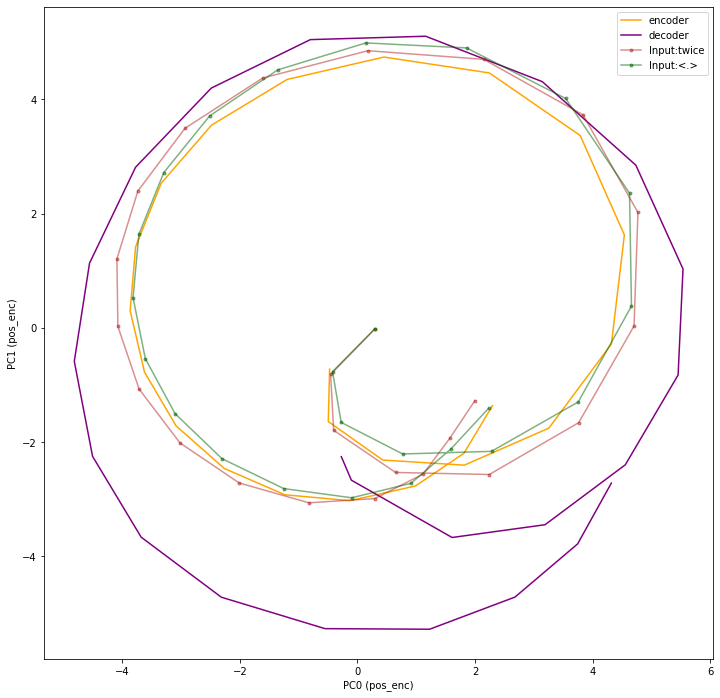

In [ ]:
"Plots some example paths in the temporal subspace

pts_subset = 'enc'

fig1, ax1 = plt.subplots(1, 1, figsize=(12, 12))

pc1 = 0
pc2 = 1

if pts_subset in ['all', 'enc']:
  ax1.plot(pca_avg_hs[pc1,:enc_len], pca_avg_hs[pc2,:enc_len], color='orange', label='encoder')
  # ax1.plot(pca_avg_input[pc1,:enc_len], pca_avg_input[pc2,:enc_len], color='orange', linestyle='dashed', label='encoder (avg inp)')
if pts_subset in ['all', 'dec', 'enc']:
  ax1.plot(pca_avg_hs[pc1,enc_len:], pca_avg_hs[pc2,enc_len:], color='purple', label='decoder')
  # ax1.plot(pca_avg_input[pc1,enc_len:], pca_avg_input[pc2,enc_len:], color='purple', linestyle='dashed', label='decoder (avg inp)')

pca_h0 = pca_avg.transform(np.atleast_2d(h0)).T

hs_idxs = [] # [5, 6, 7] # [0]
for hs_idx in hs_idxs: # Plots example paths
  print('Example phrase length:', hs_data['index'][hs_idx])
  print('Example phrase:', tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  if pts_subset in ['enc', 'all']: # Adds h0 to path
    pca_state = np.concatenate((pca_h0, pca_avg.transform(hs[pts_subset][hs_idx]).T), axis=1) 
  if pts_subset in ['dec', 'all']:  # Puts star on final hidden state
    pca_decf = pca_avg.transform(np.atleast_2d(hs['decf'][hs_idx])).T
    ax1.scatter(pca_decf[pc1], pca_decf[pc2], color = 'k', marker='*', 
                s=100.0, alpha=1.0)
  if pts_subset == 'all':
    ax1.plot(pca_state[pc1][:pl+1], pca_state[pc2][:pl+1], color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=1.0,
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
    ax1.plot(pca_state[pc1][pl:], pca_state[pc2][pl:], color = state_colors_light[hs_idxs.index(hs_idx)], marker=None, alpha=1.0)
  else:
    ax1.plot(pca_state[pc1], pca_state[pc2], color = state_colors[hs_idxs.index(hs_idx)], marker='.', alpha=0.5, 
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
    
# Special inputs
pos_enc_idxs = [3, 4]
for pos_enc_idx in pos_enc_idxs:
  if pts_subset in ['all']: # Adds h0 to path
    pca_state = np.concatenate((pca_h0, pca_avg.transform(hs['pos_enc'][pos_enc_idx]).T), axis=1)
    ax1.plot(pca_state[pc1][:pl+1], pca_state[pc2][:pl+1], color = state_colors[pos_enc_idxs.index(pos_enc_idx)], 
             marker=None, alpha=1.0, label='Input:' + toy_params['in_words'][pos_enc_idx])
    ax1.plot(pca_state[pc1][pl:], pca_state[pc2][pl:], color = state_colors_light[pos_enc_idxs.index(pos_enc_idx)],
             marker=None, alpha=1.0)
  elif pts_subset in ['enc']: # Adds h0 to path
    pca_state = np.concatenate((pca_h0, pca_avg.transform(hs['special'][pos_enc_idx][:enc_len]).T), axis=1)
    ax1.plot(pca_state[pc1], pca_state[pc2], color = state_colors[pos_enc_idxs.index(pos_enc_idx)], marker='.', 
             alpha=0.5, label='Input:' + toy_params['in_words'][pos_enc_idx]) 

ax1.legend()
ax1.set_xlabel('PC'+str(pc1)+' (pos_enc)')
ax1.set_ylabel('PC'+str(pc2)+' (pos_enc)')

In [ ]:
# Analyzing average encoder/decoder hidden states without he time-average
avg_word_vec_enc = np.asarray(list(map(lambda l: np.mean(np.asarray(l), axis=0), hs_inputs)))
avg_word_vec_dec = np.asarray(list(map(lambda l: np.mean(np.asarray(l), axis=0), hs_outputs)))

enc_vec_mags = []
for i in range(avg_word_vec_enc.shape[0]):
  enc_vec_mags.append(np.linalg.norm(avg_word_vec_enc[i]))
  print(f'Encoder vec {i} mag:', enc_vec_mags[i])
dec_vec_mags = []
for i in range(avg_word_vec_dec.shape[0]):
  dec_vec_mags.append(np.linalg.norm(avg_word_vec_dec[i]))
  print(f'Decoder vec {i} mag:', dec_vec_mags[i])

for i in range(avg_word_vec_enc.shape[0]):
  for j in range(i):
    print('Enc Angle ({}, {}):'.format(toy_params['in_words'][i], toy_params['in_words'][j]), 180/np.pi * np.arccos(np.dot(avg_word_vec_enc[i], avg_word_vec_enc[j])/(enc_vec_mags[i]*enc_vec_mags[j])))
for i in range(avg_word_vec_dec.shape[0]):
  for j in range(i):
    print('Dec Angle ({}, {}):'.format(toy_params['out_words'][i], toy_params['out_words'][j]), 180/np.pi * np.arccos(np.dot(avg_word_vec_dec[i], avg_word_vec_dec[j])/(dec_vec_mags[i]*dec_vec_mags[j])))

ro_subspace_analysis(avg_word_vec_enc)
ro_subspace_analysis(avg_word_vec_dec)


Encoder vec 0 mag: 2.480907242977628
Encoder vec 1 mag: 2.563709742418082
Encoder vec 2 mag: 3.1087776445854067
Encoder vec 3 mag: 2.4286292188779766
Encoder vec 4 mag: 1.6385918977157738
Encoder vec 5 mag: 2.8367859323494153
Decoder vec 0 mag: 0.5900644340770043
Decoder vec 1 mag: 0.5797797786816894
Decoder vec 2 mag: 0.5744389197076835
Decoder vec 3 mag: 1.3642710648103895
Decoder vec 4 mag: 0.874456118155978
Decoder vec 5 mag: 0.8538030736276189
Decoder vec 6 mag: 0.5616385893311335
Enc Angle (walk, run): 98.65153220416849
Enc Angle (exercise, run): 103.67359581231544
Enc Angle (exercise, walk): 108.19445166500758
Enc Angle (left, run): 88.0109383130951
Enc Angle (left, walk): 91.84856906315059
Enc Angle (left, exercise): 97.01232867766201
Enc Angle (<.>, run): 109.59557601914719
Enc Angle (<.>, walk): 102.56206001875826
Enc Angle (<.>, exercise): 105.09181200032906
Enc Angle (<.>, left): 133.311673722844
Enc Angle (<pad>, run): 84.8881621597011
Enc Angle (<pad>, walk): 77.545603892

NameError: ignored

In [ ]:
# Calculate alignments by hand via hidden states and then decomposes maxiumum dot product

from scipy.special import softmax

print('Using true average hidden state as temporal part')
temporal_hs = find_avg_hs(hs, hs_data, toy_params)
# print('Using null input hidden state as temporal part')
# temporal_hs = hs['special'][-1]

enc_len = hs_data['inputs'][0].shape[0]
dec_len =  hs_data['labels'][0].shape[0]

num_aligns = 5 # Number of top alignments to take
# Nested list of length n_trials, dec_seq_length for given trial, num_aligns
enc_dec_dots = [[] for _ in range(len(hs['all']))]
enct_dect = [[] for _ in range(len(hs['all']))]
encw_decw = [[] for _ in range(len(hs['all']))]
enct_decw = [[] for _ in range(len(hs['all']))]
encw_dect = [[] for _ in range(len(hs['all']))]

for h, h_idx, in_idx, out_idx in zip(hs['all'], range(len(hs['all'])), hs_data['in_index'], hs_data['out_index']):
  enc_seq = h[:enc_len]
  for seq_idx in range(out_idx+1): #+1 to include out_idx in attention
    raw_aligns = np.dot(enc_seq, h[enc_len + seq_idx])
    # Masks if beyond in_index length
    raw_aligns[in_idx+1:] = -10000 * np.ones((enc_len - in_idx-1))

    max_idxs = np.argpartition(raw_aligns, -num_aligns)[-num_aligns:] # Gets top indices
    max_idx_sort = raw_aligns[max_idxs].argsort()[::-1] # Sorts top indices by size
    max_idxs = max_idxs[max_idx_sort]

    words_enc = enc_seq[max_idxs] - temporal_hs[max_idxs] # (num_aligns, hidden size)
    word_dec = h[enc_len + seq_idx] - temporal_hs[enc_len + seq_idx]

    enc_dec_dots[h_idx].append(raw_aligns[max_idxs])
    enct_dect[h_idx].append(np.dot(temporal_hs[max_idxs], temporal_hs[enc_len + seq_idx]))
    encw_decw[h_idx].append(np.dot(words_enc, word_dec))
    enct_decw[h_idx].append(np.dot(temporal_hs[max_idxs], word_dec))
    encw_dect[h_idx].append(np.dot(words_enc, temporal_hs[enc_len + seq_idx]))
print('Done!')

Using true average hidden state as temporal part
Finding average hidden state at each time step...
Done!


Full dot: 6.0518503
Temporal dot: 5.390464850519749
Word dot: -0.03493379979819353
Enc time . dec inp: 0.034263826736710086
Enc inp . dec time: 0.6620549501316009


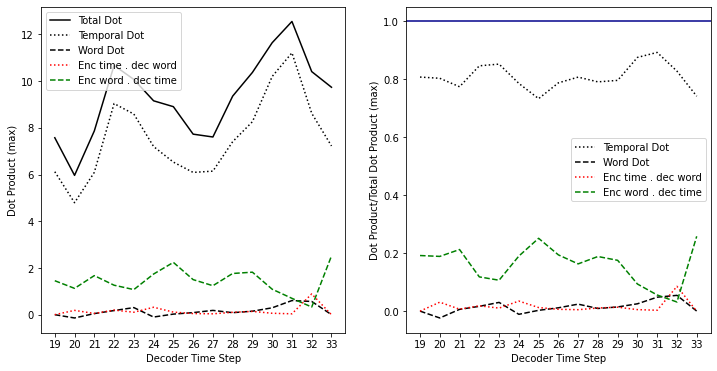

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plt_type = 'max' # 'diag'
plt_idx = 0 if plt_type == 'max' else 1

# For max alignment, gets average value
full_dots = np.zeros((dec_len))
time_dots = np.zeros((dec_len))
input_dots = np.zeros((dec_len))
enc_inp_dec_time = np.zeros((dec_len))
enc_time_dec_inp = np.zeros((dec_len))

full_dot = []
time_dot = []
input_dot = []
enc_inp_dec_time_dot = []
enc_time_dec_inp_dot = []
for h_idx in range(len(enc_dec_dots)):
  seq_len = len(enc_dec_dots[h_idx])
  for seq_idx in range(seq_len):
    for align_idx in range(num_aligns):
      full_dot.append(enc_dec_dots[h_idx][seq_idx][align_idx])
      time_dot.append(enct_dect[h_idx][seq_idx][align_idx])
      input_dot.append(encw_decw[h_idx][seq_idx][align_idx])
      enc_inp_dec_time_dot.append(encw_dect[h_idx][seq_idx][align_idx])
      enc_time_dec_inp_dot.append(enct_decw[h_idx][seq_idx][align_idx])

print('Full dot:', np.mean(full_dot))
print('Temporal dot:', np.mean(time_dot))
print('Word dot:', np.mean(input_dot))
print('Enc time . dec inp:', np.mean(enc_time_dec_inp_dot))
print('Enc inp . dec time:', np.mean(enc_inp_dec_time_dot))

for seq_idx in range(dec_len):
  full_dots[seq_idx] = np.mean(np.array([h_seq[seq_idx][0] for h_seq in enc_dec_dots if seq_idx < len(h_seq)]))
  time_dots[seq_idx] = np.mean(np.array([h_seq[seq_idx][0] for h_seq in enct_dect if seq_idx < len(h_seq)]))
  input_dots[seq_idx] = np.mean(np.array([h_seq[seq_idx][0] for h_seq in encw_decw if seq_idx < len(h_seq)]))
  enc_inp_dec_time[seq_idx] = np.mean(np.array([h_seq[seq_idx][0] for h_seq in encw_dect if seq_idx < len(h_seq)]))
  enc_time_dec_inp[seq_idx] = np.mean(np.array([h_seq[seq_idx][0] for h_seq in enct_decw if seq_idx < len(h_seq)]))

dec_times = [i+1+enc_len for i in range(dec_len)]
ax1.plot(dec_times, full_dots, color='k', label='Total Dot')
ax1.plot(dec_times, time_dots, color='k', linestyle='dotted', label='Temporal Dot')
ax1.plot(dec_times, input_dots, color='k', linestyle='dashed', label='Word Dot')
ax1.plot(dec_times, enc_time_dec_inp, color='r', linestyle='dotted', label='Enc time . dec word')
ax1.plot(dec_times, enc_inp_dec_time, color='g', linestyle='dashed', label='Enc word . dec time')
ax2.plot(dec_times, time_dots/full_dots, color='k', linestyle='dotted', label='Temporal Dot')
ax2.plot(dec_times, input_dots/full_dots, color='k', linestyle='dashed', label='Word Dot')
ax2.plot(dec_times, enc_time_dec_inp/full_dots, color='r', linestyle='dotted', label='Enc time . dec word')
ax2.plot(dec_times, enc_inp_dec_time/full_dots, color='g', linestyle='dashed', label='Enc word . dec time')

ax1.set_xlabel('Decoder Time Step')
ax1.set_ylabel(f'Dot Product ({plt_type})')
ax1.set_xticks(dec_times)

ax2.set_xlabel('Decoder Time Step')
ax2.set_ylabel(f'Dot Product/Total Dot Product ({plt_type})')
ax2.set_xticks(dec_times)
ax2.axhline(1.0, color='darkblue')

ax1.legend()
ax2.legend()

#### Modifier Word Analyses

In [ ]:
# Using the test phrases, finds the average hidden state for each time step for each word

hs_time_word_enc, hs_time_word_dec = sort_hs_by_time_and_word(hs, hs_data, toy_params)

avg_hs = find_avg_hs(hs, hs_data, toy_params)

avg_hs_word_enc = np.zeros((len(toy_params['in_words_pp']), enc_len, rnn_specs['hidden_size']))
avg_hs_word_dec = np.zeros((len(toy_params['out_words_pp']), dec_len, rnn_specs['hidden_size']))

for time_idx in range(enc_len): # Encoder
  for word_idx in range(len(hs_time_word_enc[time_idx])):
    if len(hs_time_word_enc[time_idx][word_idx]) > 0:
      avg_hs_word_enc[word_idx, time_idx, :] = np.mean(np.asarray(hs_time_word_enc[time_idx][word_idx]), axis=0)
for time_idx in range(dec_len): # Decoder
  for word_idx in range(len(hs_time_word_dec[time_idx])):
    if len(hs_time_word_dec[time_idx][word_idx]) > 0:
      avg_hs_word_dec[word_idx, time_idx, :] = np.mean(np.asarray(hs_time_word_dec[time_idx][word_idx]), axis=0)

print('Done')

Finding average hidden state at each time step...
Done


In [ ]:
for i in range(len(toy_params['in_words_pp'])):
  word_input = avg_hs_word_enc[i] - avg_hs[:enc_len]
  print('Word {} in mag:'.format(toy_params['in_words_pp'][i]), np.mean(np.linalg.norm(word_input, axis=1)))
  print('Word {} full mag:'.format(toy_params['in_words_pp'][i]), np.mean(np.linalg.norm(avg_hs_word_enc[i], axis=1)))
for i in range(len(toy_params['out_words_pp'])):
  word_input = avg_hs_word_dec[i] - avg_hs[enc_len:]
  print('Word {} in mag:'.format(toy_params['out_words_pp'][i]), np.mean(np.linalg.norm(word_input, axis=1)))
  print('Word {} full mag:'.format(toy_params['out_words_pp'][i]), np.mean(np.linalg.norm(avg_hs_word_dec[i], axis=1)))

for i in range(len(toy_params['in_words_pp'])):
  enc_word_input = avg_hs_word_enc[i] - avg_hs[:enc_len]
  dec_word_input = avg_hs_word_dec[i] - avg_hs[enc_len:]
  print('Word Dot {} and {}:'.format(toy_params['in_words_pp'][i], toy_params['out_words_pp'][i]), 
        np.mean([np.dot(ew, dw) for ew, dw in zip(enc_word_input, dec_word_input)]))

Word run in mag: 4.210326823340248
Word run full mag: 5.921070190145967
Word walk in mag: 4.21997496168575
Word walk full mag: 6.072807508657176
Word jump in mag: 4.0363925571617285
Word jump full mag: 6.392227521889953
Word left in mag: 4.121779331327723
Word left full mag: 6.242415305025892
Word and in mag: 3.485307575165261
Word and full mag: 5.798109312866551
Word twice in mag: 3.676875800621792
Word twice full mag: 5.759303021130434
Word <.> in mag: 2.8891321604437983
Word <.> full mag: 7.053072281654585
Word <pad> in mag: 4.805754736185588
Word <pad> full mag: 3.05177529470647
Word I_RUN in mag: 0.8090669365389119
Word I_RUN full mag: 4.621917999531918
Word I_WALK in mag: 0.8007830392074405
Word I_WALK full mag: 4.633314031257796
Word I_JUMP in mag: 0.7910623797751611
Word I_JUMP full mag: 4.629019444667566
Word I_TURN_LEFT in mag: 1.2435379854185475
Word I_TURN_LEFT full mag: 4.313386741801088
Word <.> in mag: 1.0005491406722518
Word <.> full mag: 4.569976806137221
Word <pad> in

IndexError: ignored

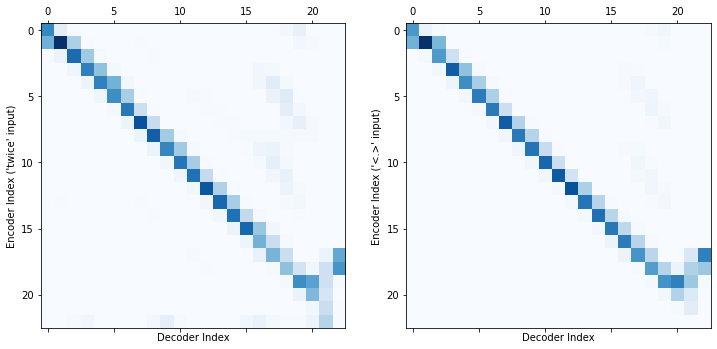

In [ ]:
# Encoder to compare
words = ['twice', '<.>'] #['<.>', 'left']

# Decoder to compare to
dec_seq_word = '<avg>'

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

if dec_seq_word == '<avg>': # Calculates and compares to average decoder sequence
  dec_seq = np.zeros((hs['all'][0].shape))
  for time_idx in range(hs['all'][0].shape[0]):
    time_hs = np.asarray([hs['all'][i][time_idx] for i in range(len(hs['all']))])
    dec_seq[time_idx] = np.mean(time_hs, axis=0)
else:
  dec_seq =  hs['special'][toy_params['out_words'].index(dec_seq_word)]
  
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for word, ax in zip(words, axs):
  # Attention matrix from mean input states
  # attn_matrix = np.zeros((enc_len, dec_len))
  # print('Word index:', toy_params['in_words'].index(word))
  # # Encoder sequence from chosen special word
  # enc_seq = hs['special'][toy_params['in_words'].index(word)][:enc_len, :] 
  # for seq_idx in range(dec_len):
  #   attn_matrix[:, seq_idx] = softmax(np.dot(enc_seq, dec_seq[enc_len + seq_idx, :]))

  attn_matrix = np.zeros((len(hs['all']), enc_len, dec_len))
  for h_idx in range(len(hs['all'])):
    enc_seq = hs['special'][toy_params['in_words'].index(word)][:enc_len, :]
    for seq_idx in range(dec_len):
      attn_matrix[h_idx, :, seq_idx] = softmax(np.dot(enc_seq, hs['all'][h_idx][enc_len + seq_idx]))

  attn_matrix = np.mean(attn_matrix, axis=0)

  ax.matshow(attn_matrix, cmap=plt.cm.Blues)
  ax.set_ylabel(f'Encoder Index (\'{word}\' input)')
  ax.set_xlabel('Decoder Index')

ValueError: ignored

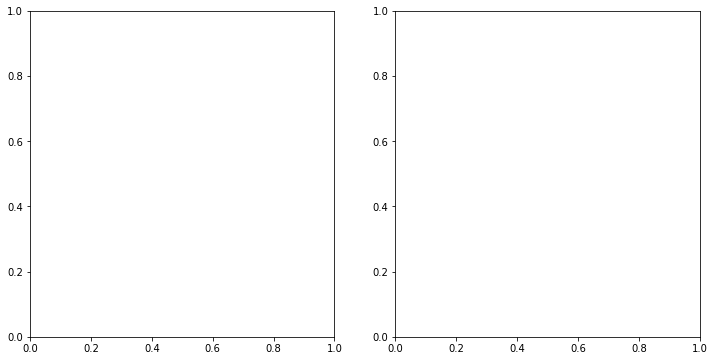

In [ ]:
# Encoder to compare
enc_seq_words = ['exercise', 'exercise'] 

# Decoder to compare to
dec_seq_words = ['I_EXER1', 'I_EXER2']

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

# if enc_seq_word == '<avg>': # Calculates and compares to average decoder sequence
#   enc_seq = np.zeros((hs['all'][0].shape))
#   for time_idx in range(hs['all'][0].shape[0]):
#     time_hs = np.asarray([hs['all'][i][time_idx] for i in range(len(hs['all']))])
#     enc_seq[time_idx] = np.mean(time_hs, axis=0)
# else:
#   enc_seq =  hs['special'][toy_params['in_words'].index(enc_seq_word)]
  
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for enc_word, dec_word, ax in zip(enc_seq_words, dec_seq_words, axs):
  # Attention matrix from mean input states
  # attn_matrix = np.zeros((enc_len, dec_len))
  # print('Word index:', toy_params['in_words'].index(word))
  # # Encoder sequence from chosen special word
  # enc_seq = hs['special'][toy_params['in_words'].index(word)][:enc_len, :] 
  # for seq_idx in range(dec_len):
  #   attn_matrix[:, seq_idx] = softmax(np.dot(enc_seq, dec_seq[enc_len + seq_idx, :]))

  # attn_matrix = np.zeros((len(hs['all']), enc_len, dec_len))
  # dec_seq = avg_hs_word_dec[toy_params['out_words'].index(word), :, :]
  # for h_idx in range(len(hs['all'])):
  #   enc_seq = hs['all'][h_idx][:enc_len]
  #   for seq_idx in range(enc_len):
  #     attn_matrix[h_idx, :, seq_idx] = softmax(np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(word), seq_idx, :]))

  # attn_matrix = np.mean(attn_matrix, axis=0)

  attn_matrix = np.zeros((enc_len, dec_len))
  enc_seq = avg_hs_word_dec[toy_params['in_words'].index(enc_word), :, :]
  for seq_idx in range(enc_len):
    attn_matrix[:, seq_idx] = softmax(np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(dec_word), seq_idx, :]))

  # attn_matrix = 

  ax.matshow(attn_matrix, cmap=plt.cm.Blues)
  ax.set_ylabel(f'Encoder Index (\'{enc_word}\' input)')
  ax.set_xlabel(f'Decoder Index (\'{dec_word}\' input)')

[Text(0, 0, 'run'),
 Text(0, 0, 'walk'),
 Text(0, 0, 'exercise'),
 Text(0, 0, 'left'),
 Text(0, 0, '<.>'),
 Text(0, 0, '<pad>')]

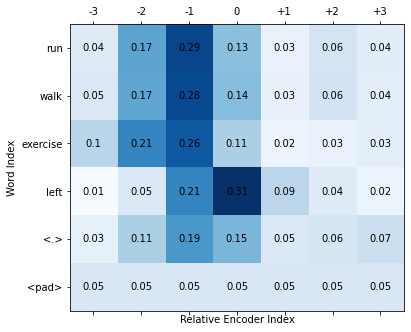

In [ ]:
look_dist = 3 # How many squares to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])

dec_seq = np.zeros((hs['all'][0].shape))
for time_idx in range(hs['all'][0].shape[0]):
  time_hs = np.asarray([hs['all'][i][time_idx] for i in range(len(hs['all']))])
  dec_seq[time_idx] = np.mean(time_hs, axis=0)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
relative_aligns = np.zeros((len(toy_params['in_words_pp']), 2*look_dist + 1))

for word_idx in range(len(toy_params['in_words_pp'])):
  # Finds the average attention matrix
  attn_matrix = np.zeros((len(hs['all']), enc_len, dec_len))
  for h_idx in range(len(hs['all'])):
    enc_seq = hs['special'][word_idx][:enc_len, :]
    for seq_idx in range(dec_len):
      attn_matrix[h_idx, :, seq_idx] = softmax(np.dot(enc_seq, hs['all'][h_idx][enc_len + seq_idx]))

  attn_matrix = np.mean(attn_matrix, axis=0)

  relative_aligns_word = np.zeros((dec_len-2*look_dist, 2*look_dist + 1))
  for dec_idx in range(look_dist, min_len-look_dist): # Each decoder location for a given look_dist
    relative_aligns_word[dec_idx - look_dist] = attn_matrix[dec_idx - look_dist:dec_idx + look_dist + 1, dec_idx]

  relative_aligns[word_idx] = np.mean(relative_aligns_word , axis=0)

ax1.matshow(relative_aligns, cmap=plt.cm.Blues)
ax1.set_ylabel('Word Index')
ax1.set_xlabel('Relative Encoder Index')

for i in range(relative_aligns.shape[1]):
  for j in range(relative_aligns.shape[0]):
    c = relative_aligns[j,i]
    ax1.text(i, j, str(round(c, 2)), va='center', ha='center')

ax1.set_xticks([j for j in range(2*look_dist + 1)])
ax1.set_yticks([j for j in range(len(toy_params['in_words_pp']))])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)
ax1.set_yticklabels(toy_params['in_words_pp'], rotation=0)

Using minimum sequence length of: 18


[Text(0, 0, '-2'),
 Text(0, 0, '-1'),
 Text(0, 0, '0'),
 Text(0, 0, '+1'),
 Text(0, 0, '+2')]

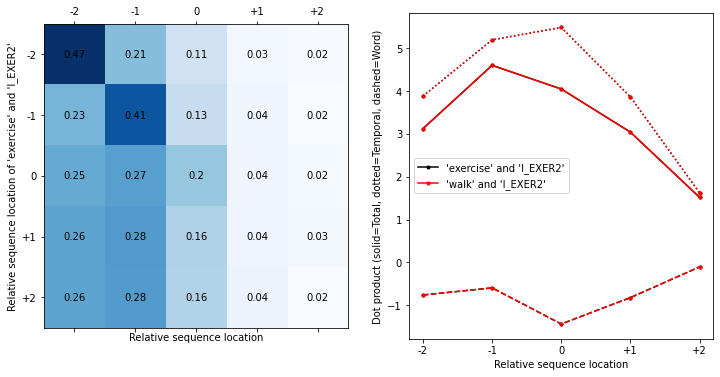

In [ ]:
# Sees if a word in the decoder latches onto particular other words as a function of distance.
# Uses the average states to compute said latching.

look_dist = 2 # How many time-steps to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])
print('Using minimum sequence length of:', min_len)

latch_words = ['exercise', 'I_EXER2'] # Input-Output pair to test
other_in_words = ['walk', 'run', '<.>']

align_vals = np.zeros((len(other_in_words), 2*look_dist+1, 2*look_dist+1))

for word_idx in range(len(other_in_words)):
  for os_idx in range(2*look_dist+1):
    offset = os_idx - look_dist
    align_vals_offset = np.zeros((min_len-2*look_dist, 2*look_dist+1))

    for seq_idx in range(min_len-2*look_dist):
      enc_loc = look_dist + seq_idx + offset # Location of latch word in input
      dec_loc = look_dist + seq_idx # Location of latch word in output

      # print('Enc loc', enc_loc)
      # Fills encoder sequence with other word
      enc_seq = np.copy(avg_hs_word_enc[toy_params['in_words'].index(other_in_words[word_idx])])
      # Makes sequence index the latch word
      enc_seq[enc_loc, :] = avg_hs_word_enc[toy_params['in_words'].index(latch_words[0]), enc_loc, :]


      soft_max_vals = softmax(np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :]))

      align_vals_offset[seq_idx, :] = soft_max_vals[dec_loc-look_dist:dec_loc+look_dist+1]

    align_vals[word_idx, os_idx] = np.mean(align_vals_offset, axis=0)
# Averages over all other words:
align_vals = np.mean(align_vals, axis=0)

# Decomposes dot product of latch words into temporal and word components
latch_dot = np.zeros((2*look_dist+1, min_len-2*look_dist, 2))
non_latch_dot = np.zeros((2*look_dist+1, min_len-2*look_dist, 2))
for os_idx in range(2*look_dist+1):
  offset = os_idx - look_dist
  for seq_idx in range(min_len-2*look_dist):
    enc_loc = seq_idx + offset # Location of latch word in input
    dec_loc = seq_idx # Location of latch word in output
    enc_hs_word = avg_hs_word_dec[toy_params['in_words'].index(latch_words[0]), enc_loc] - avg_hs[enc_loc]
    dec_hs_word = avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc] - avg_hs[dec_loc + enc_len]

    enc_hs_nl_word = avg_hs_word_dec[toy_params['in_words'].index(other_in_words[0]), enc_loc] - avg_hs[enc_loc]

    latch_dot[os_idx, seq_idx, 0] = np.dot(avg_hs[enc_loc], avg_hs[dec_loc + enc_len])
    latch_dot[os_idx, seq_idx, 1] = np.dot(enc_hs_word, dec_hs_word)
    non_latch_dot[os_idx, seq_idx, 0] = np.dot(avg_hs[enc_loc], avg_hs[dec_loc + enc_len])
    non_latch_dot[os_idx, seq_idx, 1] = np.dot(enc_hs_nl_word, dec_hs_word)
# Averages over sequence location
latch_dot = np.mean(latch_dot, axis=1)
non_latch_dot = np.mean(non_latch_dot, axis=1) 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.matshow(align_vals, cmap=plt.cm.Blues)
ax1.set_ylabel(f'Relative sequence location of \'{latch_words[0]}\' and \'{latch_words[1]}\'')
ax1.set_xlabel('Relative sequence location')

ax2.plot([j - look_dist for j in range(2*look_dist + 1)], latch_dot[:, 0] + latch_dot[:, 1], color='k', 
         marker='.', linestyle='solid', label=f'\'{latch_words[0]}\' and \'{latch_words[1]}\'')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], latch_dot[:, 0], color='k', marker='.',
         linestyle='dotted')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], latch_dot[:, 1], color='k', marker='.',
         linestyle='dashed')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], non_latch_dot[:, 0] + non_latch_dot[:, 1], color='r', 
         marker='.', linestyle='solid', label=f'\'{other_in_words[0]}\' and \'{latch_words[1]}\'')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], non_latch_dot[:, 0], color='r', marker='.',
         linestyle='dotted')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], non_latch_dot[:, 1], color='r', marker='.',
         linestyle='dashed')
ax2.set_ylabel(f'Dot product (solid=Total, dotted=Temporal, dashed=Word)')
ax2.set_xlabel('Relative sequence location')
ax2.legend()

for i in range(align_vals.shape[1]):
  for j in range(align_vals.shape[0]):
    c = align_vals[j,i]
    ax1.text(i, j, str(round(c, 2)), va='center', ha='center')

ax1.set_xticks([j for j in range(2*look_dist + 1)])
ax1.set_yticks([j for j in range(2*look_dist + 1)])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)
ax1.set_yticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

ax2.set_xticks([j-look_dist for j in range(2*look_dist + 1)])
ax2.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

Finding average hidden state at each time step...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars


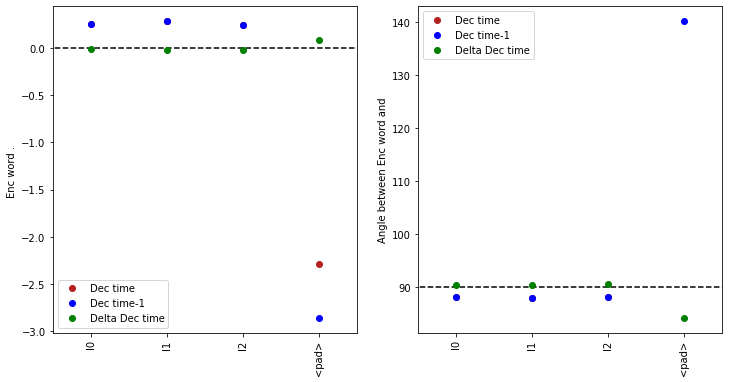

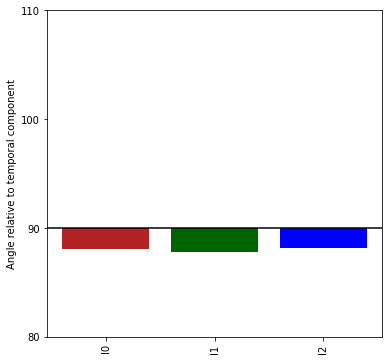

In [ ]:
# Checks the dot product of the encoder word subspace with the decoder time subspace. 
# This has shown up in multiple modifier words as a way of lowering the overall dot product.

temporal_hs = find_avg_hs(hs, hs_data, toy_params)
# temporal_hs = hs['special'][-1]
delta_temporal = [temporal_hs[i+1] - temporal_hs[i] for i in range(temporal_hs.shape[0]-1)]

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

# First index is dot with temporal hs at time step, second is temporal hs at next time step, third difference
avg_word_dots = np.zeros((len(toy_params['in_words_pp']), 3))
avg_word_angles = np.zeros((len(toy_params['in_words_pp']), 3))

for word_idx in range(len(toy_params['in_words_pp'])):
  word_dots = []
  word_next_dots = []
  delta_word_dots = []
  word_angles = []
  word_next_angles = []
  delta_word_angles = []
  for seq_idx in range(np.min((enc_len, dec_len))):
    if not np.all(avg_hs_word_enc[word_idx][seq_idx] == np.zeros(rnn_specs['hidden_size'])): # Makes sure average is not zeros
      word_enc = avg_hs_word_enc[word_idx][seq_idx] - temporal_hs[seq_idx]
      word_dots.append(np.dot(temporal_hs[enc_len+seq_idx], word_enc))
      word_angles.append(angle_degrees(temporal_hs[enc_len+seq_idx], word_enc))
      if seq_idx < np.min((enc_len, dec_len)) - 1:
        delta_word_dots.append(np.dot(delta_temporal[enc_len+seq_idx], word_enc))
        delta_word_angles.append(angle_degrees(delta_temporal[enc_len+seq_idx], word_enc))
        word_next_enc = avg_hs_word_enc[word_idx][seq_idx] - temporal_hs[seq_idx]
        word_next_dots.append(np.dot(temporal_hs[enc_len+seq_idx], word_next_enc))
        word_next_angles.append(angle_degrees(temporal_hs[enc_len+seq_idx], word_next_enc))

  avg_word_dots[word_idx, 0] = np.mean(np.asarray(word_dots), axis=0)
  avg_word_angles[word_idx, 0] = np.mean(np.asarray(word_angles), axis=0)
  avg_word_dots[word_idx, 1] = np.mean(np.asarray(word_next_dots), axis=0)
  avg_word_angles[word_idx, 1] = np.mean(np.asarray(word_next_angles), axis=0)
  avg_word_dots[word_idx, 2] = np.mean(np.asarray(delta_word_dots), axis=0)
  avg_word_angles[word_idx, 2] = np.mean(np.asarray(delta_word_angles), axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig2, ax3 = plt.subplots(1, 1, figsize=(6, 6))

ax1.plot([i for i in range(len(toy_params['in_words_pp']))], avg_word_dots[:, 0], marker='o', color='firebrick', linewidth=0, label='Dec time')
ax1.plot([i for i in range(len(toy_params['in_words_pp']))], avg_word_dots[:, 1], marker='o', color='blue', linewidth=0, label='Dec time-1')
ax1.plot([i for i in range(len(toy_params['in_words_pp']))], avg_word_dots[:, 2], marker='o', color='green', linewidth=0, label='Delta Dec time')
ax1.set_ylabel('Enc word . ')
ax1.hlines(0.0, -1, len(toy_params['in_words_pp'])+1, linestyles='dashed', color='k')
ax2.plot([i for i in range(len(toy_params['in_words_pp']))], avg_word_angles[:, 0], marker='o', color='firebrick', linewidth=0, label='Dec time')
ax2.plot([i for i in range(len(toy_params['in_words_pp']))], avg_word_angles[:, 1], marker='o', color='blue', linewidth=0, label='Dec time-1')
ax2.plot([i for i in range(len(toy_params['in_words_pp']))], avg_word_angles[:, 2], marker='o', color='green', linewidth=0, label='Delta Dec time')
ax2.set_ylabel('Angle between Enc word and')
ax2.hlines(90.0, -1, len(toy_params['in_words_pp'])+1, linestyles='dashed', color='k')

ax3.bar([i for i in range(len(toy_params['in_words_pp'])-1)], avg_word_angles[:-1, 0]-90, width=0.8, color=state_colors[:len(toy_params['in_words_pp'])-1])
ax3.axhline(0.0, color='k')
ax3.set_ylabel('Angle relative to temporal component')
ticks = np.array([-10, 0, 10, 20])
ax3.set_yticks(ticks)
ax3.set_yticklabels(ticks+90)
ax3.set_xticks([i for i in range(len(toy_params['in_words_pp'])-1)])
ax3.set_xticklabels(toy_params['in_words_pp'][:-1], rotation=90)

for ax in [ax1, ax2,]:
  ax.set_xlim([-0.5, len(toy_params['in_words_pp'])-0.5])
  ax.set_xticks([i for i in range(len(toy_params['in_words_pp']))])
  ax.set_xticklabels(toy_params['in_words_pp'], rotation=90)
  ax.legend()

Finding average hidden state at each time step...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars


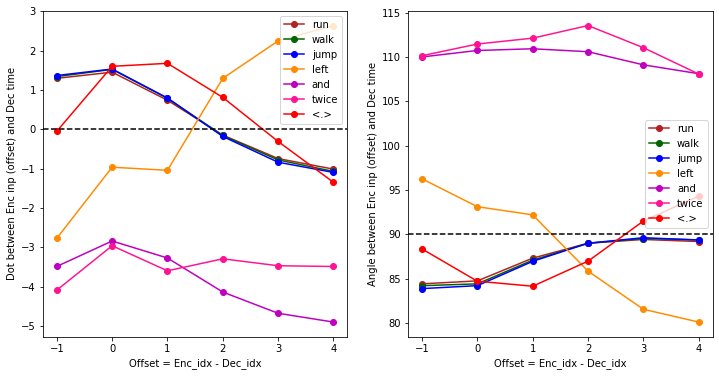

In [ ]:
# Checks the dot product of the encoder word subspace with the decoder time subspace. 
# This has shown up in multiple modifier words as a way of lowering the overall dot product.

temporal_hs = find_avg_hs(hs, hs_data, toy_params)
b_off = 1 # backward offset
f_off = 4 # forward offset

# First index is dot with temporal hs at time step, second is temporal hs at next time step, third difference
avg_word_dots = np.zeros((len(toy_params['in_words_pp']), b_off+f_off+1))
avg_word_angles = np.zeros((len(toy_params['in_words_pp']), b_off+f_off+1))
for word_idx in range(len(toy_params['in_words_pp'])):
  word_dots = []
  word_angles = []
  for seq_idx in range(b_off, np.min((enc_len-f_off, dec_len))):
    if not np.all(avg_hs_word_enc[word_idx][seq_idx] == np.zeros(rnn_specs['hidden_size'])): # Makes sure average is not zeros
      word_enc = avg_hs_word_enc[word_idx][seq_idx-b_off:seq_idx+f_off+1] - temporal_hs[seq_idx-b_off:seq_idx+f_off+1]
      word_dots.append(np.dot(word_enc, temporal_hs[enc_len+seq_idx]))
      angles = []
      for offset_idx in range(0, b_off+f_off+1):
        angles.append(angle_degrees(temporal_hs[enc_len+seq_idx], word_enc[offset_idx]))
      word_angles.append(angles)

  avg_word_dots[word_idx] = np.mean(np.asarray(word_dots), axis=0)
  avg_word_angles[word_idx] = np.mean(np.asarray(word_angles), axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

offset_vals = [i-b_off for i in range(b_off+f_off+1)]
for word_idx in range(len(toy_params['in_words_pp'])-1): # -1 eliminates <pad>
  ax1.plot(offset_vals, avg_word_dots[word_idx], marker='o', color=state_colors[word_idx], label=toy_params['in_words_pp'][word_idx])
  ax2.plot(offset_vals, avg_word_angles[word_idx], marker='o', color=state_colors[word_idx], label=toy_params['in_words_pp'][word_idx])

ax1.axhline(0.0, linestyle='dashed', color='k')
ax1.set_ylabel('Dot between Enc inp (offset) and Dec time')
ax2.set_ylabel('Angle between Enc inp (offset) and Dec time')
ax2.axhline(90.0, linestyle='dashed', color='k')

for ax in [ax1, ax2]:
  ax.legend()
  ax.set_xlabel('Offset = Enc_idx - Dec_idx')

#### 'Twice' Analysis

Using minimum sequence length of: 23


[Text(0, 0, '-2'),
 Text(0, 0, '-1'),
 Text(0, 0, '0'),
 Text(0, 0, '+1'),
 Text(0, 0, '+2')]

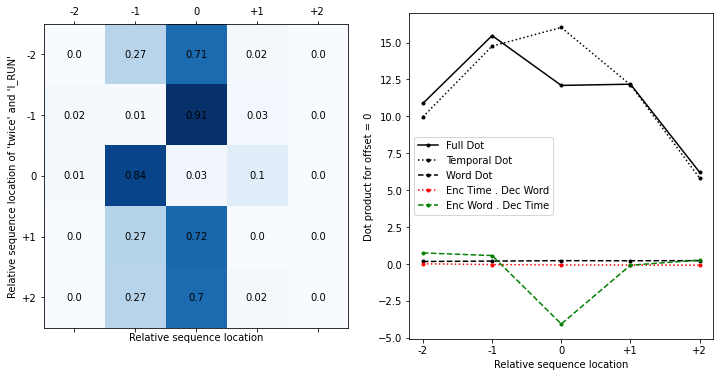

In [ ]:
look_dist = 2 # How many time-steps to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])
print('Using minimum sequence length of:', min_len)

latch_words = ['run', 'I_RUN'] # Input-Output pair to test
other_in_words = ['walk', 'jump', '<.>']

align_vals = np.zeros((len(other_in_words), 2*look_dist+1, 2*look_dist+1))

for word_idx in range(len(other_in_words)):
  for os_idx in range(2*look_dist+1):
    offset = os_idx - look_dist
    align_vals_offset = np.zeros((min_len-2*look_dist, 2*look_dist+1))
    base = avg_hs_word_enc[toy_params['in_words'].index(other_in_words[0])]

    for seq_idx in range(min_len-2*look_dist):
      enc_loc = look_dist + seq_idx + offset # Location of latch word in input
      dec_loc = look_dist + seq_idx # Location of latch word in output

      # print('Enc loc', enc_loc)
      # Fills encoder sequence with other word
      enc_seq = np.copy(avg_hs_word_enc[toy_params['in_words'].index(other_in_words[word_idx])])
      # Makes sequence index the latch word
      enc_seq[enc_loc, :] = avg_hs_word_enc[toy_params['in_words'].index(latch_words[0]), enc_loc, :]

      # print((base == enc_seq)[:, :2])

      soft_max_vals = softmax(np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :]))
      # print(soft_max_vals)
      # print(soft_max_vals[dec_loc-look_dist:dec_loc+look_dist+1])
      # print(dfsdfsd)

      align_vals_offset[seq_idx, :] = soft_max_vals[dec_loc-look_dist:dec_loc+look_dist+1]

    align_vals[word_idx, os_idx] = np.mean(align_vals_offset, axis=0)
# Averages over all other words:
align_vals = np.mean(align_vals, axis=0)

dot_vals = np.zeros((len(other_in_words), 2*look_dist+1, 5))

for word_idx in range(len(other_in_words)):
  dot_vals_seq = np.zeros((min_len-2*look_dist, 2*look_dist+1, 5))
  for seq_idx in range(min_len-2*look_dist):
    enc_loc = look_dist + seq_idx # Location of latch word in input
    dec_loc = look_dist + seq_idx # Location of latch word in output

    enc_seq = np.copy(avg_hs_word_enc[toy_params['in_words'].index(other_in_words[word_idx])])
    # Makes sequence index the latch word
    enc_seq[enc_loc, :] = avg_hs_word_enc[toy_params['in_words'].index(latch_words[0]), enc_loc, :]

    # print((base == enc_seq)[:, :2])

    dot_vals_seq[seq_idx, :, 0] = np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 1] = np.dot(avg_hs[:enc_len], avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 2] = np.dot(enc_seq - avg_hs[:enc_len], avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :] - avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 3] = np.dot(avg_hs[:enc_len], avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :] - avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 4] = np.dot(enc_seq - avg_hs[:enc_len], avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]

  dot_vals[word_idx] = np.mean(dot_vals_seq, axis=0)
# Averages over all other words:
dot_vals = np.mean(dot_vals, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.matshow(align_vals, cmap=plt.cm.Blues)
ax1.set_ylabel(f'Relative sequence location of \'{latch_words[0]}\' and \'{latch_words[1]}\'')
ax1.set_xlabel('Relative sequence location')

ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,0], color='k', 
         marker='.', linestyle='solid', label='Full Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,1], color='k', 
         marker='.', linestyle='dotted', label='Temporal Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,2], color='k', 
         marker='.', linestyle='dashed', label='Word Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,3], color='r', 
         marker='.', linestyle='dotted', label='Enc Time . Dec Word')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,4], color='g', 
         marker='.', linestyle='dashed', label='Enc Word . Dec Time')
ax2.set_ylabel(f'Dot product for offset = 0')
ax2.set_xlabel('Relative sequence location')
ax2.legend()

for i in range(align_vals.shape[1]):
  for j in range(align_vals.shape[0]):
    c = align_vals[j,i]
    ax1.text(i, j, str(round(c, 2)), va='center', ha='center')

ax1.set_xticks([j for j in range(2*look_dist + 1)])
ax1.set_yticks([j for j in range(2*look_dist + 1)])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)
ax1.set_yticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

ax2.set_xticks([j-look_dist for j in range(2*look_dist + 1)])
ax2.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

In [ ]:
# Calculates average hidden state and subtracts it out from hidden states at all time steps to isolate word subspace
# Average hidden state does NOT include repeated <pad>'s for encoder or decoder
context_word = 'twice'
other_words = ['run', 'walk', 'left']

cw_idx = toy_params['in_words'].index(context_word)
ow_idxs = [toy_params['in_words'].index(word) for word in other_words]

avg_hs = np.zeros((hs['all'][0].shape))
pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 
enc_len = hs_data['inputs'][0].shape[0]
dec_len = toy_params['phrase_length']

for time_idx in range(hs['all'][0].shape[0]):
  if time_idx < enc_len: # Encoder
    time_hs = []
    for h, inp in zip(hs['all'], hs_data['inputs']):
      if time_idx > 0:
        if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  else: # Decoder
    time_hs = []
    for h, out in zip(hs['all'], hs_data['labels']):
      if time_idx - enc_len> 0:
        if np.argmax(out[time_idx-enc_len]) != pad_out_idx or np.argmax(out[time_idx-enc_len-1]) != pad_out_idx:
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  if time_hs.shape[0] > 0:
    avg_hs[time_idx] = np.mean(time_hs, axis=0)
  else:
    print('Zero length')

# Removes average hidden state from all hidden states
hs_mod_pos_enc = [h - avg_hs for h in hs['all']]

hs_word = [[] for _ in range(len(toy_params['in_words_pp']))]
hs_inputs_context = [[] for _ in range(len(other_words))]

pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 

for time_idx in range(enc_len): # Encoder
  for h_mpe, inp in zip(hs_mod_pos_enc, hs_data['inputs']):
    if time_idx > 0:
      if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
        hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    else: # Automatically adds if first index
      hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    if np.argmax(inp[time_idx]) == cw_idx and time_idx > 0:
      last_inp = inp[time_idx-1]
      last_inp_idx = np.argmax(last_inp)
      hs_inputs_context[ow_idxs.index(last_inp_idx)].append(h_mpe[time_idx])

print('Done')

Done


Text(0, 0.5, 'PC1 (mod pos_enc)')

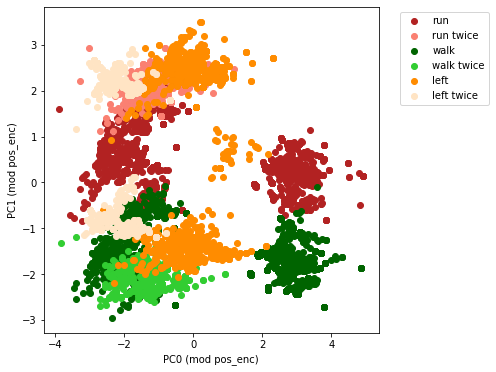

In [ ]:
# Plots decomposition of hidden states into temporal and word spaces
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))

##### Plotting for word part #####

pts_subset = 'enc'

pc1 = 0
pc2 = 1

pca_mod_pe = PCA(n_components=rnn_specs['hidden_size'])

_ = pca_mod_pe.fit(np.vstack(np.asarray(hs_mod_pos_enc)[:,:enc_len,:]))
pca_mod_pe_hs = pca_mod_pe.transform(np.vstack(hs_mod_pos_enc)).T

pca_hs = pca_mod_pe.transform(np.vstack(hs['all'])).T
for inp_idx in ow_idxs:
  pca_mod_pe_word = pca_mod_pe.transform(np.vstack(hs_word[inp_idx])).T
  ax1.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[inp_idx], label=toy_params['in_words'][inp_idx])
  pca_mod_pe_cword = pca_mod_pe.transform(np.vstack(hs_inputs_context[ow_idxs.index(inp_idx)])).T
  ax1.scatter(pca_mod_pe_cword[pc1], pca_mod_pe_cword[pc2], color=state_colors_light[inp_idx], 
              label=toy_params['in_words'][inp_idx] + ' ' + context_word)

# Plots readout direction
# readout_types = ['att']  #'att', 'hs', 'sum'] # 'att' or 'hs'
# ro_styles = ['solid', 'dotted', 'dashed']
# for idx in range(len(readout_types)):
#   if readout_types[idx] == 'att':
#     readout_plot = readout 
#     # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
#   elif readout_types[idx] == 'hs':
#     readout_plot = readout_dec
#     # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
#   elif readout_types[idx] == 'sum':
#     readout_plot = readout + readout_dec
#   pca_ro = pca_avg.transform(readout_plot)
#   pca_zero = pca_avg.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
#   for i in range(readout_plot.shape[0]):
#     x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
#     y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
#     ax1.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, linestyle=ro_styles[idx],
#               label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax1.set_xlabel('PC'+str(pc1)+' (mod pos_enc)')
ax1.set_ylabel('PC'+str(pc2)+' (mod pos_enc)')

#### "Exercise' Analysis

In [ ]:
# Decoposes a word's dot product into the different components, uses the average hidden states for a 
# given word to do the calculation.

from scipy.special import softmax

look_dist = 2 # How many time-steps to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])
print('Using minimum sequence length of:', min_len)

latch_words = ['exercise', 'I_EXER2'] # Input-Output pair to test
other_in_words = ['<.>',]

align_vals = np.zeros((len(other_in_words), 2*look_dist+1, 2*look_dist+1))

for word_idx in range(len(other_in_words)):
  for os_idx in range(2*look_dist+1):
    offset = os_idx - look_dist
    align_vals_offset = np.zeros((min_len-2*look_dist, 2*look_dist+1))
    base = avg_hs_word_enc[toy_params['in_words'].index(other_in_words[0])]

    for seq_idx in range(min_len-2*look_dist):
      enc_loc = look_dist + seq_idx + offset # Location of latch word in input
      dec_loc = look_dist + seq_idx # Location of latch word in output

      # print('Enc loc', enc_loc)
      # Fills encoder sequence with other word
      enc_seq = np.copy(avg_hs_word_enc[toy_params['in_words'].index(other_in_words[word_idx])])
      # Makes sequence index the latch word
      enc_seq[enc_loc, :] = avg_hs_word_enc[toy_params['in_words'].index(latch_words[0]), enc_loc, :]

      # print((base == enc_seq)[:, :2])

      soft_max_vals = softmax(np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :]))
      # print(soft_max_vals)
      # print(soft_max_vals[dec_loc-look_dist:dec_loc+look_dist+1])
      # print(dfsdfsd)

      align_vals_offset[seq_idx, :] = soft_max_vals[dec_loc-look_dist:dec_loc+look_dist+1]

    align_vals[word_idx, os_idx] = np.mean(align_vals_offset, axis=0)
# Averages over all other words:
align_vals = np.mean(align_vals, axis=0)

dot_vals = np.zeros((len(other_in_words), 2*look_dist+1, 5))

offset = -1 # Negative means encoder location is before decoder locat

for word_idx in range(len(other_in_words)):
  dot_vals_seq = np.zeros((min_len-2*look_dist, 2*look_dist+1, 5))
  for seq_idx in range(min_len-2*look_dist):
    enc_loc = look_dist + seq_idx + offset # Location of latch word in input
    dec_loc = look_dist + seq_idx # Location of latch word in output

    enc_seq = np.copy(avg_hs_word_enc[toy_params['in_words'].index(other_in_words[word_idx])])
    # Makes sequence index the latch word
    enc_seq[enc_loc, :] = avg_hs_word_enc[toy_params['in_words'].index(latch_words[0]), enc_loc, :]

    # print((base == enc_seq)[:, :2])

    dot_vals_seq[seq_idx, :, 0] = np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 1] = np.dot(avg_hs[:enc_len], avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 2] = np.dot(enc_seq - avg_hs[:enc_len], avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :] - avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 3] = np.dot(avg_hs[:enc_len], avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :] - avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 4] = np.dot(enc_seq - avg_hs[:enc_len], avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]

  dot_vals[word_idx] = np.mean(dot_vals_seq, axis=0)
# Averages over all other words:
dot_vals = np.mean(dot_vals, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.matshow(align_vals, cmap=plt.cm.Blues)
ax1.set_ylabel(f'Relative sequence location of \'{latch_words[0]}\' and \'{latch_words[1]}\' (enc-dec)')
ax1.set_xlabel('Relative sequence location')

ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,0], color='k', 
         marker='.', linestyle='solid', label='Full Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,1], color='k', 
         marker='.', linestyle='dotted', label='Temporal Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,2], color='k', 
         marker='.', linestyle='dashed', label='Word Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,3], color='r', 
         marker='.', linestyle='dotted', label='Enc Time . Dec Word')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,4], color='g', 
         marker='.', linestyle='dashed', label='Enc Word . Dec Time')
ax2.set_ylabel('Dot product for offset = ' + str(offset))
ax2.set_xlabel('Relative sequence location')
ax2.legend()

for i in range(align_vals.shape[1]):
  for j in range(align_vals.shape[0]):
    c = align_vals[j,i]
    ax1.text(i, j, str(round(c, 2)), va='center', ha='center')

ax1.set_xticks([j for j in range(2*look_dist + 1)])
ax1.set_yticks([j for j in range(2*look_dist + 1)])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)
ax1.set_yticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

ax2.set_xticks([j-look_dist for j in range(2*look_dist + 1)])
ax2.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

Using minimum sequence length of: 17


NameError: ignored

In [ ]:
latch_words = ['left', 'I_TURN_LEFT'] # Input-Output pair to test
# latch_words = ['walk', 'I_WALK'] # Input-Output pair to test
latch_idx = [toy_params['in_words'].index(latch_words[0]), toy_params['out_words'].index(latch_words[1])]

dot_vals = []

offset = 1

for h_idx in range(10,20):

  in_idx = hs_data['in_index'][h_idx]
  out_idx = hs_data['out_index'][h_idx]
  min_len = np.min([in_idx, out_idx])

  enc_phrase = hs['all'][h_idx][:min_len+1]
  dec_phrase = hs['all'][h_idx][enc_len:enc_len+min_len+1]
  in_latch_locs = np.argmax(hs_data['inputs'][h_idx][:min_len+1], axis=1) == latch_idx[0]
  out_latch_locs = np.argmax(hs_data['labels'][h_idx][:min_len+1], axis=1) == latch_idx[1]

  print('Inputs:', in_latch_locs)
  print('Outputs:', out_latch_locs)

  # Finds locations in phrase where latches have the given offset
  if offset == 0: # No shift to input phrase
    locs = np.logical_and(in_latch_locs, out_latch_locs)
  elif offset > 0: # Shifts input phrase upwards
    locs = np.logical_and(in_latch_locs[offset:], out_latch_locs[:-offset]) 
  else: # Shifts input phrase backwards
    locs = np.logical_and(in_latch_locs[:offset], out_latch_locs[-offset:])

  # Finds all valid locations, eliminating idxs that are within look_dist of start or end of phrase
  if offset >= 0:
    latch_locs = [i for i, x in enumerate(locs) if x and i >= look_dist and i <= min_len-look_dist] 
  else: # Need to add offset since started at idx=offset when comparing
    latch_locs = [i - offset for i, x in enumerate(locs) if x and i >= look_dist and i <= min_len-look_dist] 

  print('Latch locations:', latch_locs)

  # Calculates aligns
  aligns = np.dot(dec_phrase, enc_phrase.T)

  for latch_loc in latch_locs:
    dot_vals.append(aligns[latch_loc, latch_loc-look_dist:latch_loc+look_dist+1])

print(np.asarray(dot_vals).shape)
print(np.mean(np.asarray(dot_vals), axis=0))

Inputs: [False False False False False False  True False False False False False
 False False  True]
Outputs: [False False False False  True False False False False False False  True
 False False False]
Latch locations: []
Inputs: [False False False  True False False False False False False False]
Outputs: [False  True False False False False False False False False False]
Latch locations: []
Inputs: [False  True False False  True False False False False False False]
Outputs: [ True False  True False False False False False False False False]
Latch locations: []
Inputs: [False False False False False False False False False False False False
  True False False]
Outputs: [False False False False False False False False False  True False  True
 False False False]
Latch locations: [11]
Inputs: [False False False False False False  True False False False False False
  True False]
Outputs: [False False False False  True False False False False  True False False
 False False]
Latch locations

#### Dot Decomposition

Finding average hidden state at each time step...
Searching for: 
 ['<any>', '<any>', '<any>', 'left', '<any>'] 
 ['<any>', '<any>', 'I_TURN_LEFT', '<any>', '<any>']
Averaging over 32 latch locations
Dot val shape: (5, 32, 5)
Dot val mean shape: [[-0.28034155  6.20289621  9.09460132 11.92394793  4.62626104]
 [ 0.46673507  3.69953105  7.61280157  7.99122739  5.87017447]
 [-0.1447255  -2.83040239 -0.49254251  1.64179672  1.46577949]
 [-0.55655682  0.39207473  0.37488054  0.4766821   0.35590047]
 [-0.04579404  4.94169322  1.59946264  1.81424272 -3.06559332]]


[Text(0, 0, '-2'),
 Text(0, 0, '-1'),
 Text(0, 0, '0'),
 Text(0, 0, '+1'),
 Text(0, 0, '+2')]

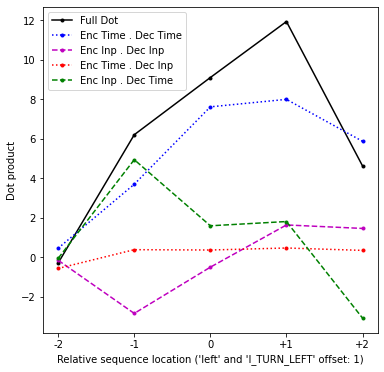

In [ ]:
# Same as the decomposition above, but searches the test phrases for the desired latch alignment.

from scipy.special import softmax

index_filter = True
idx_filter_val = 5

avg_hs = find_avg_hs(hs, hs_data, toy_params)

look_dist = 2 # How many time-steps to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

# offset is encoder location - decoder location
latch_words, offset = ['left', 'I_TURN_LEFT'], 1 # Input-Output pair to test
# latch_words, offset = ['left', 'I_WALK'], 1 # Input-Output pair to test
# latch_words, offset = ['I0', 'O0'], 0 # Input-Output pair to test
# latch_words, offset= ['and', 'I_RUN'], 0 # Input-Output pair to test
# latch_words, offset= ['twice', 'I_RUN'], 0 # Input-Output pair to test
# latch_words = ['exercise', 'I_EXER2'], 1 # Input-Output pair to test
# latch_words, offset = ['<.>', '<.>'], 0 # Input-Output pair to test
# latch_words, offset = ['run', 'I_RUN'], 1 # Input-Output pair to test

latch_idx = [toy_params['in_words'].index(latch_words[0]), toy_params['out_words'].index(latch_words[1])]

dot_vals = [[] for _ in range(5)] # total, and 4 different parts

enc_template, dec_template = ['<any>' for _ in range(2*look_dist+1)], ['<any>' for _ in range(2*look_dist+1)]
enc_template[look_dist+offset] = latch_words[0]
dec_template[look_dist] = latch_words[1]
print('Searching for: \n', enc_template, '\n', dec_template)

for h, inp, out, in_idx, out_idx in zip(hs['all'], hs_data['inputs'], hs_data['labels'], hs_data['in_index'], hs_data['out_index']):
  min_len = np.min([in_idx, out_idx])

  enc_phrase = h[:min_len+1]
  dec_phrase = h[enc_len:enc_len+min_len+1]
  in_latch_locs = np.argmax(inp[:min_len+1], axis=1) == latch_idx[0]
  out_latch_locs = np.argmax(out[:min_len+1], axis=1) == latch_idx[1]

  # Finds locations in phrase where latches have the given offset
  if offset == 0: # No shift to input phrase
    locs = np.logical_and(in_latch_locs, out_latch_locs)
  elif offset > 0: # Shifts input phrase upwards
    locs = np.logical_and(in_latch_locs[offset:], out_latch_locs[:-offset])
  else: # Shifts input phrase backwards
    locs = np.logical_and(in_latch_locs[:offset], out_latch_locs[-offset:])

    # Finds all valid locations, eliminating idxs that are within look_dist of start or end of phrase
  if offset >= 0:
    latch_locs = [i for i, x in enumerate(locs) if x and i >= look_dist and i <= min_len-look_dist] 
  else: # Need to add offset since started at idx=offset when comparing
    latch_locs = [i - offset for i, x in enumerate(locs) if x and i >= look_dist and i <= min_len-look_dist] 

  # Filters out additional indexes above idx_filter_val (useful for looking only at earlier part of phrase)
  if index_filter:
    latch_locs = [i for i in latch_locs if i <= idx_filter_val] 

  # Calculates aligns and adds appropriate aligns to dot_vals
  enc_avg = avg_hs[:min_len+1]
  dec_avg = avg_hs[enc_len:enc_len+min_len+1]

  aligns = np.zeros((dec_phrase.shape[0], enc_phrase.shape[0], 5))
  aligns[:, :, 0] = np.dot(dec_phrase, enc_phrase.T)
  aligns[:, :, 1] = np.dot(dec_avg, enc_avg.T) # time dot
  aligns[:, :, 2] = np.dot(dec_phrase - dec_avg, enc_phrase.T - enc_avg.T) # input dot
  aligns[:, :, 3] = np.dot(dec_phrase - dec_avg, enc_avg.T) # inp . avg
  aligns[:, :, 4] = np.dot(dec_avg, enc_phrase.T - enc_avg.T) # avg . inp

  for latch_loc in latch_locs:
    for dot_idx in range(5):
      dot_vals[dot_idx].append(aligns[latch_loc, latch_loc-look_dist:latch_loc+look_dist+1, dot_idx])

if len(dot_vals[0]) == 0: raise ValueError('No Latch Locations Found!')
print(f'Averaging over {len(dot_vals[0])} latch locations')
print('Dot val shape:', np.array(dot_vals).shape)
print('Dot val mean shape:', np.mean(np.asarray(dot_vals), axis=1))
dot_vals = np.mean(np.array(dot_vals), axis=1)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

ax1.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[0,:], color='k', 
         marker='.', linestyle='solid', label='Full Dot')
ax1.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[1,:], color='b', 
         marker='.', linestyle='dotted', label='Enc Time . Dec Time')
ax1.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[2,:], color='m', 
         marker='.', linestyle='dashed', label='Enc Inp . Dec Inp')
ax1.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[3,:], color='r', 
         marker='.', linestyle='dotted', label='Enc Time . Dec Inp')
ax1.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[4,:], color='g', 
         marker='.', linestyle='dashed', label='Enc Inp . Dec Time')
ax1.set_ylabel('Dot product')
ax1.set_xlabel(f'Relative sequence location (\'{latch_words[0]}\' and \'{latch_words[1]}\' offset: {offset})')
ax1.legend()

ax1.set_xticks([j-look_dist for j in range(2*look_dist + 1)])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

Finding average hidden state at each time step...
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True


Text(0.5, 0, 'Decoder Index')

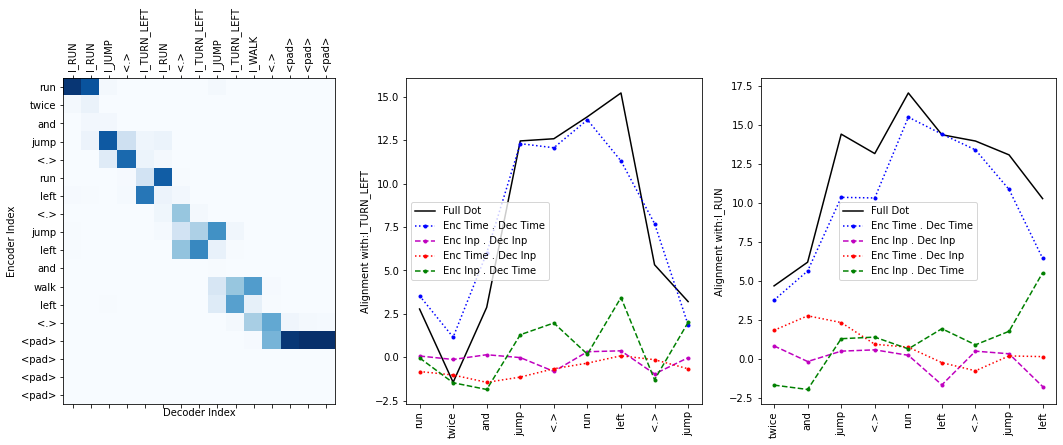

In [ ]:
# Plots attention matrix of example phrase and shows dot product decomposition for certain words
phrase_idx = 10
dec_idxs = [4, 5]
look_dist = 4

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

# Calculate attention matrix via apply function
enc_len = hs_data['inputs'][0].shape[0]
dec_len =  hs_data['labels'][0].shape[0]
enc_labels = tensorToPhrase(hs_data['inputs'][phrase_idx], toy_params['in_words'])
dec_labels = tensorToPhrase(hs_data['labels'][phrase_idx], toy_params['out_words'])

avg_hs = find_avg_hs(hs, hs_data, toy_params)

_, new_apply_fun, _, _, _ = build_rnn(rnn_specs)
_, attn_matrix_dir = new_apply_fun(final_params, hs_data['inputs'], hs_data['in_index'], return_att_matrix=True)

enc_seq = hs['all'][phrase_idx][:enc_len]
for dec_idx, ax in zip(dec_idxs, (ax2, ax3)):
  enc_t = avg_hs[:enc_len]
  dec_t = avg_hs[enc_len:]
  enc_w = enc_seq - enc_t
  dec_w = hs['all'][phrase_idx][enc_len:] - dec_t
  full_dot = np.dot(enc_seq, hs['all'][phrase_idx][enc_len+dec_idx])[dec_idx-look_dist:dec_idx+look_dist+1]
  temporal_dot = np.dot(enc_t, dec_t[dec_idx])[dec_idx-look_dist:dec_idx+look_dist+1]
  word_dot = np.dot(enc_w, dec_w[dec_idx])[dec_idx-look_dist:dec_idx+look_dist+1]
  enc_t_dec_w = np.dot(enc_t, dec_w[dec_idx])[dec_idx-look_dist:dec_idx+look_dist+1]
  enc_w_dec_t = np.dot(enc_w, dec_t[dec_idx])[dec_idx-look_dist:dec_idx+look_dist+1]
  
  ax.plot([i for i in range(dec_idx-look_dist, dec_idx+look_dist+1)], full_dot, color='k', label='Full Dot')
  ax.plot([i for i in range(dec_idx-look_dist, dec_idx+look_dist+1)], temporal_dot, color='b', marker='.', linestyle='dotted', label='Enc Time . Dec Time')
  ax.plot([i for i in range(dec_idx-look_dist, dec_idx+look_dist+1)], word_dot, color='m', marker='.', linestyle='dashed', label='Enc Inp . Dec Inp')
  ax.plot([i for i in range(dec_idx-look_dist, dec_idx+look_dist+1)], enc_t_dec_w, color='r', marker='.', linestyle='dotted', label='Enc Time . Dec Inp')
  ax.plot([i for i in range(dec_idx-look_dist, dec_idx+look_dist+1)], enc_w_dec_t, color='g', marker='.', linestyle='dashed', label='Enc Inp . Dec Time')
  # Sanity check
  # ax.plot([i for i in range(dec_idx-look_dist, dec_idx+look_dist+1)], temporal_dot+word_dot+enc_t_dec_w+enc_w_dec_t, color='k', marker='o', 
  #  linestyle='solid', label='Sum')
  

  plot_range = [i for i in range(dec_idx-look_dist, dec_idx+look_dist+1)]
  ax.set_xticks(plot_range)
  ax.set_xticklabels(enc_labels[dec_idx-look_dist:dec_idx+look_dist+1], rotation=90)
  ax.set_ylabel('Alignment with:' + dec_labels[dec_idx])

  ax.legend()

ax1.matshow(attn_matrix_dir[phrase_idx], cmap=plt.cm.Blues)

ax1.set_xticks([j for j in range(dec_len)])
ax1.set_yticks([j for j in range(enc_len)])
ax1.set_yticklabels(enc_labels, rotation=0)
ax1.set_xticklabels(dec_labels, rotation=90)

ax1.set_ylabel('Encoder Index')
ax1.set_xlabel('Decoder Index')


In [ ]:

# Calculates average hidden state and subtracts it out from hidden states at all time steps to isolate word subspace
# Average hidden state does NOT include repeated <pad>'s for encoder or decoder
context_word = '<.>'
other_words = ['run', 'walk', 'exercise']

cw_idx = toy_params['in_words'].index(context_word)
ow_idxs = [toy_params['in_words'].index(word) for word in other_words]

avg_hs = np.zeros((hs['all'][0].shape))
pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 
enc_len = hs_data['inputs'][0].shape[0]
dec_len = toy_params['phrase_length']

for time_idx in range(hs['all'][0].shape[0]):
  if time_idx < enc_len: # Encoder
    time_hs = []
    for h, inp in zip(hs['all'], hs_data['inputs']):
      if time_idx > 0:
        if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  else: # Decoder
    time_hs = []
    for h, out in zip(hs['all'], hs_data['labels']):
      if time_idx - enc_len> 0:
        if np.argmax(out[time_idx-enc_len]) != pad_out_idx or np.argmax(out[time_idx-enc_len-1]) != pad_out_idx:
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  if time_hs.shape[0] > 0:
    avg_hs[time_idx] = np.mean(time_hs, axis=0)
  else:
    print('Zero length')

# Removes average hidden state from all hidden states
hs_mod_pos_enc = [h - avg_hs for h in hs['all']]

hs_word = [[] for _ in range(len(toy_params['in_words_pp']))]
hs_inputs_context = [[] for _ in range(len(other_words))]

pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 

for time_idx in range(enc_len): # Encoder
  for h_mpe, inp in zip(hs_mod_pos_enc, hs_data['inputs']):
    if time_idx > 0:
      if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
        hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    else: # Automatically adds if first index
      hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    if np.argmax(inp[time_idx]) == cw_idx and time_idx > 0:
      last_inp = inp[time_idx-1]
      last_inp_idx = np.argmax(last_inp)
      if last_inp_idx in ow_idxs:
        hs_inputs_context[ow_idxs.index(last_inp_idx)].append(h_mpe[time_idx])

print('Done')

Done


Text(0, 0.5, 'PC1 (mod pos_enc)')

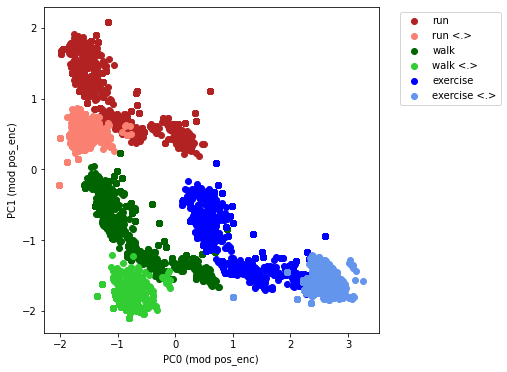

In [ ]:
# Plots decomposition of hidden states into temporal and word spaces
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))

##### Plotting for word part #####

pts_subset = 'enc'

pc1 = 0
pc2 = 1

pca_mod_pe = PCA(n_components=rnn_specs['hidden_size'])

_ = pca_mod_pe.fit(np.vstack(np.asarray(hs_mod_pos_enc)[:,:enc_len,:]))
pca_mod_pe_hs = pca_mod_pe.transform(np.vstack(hs_mod_pos_enc)).T

pca_hs = pca_mod_pe.transform(np.vstack(hs['all'])).T
for inp_idx in ow_idxs:
  pca_mod_pe_word = pca_mod_pe.transform(np.vstack(hs_word[inp_idx])).T
  ax1.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[inp_idx], label=toy_params['in_words'][inp_idx])
  pca_mod_pe_cword = pca_mod_pe.transform(np.vstack(hs_inputs_context[inp_idx])).T
  ax1.scatter(pca_mod_pe_cword[pc1], pca_mod_pe_cword[pc2], color=state_colors_light[inp_idx], 
              label=toy_params['in_words'][inp_idx] + ' ' + context_word)

# Plots readout direction
# readout_types = ['att']  #'att', 'hs', 'sum'] # 'att' or 'hs'
# ro_styles = ['solid', 'dotted', 'dashed']
# for idx in range(len(readout_types)):
#   if readout_types[idx] == 'att':
#     readout_plot = readout 
#     # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
#   elif readout_types[idx] == 'hs':
#     readout_plot = readout_dec
#     # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
#   elif readout_types[idx] == 'sum':
#     readout_plot = readout + readout_dec
#   pca_ro = pca_avg.transform(readout_plot)
#   pca_zero = pca_avg.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
#   for i in range(readout_plot.shape[0]):
#     x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
#     y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
#     ax1.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, linestyle=ro_styles[idx],
#               label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax1.set_xlabel('PC'+str(pc1)+' (mod pos_enc)')
ax1.set_ylabel('PC'+str(pc2)+' (mod pos_enc)')

In [ ]:
# This does the same thing as an above cell, but simply saves the context hidden states as something else. Used for plotting all distinct phrases below
context_word2 = 'left'
other_words = ['run', 'walk', 'exercise']

cw_idx = toy_params['in_words'].index(context_word2)
ow_idxs2 = [toy_params['in_words'].index(word) for word in other_words]

avg_hs = np.zeros((hs['all'][0].shape))
pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 
enc_len = hs_data['inputs'][0].shape[0]
dec_len = toy_params['phrase_length']

for time_idx in range(hs['all'][0].shape[0]):
  if time_idx < enc_len: # Encoder
    time_hs = []
    for h, inp in zip(hs['all'], hs_data['inputs']):
      if time_idx > 0:
        if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  else: # Decoder
    time_hs = []
    for h, out in zip(hs['all'], hs_data['labels']):
      if time_idx - enc_len> 0:
        if np.argmax(out[time_idx-enc_len]) != pad_out_idx or np.argmax(out[time_idx-enc_len-1]) != pad_out_idx:
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  if time_hs.shape[0] > 0:
    avg_hs[time_idx] = np.mean(time_hs, axis=0)
  else:
    print('Zero length')

# Removes average hidden state from all hidden states
hs_mod_pos_enc = [h - avg_hs for h in hs['all']]

hs_word = [[] for _ in range(len(toy_params['in_words_pp']))]
hs_inputs_context2 = [[] for _ in range(len(other_words))]

pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 

for time_idx in range(enc_len): # Encoder
  for h_mpe, inp in zip(hs_mod_pos_enc, hs_data['inputs']):
    if time_idx > 0:
      if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
        hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    else: # Automatically adds if first index
      hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    if np.argmax(inp[time_idx]) == cw_idx and time_idx > 0:
      last_inp = inp[time_idx-1]
      last_inp_idx = np.argmax(last_inp)
      if last_inp_idx in ow_idxs2:
        hs_inputs_context2[ow_idxs2.index(last_inp_idx)].append(h_mpe[time_idx])

print('Done')

Done


Text(0, 0.5, 'PC1 (mod pos_enc)')

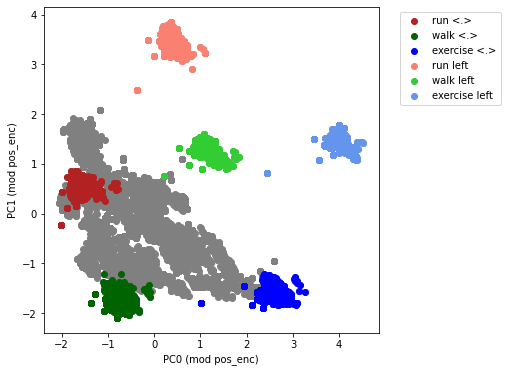

In [ ]:
# Used to plot multiple sets of context words
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))

##### Plotting for word part #####

pts_subset = 'enc'

pc1 = 0
pc2 = 1

pca_mod_pe = PCA(n_components=rnn_specs['hidden_size'])

_ = pca_mod_pe.fit(np.vstack(np.asarray(hs_mod_pos_enc)[:,:enc_len,:]))
pca_mod_pe_hs = pca_mod_pe.transform(np.vstack(hs_mod_pos_enc)).T

ax1.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')

pca_hs = pca_mod_pe.transform(np.vstack(hs['all'])).T
for inp_idx in ow_idxs:
  pca_mod_pe_cword = pca_mod_pe.transform(np.vstack(hs_inputs_context[inp_idx])).T
  ax1.scatter(pca_mod_pe_cword[pc1], pca_mod_pe_cword[pc2], color=state_colors[inp_idx], 
              label=toy_params['in_words'][inp_idx] + ' ' + context_word)
  
for inp_idx in ow_idxs2:
  pca_mod_pe_cword = pca_mod_pe.transform(np.vstack(hs_inputs_context2[inp_idx])).T
  ax1.scatter(pca_mod_pe_cword[pc1], pca_mod_pe_cword[pc2], color=state_colors_light[inp_idx], 
              label=toy_params['in_words'][inp_idx] + ' ' + context_word2)

# Plots readout direction
# readout_types = ['att']  #'att', 'hs', 'sum'] # 'att' or 'hs'
# ro_styles = ['solid', 'dotted', 'dashed']
# for idx in range(len(readout_types)):
#   if readout_types[idx] == 'att':
#     readout_plot = readout 
#     # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
#   elif readout_types[idx] == 'hs':
#     readout_plot = readout_dec
#     # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
#   elif readout_types[idx] == 'sum':
#     readout_plot = readout + readout_dec
#   pca_ro = pca_avg.transform(readout_plot)
#   pca_zero = pca_avg.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
#   for i in range(readout_plot.shape[0]):
#     x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
#     y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
#     ax1.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, linestyle=ro_styles[idx],
#               label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax1.set_xlabel('PC'+str(pc1)+' (mod pos_enc)')
ax1.set_ylabel('PC'+str(pc2)+' (mod pos_enc)')

#### Many to One Analysis

Finding average hidden state at each time step...
Using minimum sequence length of: 15
Average offset [0.         0.         0.307      0.904      0.915      0.952
 1.015      1.203      1.577      1.831      1.885      2.0010142
 2.19284802 2.52141802 2.96226415 2.99173554 3.0070922         nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


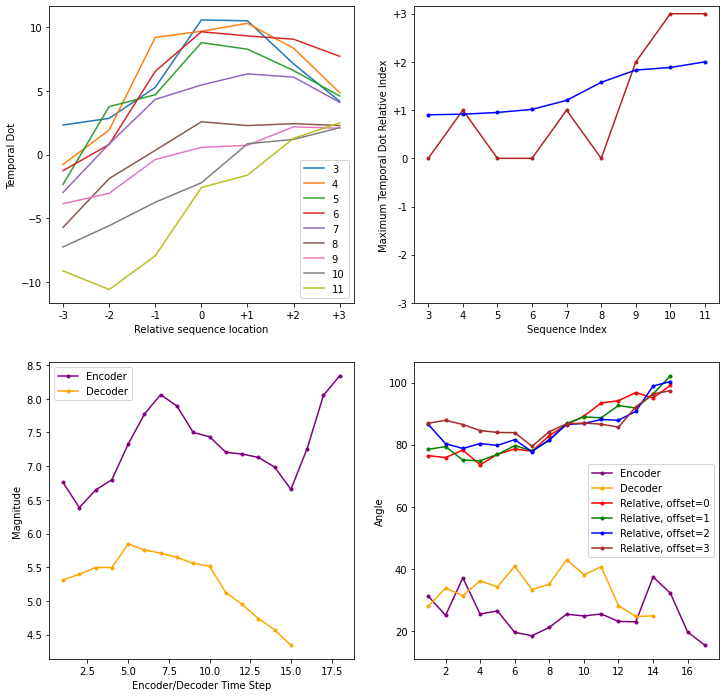

In [45]:
from scipy.special import softmax

avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

look_dist = 3 # How many time-steps to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])
print('Using minimum sequence length of:', min_len)

dot_vals = np.zeros((min_len-2*look_dist, 2*look_dist+1))

offset = 0 # Negative means encoder location is before decoder locat

for seq_idx in range(min_len-2*look_dist):
  enc_loc = look_dist + seq_idx + offset # Location of latch word in input
  dec_loc = look_dist + seq_idx # Location of latch word in output

  dot_vals[seq_idx, :] = np.dot(avg_hs[:enc_len], avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]

avg_offset = analysis.find_scan_offset(hs_data, toy_params)
print('Average offset', avg_offset)

avg_hs_mags = np.array([np.linalg.norm(hs_time) for hs_time in avg_hs])
avg_hs_angles = np.array([analysis.angle_degrees(avg_hs[i], avg_hs[i+1]) for i in range(avg_hs.shape[0]-1)])
avg_hs_rel_angles = np.array([analysis.angle_degrees(avg_hs[i], avg_hs[enc_len+i]) for i in range(dec_len)])
avg_hs_rel_angles1 = np.array([analysis.angle_degrees(avg_hs[i+1], avg_hs[enc_len+i]) for i in range(dec_len)])
avg_hs_rel_angles2 = np.array([analysis.angle_degrees(avg_hs[i+2], avg_hs[enc_len+i]) for i in range(dec_len)])
avg_hs_rel_angles3 = np.array([analysis.angle_degrees(avg_hs[i+3], avg_hs[enc_len+i]) for i in range(dec_len)])

# for ld_idx in range(2*look+1):


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

for seq_idx in range(min_len-2*look_dist):
  ax1.plot([i - look_dist for i in range(2*look_dist+1)], dot_vals[seq_idx], label=str(seq_idx+look_dist))
ax1.set_ylabel('Temporal Dot')
ax1.set_xlabel('Relative sequence location')
ax1.legend()

max_dot_idx = np.argmax(dot_vals, axis=1)

ax2.plot([i+look_dist for i in range(min_len-2*look_dist)], max_dot_idx, color='firebrick', marker='.')
ax2.plot([i+look_dist for i in range(min_len-2*look_dist)], avg_offset[look_dist:min_len-look_dist]+look_dist, color='b', marker='.')

ax2.set_ylabel('Maximum Temporal Dot Relative Index')
ax2.set_xlabel('Sequence Index')

ax1.set_xticks([j-look_dist for j in range(2*look_dist + 1)])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

ax2.set_yticks([j for j in range(2*look_dist + 1)])
ax2.set_yticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

ax3.plot([time_step+1 for time_step in range(enc_len)], avg_hs_mags[:enc_len], color='purple', marker='.', label='Encoder')
ax3.plot([time_step+1 for time_step in range(dec_len)], avg_hs_mags[enc_len:], color='orange', marker='.', label='Decoder')
ax3.set_xlabel('Encoder/Decoder Time Step')
ax3.set_ylabel('Magnitude')
ax3.legend()

ax4.plot([time_step+1 for time_step in range(enc_len-1)], avg_hs_angles[:enc_len-1], color='purple', marker='.', label='Encoder')
ax4.plot([time_step+1 for time_step in range(dec_len-1)], avg_hs_angles[enc_len:], color='orange', marker='.', label='Decoder')
ax4.plot([time_step+1 for time_step in range(dec_len)], avg_hs_rel_angles, color='red', marker='.', label='Relative, offset=0')
ax4.plot([time_step+1 for time_step in range(dec_len)], avg_hs_rel_angles1, color='green', marker='.', label='Relative, offset=1')
ax4.plot([time_step+1 for time_step in range(dec_len)], avg_hs_rel_angles2, color='blue', marker='.', label='Relative, offset=2')
ax4.plot([time_step+1 for time_step in range(dec_len)], avg_hs_rel_angles3, color='brown', marker='.', label='Relative, offset=3')
ax3.set_xlabel('Encoder/Decoder Time Step')
ax4.set_ylabel('Angle')
ax4.legend()

In [39]:
displacements = np.zeros((len(hs_data['inputs']), hs_data['inputs'][0].shape[0]))
length_count = np.zeros((enc_len))
and_idx = toy_params['in_words'].index('and')
left_idx = toy_params['in_words'].index('left')

for idx, h_inp, in_idx in zip(range(len(hs_data['inputs'])), hs_data['inputs'], hs_data['in_index']):
  length_count[:in_idx] += np.ones((in_idx)) # Tracks length of phrases

  and_locs = np.argmax(h_inp, axis=1) == and_idx
  left_locs = np.argmax(h_inp, axis=1) == left_idx

  and_locs = np.asarray(and_locs, dtype=np.int32)
  left_locs = np.asarray(left_locs, dtype=np.int32) # Converts into integers
  left_locs = left_locs -1 * np.roll(left_locs, shift=-1) # Accounts for lefts and word after left

  displacements[idx, :in_idx] = [np.sum(and_locs[:i+1] + left_locs[:i]) for i in range(in_idx)]

Finding average hidden state at each time step...
Average offset [0.332      0.307      1.017      1.13       0.994      1.158
 1.34       1.657      2.         2.007      2.09       2.30933063
 2.53895275 2.94830133 3.10566038 2.99173554 3.0070922         nan]
Max dot index: [ 0  0  3  3  5  5  6  8  8 11 17 17 17  2  2]


/content/drive/My Drive/ml_research/fixedpoints_nlp/seq2seq_files/analysis.py:322: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 0, 'Sequence Index')

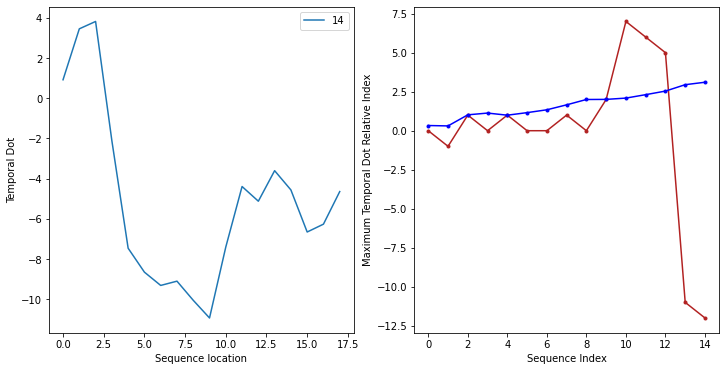

In [48]:
# Same as above, but no finite look distance, just looks at entire encoder sequence

from scipy.special import softmax

avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])

dot_vals = np.zeros((dec_len, enc_len))

for seq_idx in range(dec_len):
  dot_vals[seq_idx, :] = np.dot(avg_hs[:enc_len], avg_hs[enc_len + seq_idx])

avg_offset = analysis.find_scan_offset(hs_data, toy_params)

print('Average offset', avg_offset)

avg_hs_mags = np.array([np.linalg.norm(hs_time) for hs_time in avg_hs])
avg_hs_angles = np.array([analysis.angle_degrees(avg_hs[i], avg_hs[i+1]) for i in range(avg_hs.shape[0]-1)])
avg_hs_rel_angles = np.array([analysis.angle_degrees(avg_hs[i], avg_hs[enc_len+i]) for i in range(dec_len)])
avg_hs_rel_angles1 = np.array([analysis.angle_degrees(avg_hs[i+1], avg_hs[enc_len+i]) for i in range(dec_len)])
avg_hs_rel_angles2 = np.array([analysis.angle_degrees(avg_hs[i+2], avg_hs[enc_len+i]) for i in range(dec_len)])
avg_hs_rel_angles3 = np.array([analysis.angle_degrees(avg_hs[i+3], avg_hs[enc_len+i]) for i in range(dec_len)])

# for ld_idx in range(2*look+1):


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# for seq_idx in range(dec_len):
#   ax1.plot([i for i in range(enc_len)], dot_vals[seq_idx], label=str(seq_idx))
ax1.plot([i for i in range(enc_len)], dot_vals[14], label=str(14))
ax1.set_ylabel('Temporal Dot')
ax1.set_xlabel('Sequence location')
ax1.legend()

max_dot_idx = np.argmax(dot_vals, axis=1)
print('Max dot index:', max_dot_idx)

ax2.plot([i for i in range(dec_len)], [max_dot_idx[i] - i for i in range(max_dot_idx.shape[0])], color='firebrick', marker='.')
ax2.plot([i for i in range(dec_len)], avg_offset[:dec_len], color='b', marker='.')

ax2.set_ylabel('Maximum Temporal Dot Relative Index')
ax2.set_xlabel('Sequence Index')

Finding average hidden state at each time step...


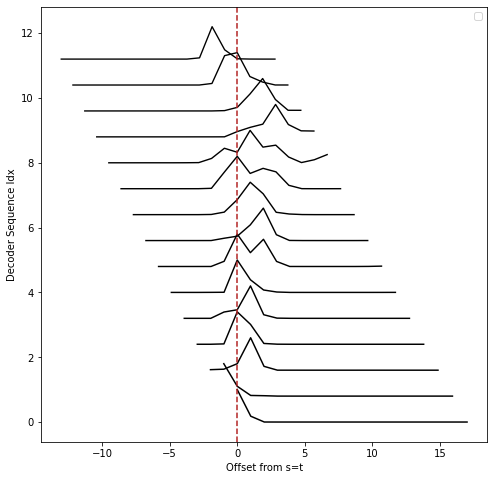

In [ ]:
avg_hs = find_avg_hs(hs, hs_data, toy_params)

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])

dot_vals = np.zeros((dec_len, enc_len))

for seq_idx in range(dec_len):
  raw_dots = softmax(np.dot(avg_hs[:enc_len], avg_hs[enc_len+seq_idx]))
  # Normalizes dot product between 0 and 1
  dot_vals[seq_idx, :] = (raw_dots - np.min(raw_dots))/(np.max(raw_dots)-np.min(raw_dots))

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# for seq_idx in range(dec_len):
#   ax1.plot([i-seq_idx for i in range(enc_len)], dot_vals[seq_idx], label=str(seq_idx+look_dist))

# Generate line plots
lines = []
for seq_idx in range(dec_len):
  # Small reduction of the X extents to get a cheap perspective effect
  xscale = 1 - seq_idx / 200.
  # Same for linewidth (thicker strokes on bottom)
  lw = 1.5 - seq_idx / 100.0
  line, = ax1.plot([xscale *(i-seq_idx) for i in range(enc_len)], 0.8*seq_idx + dot_vals[seq_idx], color='k', lw=lw)
  lines.append(line)

ax1.axvline(0.0, color='firebrick', linestyle='dashed')
ax1.set_ylabel('Decoder Sequence Idx')
ax1.set_xlabel('Offset from s=t')
ax1.legend()


In [ ]:
# Create new Figure with black background
fig = plt.figure(figsize=(8, 8), facecolor='black')

# Add a subplot with no frame
ax = plt.subplot(111, frameon=False)

# Generate random data
data = np.random.uniform(0, 1, (64, 75))
X = np.linspace(-1, 1, data.shape[-1])
G = 1.5 * np.exp(-4 * X ** 2)

# Generate line plots
lines = []
for i in range(len(data)):
    # Small reduction of the X extents to get a cheap perspective effect
    xscale = 1 - i / 200.
    # Same for linewidth (thicker strokes on bottom)
    lw = 1.5 - i / 100.0
    line, = ax.plot(xscale * X, i + G * data[i], color="w", lw=lw)
    lines.append(line)

# Set y limit (or first line is cropped because of thickness)
ax.set_ylim(-1, 70)

#### Null Input vs Temporal Component

Finding average hidden state at each time step...
Mean difference: 0.12108518748612396
Mean angle: 6.9072203871220035


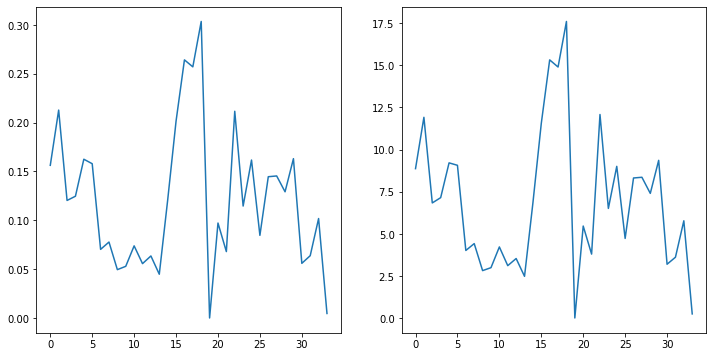

In [ ]:
# Checks to see how close the null input is to the average hidden state.

avg_hs = find_avg_hs(hs, hs_data, toy_params)

null_input = hs['special'][-1]

diffs = avg_hs - null_input
diff_ratio = np.linalg.norm(diffs, axis=1)/np.linalg.norm(avg_hs, axis=1)
angles = np.array([angle_degrees(null, avg) for null, avg in zip(null_input, avg_hs)])
print('Mean difference:', np.mean(diff_ratio))
print('Mean angle:', np.mean(angles))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.plot(diff_ratio)
ax2.plot(angles, )

#### Positional Encoding and One-Hot Tests

Minimum angle: 66.83707147516884
Maximum angle: 115.14109578759171


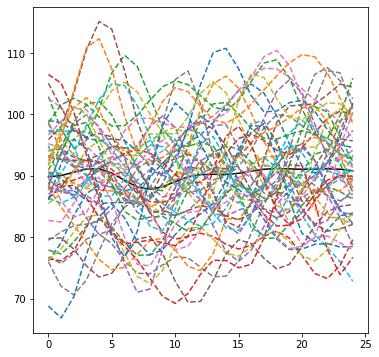

In [ ]:
seq_length_test = 25
word_dims = 50
test_seq = np.zeros((1, seq_length_test, word_dims))

pos_enc_params = {'pos_enc': True, 'time_scale': 100.0, 'amplitude': 1.0}

random_pos_enc_rot = rvs(word_dims)
# random_pos_enc_rot = np.identity(word_dims)  

pos_enc = positional_encoding(test_seq, scale=pos_enc_params['time_scale'], amp=pos_enc_params['amplitude'], 
                              rot=random_pos_enc_rot)

pe_vec = pos_enc[0]

dots = np.zeros((word_dims, seq_length_test)) 
for dim_idx in range(word_dims):
  one_hot_vec = np.zeros((word_dims))
  one_hot_vec[dim_idx] = 1.0
  for seq_idx in range(seq_length_test):
    dots[dim_idx, seq_idx] = 180/np.pi * np.arccos(np.dot(pe_vec[seq_idx], one_hot_vec)/(np.linalg.norm(pe_vec[seq_idx])*np.linalg.norm(one_hot_vec)))

avg_dots = np.mean(dots, axis=0)

print('Minimum angle:', np.min(dots))
print('Maximum angle:', np.max(dots))

fig, ax1 = plt.subplots(1, 1, figsize=(6,6))
ax1.plot([i for i in range(seq_length_test)], avg_dots, color='k', linestyle='solid')
for dim_idx in range(word_dims):
  ax1.plot([i for i in range(seq_length_test)], dots[dim_idx],  linestyle='dashed')

### Ensemble Plotting

In [11]:
# Loads many networks and computes accuracy and average hs dots
base_path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/ao_andlefttwicescan_nolefttwice_5datasets_l2is1e-4.pickle'
dot_idx = base_path.index('.')
data_type = 'scan'
n_trials = 1000

# trial_idxs = [10,]
# trial_idxs = [1, 2, 8, 9, 10, 11, 12, 13]
trial_idxs = [17, 18, 20]

for trial_idx in range(len(trial_idxs)):

  new_path = base_path[:dot_idx] + '_' + str(trial_idxs[trial_idx]) + base_path[dot_idx:]
  with open(new_path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

  rnn_params, rnn_params_dec, readout_params = params_loaded
  final_params = params_loaded
  train_params, toy_params, rnn_specs = train_build.default_params(train_params, toy_params, rnn_specs)

  if trial_idx == 0: # Only generates new data on first run
    scan_data, _ = scan.generate_scan(raw_in_phrases, raw_out_phrases, toy_params['scan_params'], trials=n_trials)
    hs_data =  {
      'inputs': scan_data['inputs'],
      'labels': scan_data['labels'],
      'in_index': scan_data['in_index'],
      'out_index': scan_data['out_index'],
    }

    enc_len = hs_data['inputs'][0].shape[0]
    dec_len = hs_data['labels'][0].shape[0]
    trial_dot_vals = np.zeros((len(trial_idxs), dec_len, enc_len))

  # Builds new apply and accuracy function
  _, apply_fun, _, _, accuracy_fun = train_build.build_rnn(rnn_specs)
  phrase_acc, word_acc = accuracy_fun(final_params, hs_data)
  print(f'Trial: {trial_idxs[trial_idx]},  Test Acc:', np.mean(phrase_acc), ', Word Acc:', np.mean(word_acc))

  # Gets raw hidden states
  cell, _ = analysis.build_cell(rnn_specs)
  cell_dec, readout_apply = analysis.build_cell(rnn_specs)
  cells = cell, cell_dec
  hs = {}
  hs['all'] = analysis.rnn_states(cells, readout_apply, hs_data, final_params, rnn_specs)

  avg_hs = analysis.find_avg_hs(hs, hs_data, toy_params)

  for seq_idx in range(dec_len):
    raw_dots = np.dot(avg_hs[:enc_len], avg_hs[enc_len+seq_idx])
    trial_dot_vals[trial_idx, seq_idx, :] = raw_dots


SCAN data generated in: 0.05 sec.
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Trial: 17,  Test Acc: 0.92200005 , Word Acc: 0.9835333
Using GRU cell
Using GRU cell
Get all states with arch: enc_dec_atth
Running attnh with pos_enc: True
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Finding average hidden state at each time step...
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Trial: 18,  Test Acc: 0.89500004 , Word Acc: 0.98260003
Using GRU cell
Using GRU cell
Get all states with arch: enc_dec_atth
Running attnh with pos_enc: True
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Finding average hidden state at each time step...
Adding pos_enc 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


Average offset [0.         0.         0.286      0.898      0.906      0.951
 1.014      1.171      1.557      1.813      1.864      1.9787234
 2.16688062 2.53008596 2.95421245 2.98963731 3.                nan]


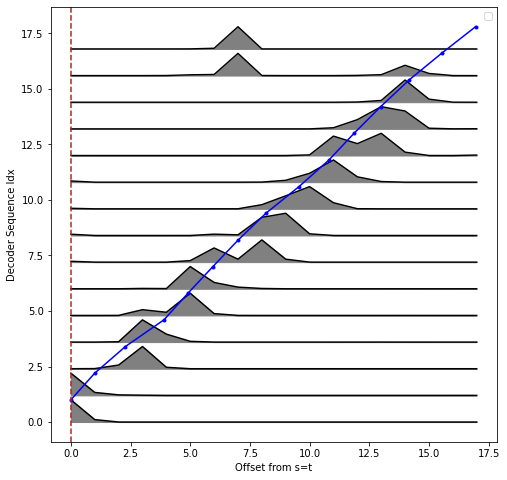

In [30]:
avg_dot_vals = np.mean(trial_dot_vals, axis=0)
end_pad = 0
avg_softmax_vals = np.zeros((dec_len, enc_len - end_pad))
for seq_idx in range(dec_len):
  if end_pad > 0:
    avg_softmax = softmax(avg_dot_vals[seq_idx,:-end_pad])
  else:
    avg_softmax = softmax(avg_dot_vals[seq_idx,:])
  # Normalizes dot product between 0 and 1
  avg_softmax_vals[seq_idx, :] = (avg_softmax - np.min(avg_softmax))/(np.max(avg_softmax)-np.min(avg_softmax))

avg_offset = analysis.find_scan_offset(hs_data, toy_params)
print('Average offset', avg_offset)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Generate line plots
y_spacing = 1.2

lines = []
for seq_idx in range(dec_len):
  # Same for linewidth (thicker strokes on bottom)
  lw = 1.5 - seq_idx / 100.0
  # line, = ax1.plot([i-seq_idx for i in range(enc_len- end_pad)], y_spacing*seq_idx + avg_softmax_vals[seq_idx], color='k', lw=lw)
  # ax1.fill_between([i-seq_idx for i in range(enc_len- end_pad)], y_spacing*seq_idx, y_spacing*seq_idx + avg_softmax_vals[seq_idx], color='grey')
  line, = ax1.plot([i for i in range(enc_len- end_pad)], y_spacing*seq_idx + avg_softmax_vals[seq_idx], color='k', lw=lw)
  ax1.fill_between([i for i in range(enc_len- end_pad)], y_spacing*seq_idx, y_spacing*seq_idx + avg_softmax_vals[seq_idx], color='grey')

  lines.append(line)

# ax1.plot(avg_offset[:dec_len], [y_spacing*seq_idx+1 for seq_idx in range(dec_len)], color='b', marker='.')
ax1.plot([avg_offset[i] + i for i in range(avg_offset[:dec_len].shape[0])], [y_spacing*seq_idx+1 for seq_idx in range(dec_len)], color='b', marker='.')

ax1.axvline(0.0, color='firebrick', linestyle='dashed')
ax1.set_ylabel('Decoder Sequence Idx')
ax1.set_xlabel('Offset from s=t')
ax1.legend()
# ax1.set_xlim([-8, 8])

Average offset [0.         0.         0.323      0.901      0.91       0.956
 1.015      1.197      1.588      1.833      1.884      1.98291457
 2.20050441 2.54069767 2.95211786 2.98607242 3.00694444 4.
        nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 0, 'Sequence Index')

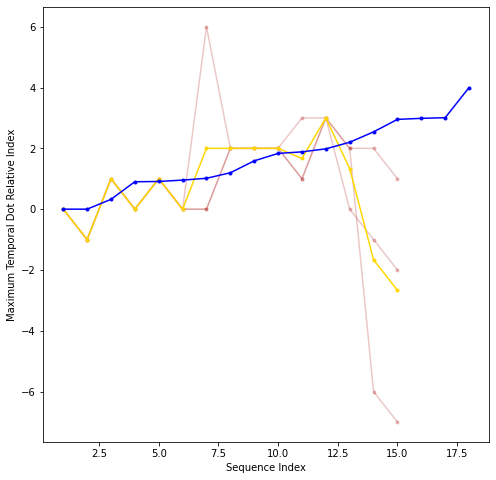

In [16]:
end_pad = 3
rel_argmax_locs = np.zeros((len(trial_idxs), enc_len-end_pad-1))
for trial_idx in range(len(trial_idxs)):
  argmax_vals = np.argmax(trial_dot_vals[trial_idx, :, :-end_pad], axis=1)
  rel_argmax_locs[trial_idx] = np.array([argmax_vals[i]-i for i in range(argmax_vals.shape[0])])

avg_offset = analysis.find_scan_offset(hs_data, toy_params)
print('Average offset', avg_offset)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

for trial_idx in range(len(trial_idxs)):
  ax1.plot([i+1 for i in range(dec_len)], rel_argmax_locs[trial_idx], color='firebrick', marker='.', alpha=0.25)
# ax1.plot([i+1 for i in range(dec_len)], rel_argmax_locs[trial_idxs.index(0)], color='green', marker='.')

ax1.plot([i+1 for i in range(dec_len)], np.mean(rel_argmax_locs, axis=0), color='gold', marker='.')
ax1.plot([i+1 for i in range(enc_len-1)], avg_offset[:-1], color='b', marker='.')

ax1.set_ylabel('Maximum Temporal Dot Relative Index')
ax1.set_xlabel('Sequence Index')

Sythentic data generated in: 0.11 sec.
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 20.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 20.0
Zero context True
Test Acc: 1.0 , Word Acc: 1.0
Get all states with arch: enc_dec_atth
Running attnh with pos_enc: standard
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 20.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 20.0
Zero context True
Sythentic data generated in: 0.11 sec.
Test Acc: 1.0 , Word Acc: 1.0
Get all states with arch: enc_dec_atth
Running attnh with pos_enc: False
Sythentic data generated in: 0.15 sec.
Zero context False
Test Acc: 1.0 , Word Acc: 1.0


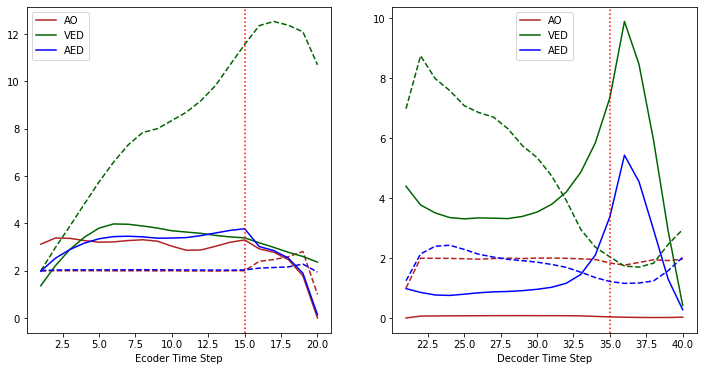

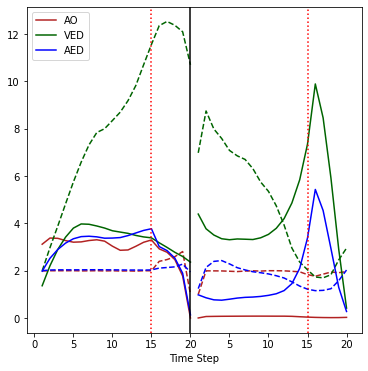

In [ ]:
# Plots variances for several architectures

ved_path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/ved_toy_3words_15to20_l2is1e-4_7.pickle'
ao_path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/ao_toy_3words_15to20_l2is1e-3_2.pickle'
aed_path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/aed_toy_3words_15to20_l2is1e-3_3.pickle'
paths = [ao_path, ved_path, aed_path]
data_type = 'toy'
n_trials = 1000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig, ax3 = plt.subplots(1, 1, figsize=(6,6))


for trial_idx in range(len(paths)):
  with open(paths[trial_idx], 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

  rnn_params, rnn_params_dec, readout_params = params_loaded
  final_params = params_loaded
  train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)

  
  hs_data = generate_data(n_trials, toy_params, rnn_specs)

  enc_len = hs_data['inputs'][0].shape[0]
  dec_len = hs_data['labels'][0].shape[0]
  min_len = np.min([enc_len, dec_len])

  if trial_idx == 0: # Only generates new data on first run
    time_var = np.zeros((len(paths), enc_len+dec_len))
    time_pr = np.zeros((len(paths), enc_len+dec_len))

  # Builds new apply and accuracy function
  _, apply_fun, _, _, accuracy_fun = build_rnn(rnn_specs)

  phrase_acc, word_acc = accuracy_fun(final_params, hs_data)
  print(f'Test Acc:', np.mean(phrase_acc), ', Word Acc:', np.mean(word_acc))

  # Gets raw hidden states
  hs['all'] = rnn_states(hs_data, final_params, rnn_specs)

  hs_time_word_enc, hs_time_word_dec = sort_hs_by_time_and_word(hs, hs_data, toy_params)

  for time_idx in range(hs['all'][0].shape[0]):
    time_hs = []
    if time_idx < enc_len: # Encoder
      for word_list in hs_time_word_enc[time_idx]:
        time_hs.extend(word_list)
    else: # Decoder
      for word_list in hs_time_word_dec[time_idx-enc_len]:
        time_hs.extend(word_list)
      
    time_hs = np.array(time_hs)
    pca_time = PCA(n_components=np.min([time_hs.shape[0], rnn_specs['hidden_size']]))
    _ = pca_time.fit_transform(time_hs)
    time_var[trial_idx, time_idx] = np.sum(pca_time.explained_variance_)
    time_pr[trial_idx, time_idx] = participation_ratio_vector(pca_time.explained_variance_)

trial_labels = ['AO', 'VED', 'AED']
for trial_idx in range(len(paths)):
  enc_times = [i+1 for i in range(enc_len)]
  dec_times = [i+1+enc_len for i in range(dec_len)]
  ax1.plot(enc_times, time_var[trial_idx, :enc_len], color=state_colors[trial_idx], label=trial_labels[trial_idx])
  ax1.plot(enc_times, time_pr[trial_idx, :enc_len], color=state_colors[trial_idx], linestyle='dashed')
  ax2.plot(dec_times, time_var[trial_idx, enc_len:], color=state_colors[trial_idx], label=trial_labels[trial_idx])
  ax2.plot(dec_times, time_pr[trial_idx, enc_len:], color=state_colors[trial_idx], linestyle='dashed')
  ax3.plot(enc_times, time_var[trial_idx, :enc_len], color=state_colors[trial_idx], label=trial_labels[trial_idx])
  ax3.plot(enc_times, time_pr[trial_idx, :enc_len], color=state_colors[trial_idx], linestyle='dashed')
  ax3.plot(dec_times, time_var[trial_idx, enc_len:], color=state_colors[trial_idx])
  ax3.plot(dec_times, time_pr[trial_idx, enc_len:], color=state_colors[trial_idx], linestyle='dashed')

ax1.axvline(15, color='r', linestyle='dotted')
ax2.axvline(35, color='r', linestyle='dotted')
ax3.axvline(15, color='r', linestyle='dotted')
ax3.axvline(35, color='r', linestyle='dotted')
ax3.axvline(20, color='k', linestyle='solid')

ax1.set_xlabel('Ecoder Time Step')
ax2.set_xlabel('Decoder Time Step')
ax3.set_xlabel('Time Step')

ax3.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
ax3.set_xticklabels([0, 5, 10, 15, 20, 5, 10, 15, 20])

ax1.legend()
ax2.legend()
ax3.legend()

[Text(0, 0, 'AED toy'),
 Text(0, 0, 'AO toy'),
 Text(0, 0, 'AED eSCAN'),
 Text(0, 0, 'AO eSCAN')]

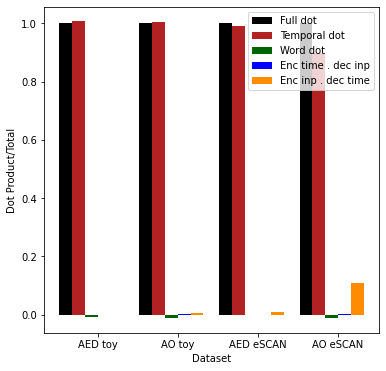

In [ ]:
# Percent of align data

# Order: Full dot, Temporal dot, Word dot, Enc time, Enc inp . dec time

aed_toy = [17.136137, 17.252214171335726, -0.11447536165135996, -0.005080152443500323, 0.003479022181664587]
ao_toy = [4.930403, 4.946632281094619, -0.05054207291767007, 0.002306375885632655, 0.03200617653480895]
ao_scan = [5.3862123, 4.843179396405194, -0.06289350489387595, 0.017220188715708212, 0.5887065548376492]
aed_scan = [23.908497, 23.7026692102443, -0.03883832767405657, -0.005785419624739229, 0.250452163056647]
datasets = [aed_toy, ao_toy, aed_scan, ao_scan]

full_dots = np.zeros((len(datasets)))
temp_dots = np.zeros((len(datasets)))
word_dots = np.zeros((len(datasets)))
enc_t_dec_i = np.zeros((len(datasets)))
enc_i_dec_t = np.zeros((len(datasets)))
for dot_vals, idx in zip(datasets, range(len(datasets))):
  full_dots[idx] = dot_vals[0]
  temp_dots[idx] = dot_vals[1]
  word_dots[idx] = dot_vals[2]
  enc_t_dec_i[idx] = dot_vals[3]
  enc_i_dec_t[idx] = dot_vals[4]

fig, ax1 = plt.subplots(1, 1, figsize=(6,6))
labels = ['Full dot', 'Temporal dot', 'Word dot', 'Enc time . dec inp', 'Enc inp . dec time']

ax1.bar([i for i in range(len(datasets))], full_dots/full_dots, width=0.16, color='k',  label=labels[0])
ax1.bar([i+0.16 for i in range(len(datasets))], temp_dots/full_dots, width=0.16, color=state_colors[0], label=labels[1])
ax1.bar([i+0.32 for i in range(len(datasets))], word_dots/full_dots, width=0.16, color=state_colors[1], label=labels[2])
ax1.bar([i+0.48 for i in range(len(datasets))], enc_t_dec_i/full_dots, width=0.16, color=state_colors[2], label=labels[3])
ax1.bar([i+0.64 for i in range(len(datasets))], enc_i_dec_t/full_dots, width=0.16, color=state_colors[3], label=labels[4])
ax1.set_ylabel('Dot Product/Total')
ax1.set_xlabel('Dataset')
ax1.legend()

ax1.set_xticks([i+0.4 for i in range(len(datasets))])
ax1.set_xticklabels(['AED toy', 'AO toy', 'AED eSCAN', 'AO eSCAN'])